In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sb

df = pd.read_csv('granada.csv', parse_dates=[0])
df2 = pd.read_csv('output_MERRA2.csv', parse_dates=[0])
df3 = pd.read_csv('IWV_RS.csv', parse_dates=[0])

df.head(5)

C:\Users\Raul\AppData\Local\Temp\ipykernel_2260\382360744.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Date,Station,NGL_GNSS,Instrument,IWV,dif,reldif,SZA
0,2010-05-17 06:00:00+00:00,Granada,7.85,Sun-photometer,8.102765,0.252765,3.219936,80.569670
1,2010-05-17 07:00:00+00:00,Granada,7.89,Sun-photometer,8.181510,0.291510,3.694677,68.924487
2,2010-05-17 08:00:00+00:00,Granada,8.01,Sun-photometer,8.196720,0.186720,2.331086,57.019668
3,2010-05-17 09:00:00+00:00,Granada,8.06,Sun-photometer,8.016702,-0.043298,-0.537190,45.128694
4,2010-05-17 10:00:00+00:00,Granada,8.49,Sun-photometer,8.307752,-0.182248,-2.146620,33.683717


Mostramos los datos de MERRA-2

In [2]:
df2.head(5)

,Date,TQV
0,2011-01-01 00:30:00+00:00,16.001852
1,2011-01-01 01:30:00+00:00,15.572654
2,2011-01-01 02:30:00+00:00,15.111708
3,2011-01-01 03:30:00+00:00,14.613722
4,2011-01-01 04:30:00+00:00,14.191130


In [3]:
df2.tail(5)

,Date,TQV
96427,2021-09-30 19:30:00+00:00,14.912318
96428,2021-09-30 20:30:00+00:00,15.365294
96429,2021-09-30 21:30:00+00:00,15.560668
96430,2021-09-30 22:30:00+00:00,15.482749
96431,2021-09-30 23:30:00+00:00,15.178077


In [4]:
df3.tail(5)

,Date,IWV_RS[kg/m2]
147,2023-01-31 12:45:00,3.706673
148,2023-02-02 13:05:00,7.153267
149,2023-03-03 11:39:00,4.674919
150,2023-03-14 10:26:00,8.461033
151,2023-04-14 10:29:00,10.514209


Comprobamos que los ficheros se han leido de forma que se pueda trabajar bien con fechas

In [5]:
for col in df:
    print(type(df[col][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'str'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [6]:
for col in df2:
    print(type(df2[col][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'numpy.float64'>


In [7]:
df.describe()

,NGL_GNSS,IWV,dif,reldif,SZA
count,57253.000000,73321.000000,57253.000000,57253.000000,73321.000000
mean,14.715300,14.864758,1.143715,9.261281,73.311497
std,5.282271,5.803168,1.497112,17.269678,34.981178
min,-0.060000,1.371110,-8.416832,-2979.580556,14.145032
25%,10.520000,10.436009,0.283075,2.124360,47.720752
50%,14.280000,14.581082,1.226341,8.595293,67.694367
75%,18.400000,18.928997,2.049844,15.129183,95.122957
max,33.960000,35.816275,20.524488,205.303788,165.987015


Mostramos información genérica de MERRA-2    

In [8]:
df2.describe()

,TQV
count,96432.000000
mean,15.161640
std,6.171511
min,1.268675
25%,10.460494
50%,14.608922
75%,19.232145
max,41.139526


Nos quedamos con las filas que tienen datos en todas las columnas

In [9]:
granada_datos = df.head(57253)

granada_datos.head(5)

,Date,Station,NGL_GNSS,Instrument,IWV,dif,reldif,SZA
0,2010-05-17 06:00:00+00:00,Granada,7.85,Sun-photometer,8.102765,0.252765,3.219936,80.569670
1,2010-05-17 07:00:00+00:00,Granada,7.89,Sun-photometer,8.181510,0.291510,3.694677,68.924487
2,2010-05-17 08:00:00+00:00,Granada,8.01,Sun-photometer,8.196720,0.186720,2.331086,57.019668
3,2010-05-17 09:00:00+00:00,Granada,8.06,Sun-photometer,8.016702,-0.043298,-0.537190,45.128694
4,2010-05-17 10:00:00+00:00,Granada,8.49,Sun-photometer,8.307752,-0.182248,-2.146620,33.683717


In [10]:
granada_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57253 entries, 0 to 57252
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Date        57253 non-null  datetime64[ns, UTC]
 1   Station     57253 non-null  object             
 2   NGL_GNSS    57253 non-null  float64            
 3   Instrument  57253 non-null  object             
 4   IWV         57253 non-null  float64            
 5   dif         57253 non-null  float64            
 6   reldif      57253 non-null  float64            
 7   SZA         57253 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(2)
memory usage: 3.5+ MB


In [11]:
granada_datos.describe()

,NGL_GNSS,IWV,dif,reldif,SZA
count,57253.000000,57253.000000,57253.000000,57253.000000,57253.000000
mean,14.715300,15.859014,1.143715,9.261281,74.467067
std,5.282271,5.351920,1.497112,17.269678,35.377904
min,-0.060000,1.727748,-8.416832,-2979.580556,14.145032
25%,10.520000,11.630403,0.283075,2.124360,47.603088
50%,14.280000,15.429614,1.226341,8.595293,69.018738
75%,18.400000,19.593324,2.049844,15.129183,100.608485
max,33.960000,35.816275,20.524488,205.303788,165.987015


Vemos qué datos son de tipo categoría

In [12]:
categorical = granada_datos.dtypes[granada_datos.dtypes == 'object'].index

print(categorical)

granada_datos[categorical].describe()

Index(['Station', 'Instrument'], dtype='object')


,Station,Instrument
count,57253,57253
unique,1,2
top,Granada,MWR
freq,57253,36271


Buscamos cuantos instrumentos diferentes se están utilizando, para ello vemos cuantas categorías diferentes hay en la categoría de instrumento

In [13]:
instrumento = pd.Categorical(granada_datos["Instrument"])
instrumento = instrumento.rename_categories(["Solar_Photometer", "MWR"])

instrumento.describe()

,counts,freqs
categories,,
Solar_Photometer,36271,0.633521
MWR,20982,0.366479


Creamos un nuevo dataframe para cada instrumento, así tendremos los datos de cada instrumento por separado

In [14]:
SP = granada_datos[granada_datos['Instrument'] == 'Sun-photometer']
MWR = granada_datos[granada_datos['Instrument'] == 'MWR']

SP.head(5)

,Date,Station,NGL_GNSS,Instrument,IWV,dif,reldif,SZA
0,2010-05-17 06:00:00+00:00,Granada,7.85,Sun-photometer,8.102765,0.252765,3.219936,80.569670
1,2010-05-17 07:00:00+00:00,Granada,7.89,Sun-photometer,8.181510,0.291510,3.694677,68.924487
2,2010-05-17 08:00:00+00:00,Granada,8.01,Sun-photometer,8.196720,0.186720,2.331086,57.019668
3,2010-05-17 09:00:00+00:00,Granada,8.06,Sun-photometer,8.016702,-0.043298,-0.537190,45.128694
4,2010-05-17 10:00:00+00:00,Granada,8.49,Sun-photometer,8.307752,-0.182248,-2.146620,33.683717


In [16]:
SP.tail(5)

,Date,Station,NGL_GNSS,Instrument,IWV,dif,reldif,SZA
57248,2021-06-22 14:00:00+00:00,Granada,14.41,Sun-photometer,14.417866,0.007866,0.054586,26.188566
57249,2021-06-22 15:00:00+00:00,Granada,14.53,Sun-photometer,14.328368,-0.201632,-1.387694,37.627251
57250,2021-06-22 16:00:00+00:00,Granada,15.17,Sun-photometer,13.839899,-1.330101,-8.767967,49.528094
57251,2021-06-22 17:00:00+00:00,Granada,15.72,Sun-photometer,15.152969,-0.567031,-3.607067,61.424669
57252,2021-06-22 18:00:00+00:00,Granada,15.99,Sun-photometer,15.644536,-0.345464,-2.160499,73.061054


In [17]:
SP.describe()

,NGL_GNSS,IWV,dif,reldif,SZA
count,20982.000000,20982.000000,20982.000000,20982.000000,20982.000000
mean,14.913620,14.842934,-0.070686,0.305642,53.960895
std,5.391008,5.173890,1.286390,22.289687,19.821456
min,-0.060000,1.727748,-6.586813,-2979.580556,14.145032
25%,10.670000,10.788179,-0.823024,-5.398582,38.216389
50%,14.550000,14.492176,-0.023042,-0.172348,56.046221
75%,18.590000,18.408947,0.705068,5.756503,70.175085
max,33.960000,35.816275,7.912505,62.352285,87.888477


In [18]:
MWR.head(5)

,Date,Station,NGL_GNSS,Instrument,IWV,dif,reldif,SZA
1613,2011-01-02 03:00:00+00:00,Granada,11.58,MWR,12.575733,0.995733,8.598727,142.478988
1614,2011-01-02 04:00:00+00:00,Granada,11.06,MWR,12.187981,1.127981,10.198739,130.594387
1615,2011-01-02 06:00:00+00:00,Granada,10.73,MWR,12.052036,1.322036,12.320930,107.018739
1616,2011-01-02 07:00:00+00:00,Granada,10.72,MWR,12.164294,1.444294,13.472894,95.825407
1617,2011-01-02 08:00:00+00:00,Granada,10.66,MWR,12.072080,1.412080,13.246534,85.381269


In [19]:
MWR.tail(5)

,Date,Station,NGL_GNSS,Instrument,IWV,dif,reldif,SZA
56202,2020-12-24 14:00:00+00:00,Granada,9.41,MWR,10.274025,0.864025,9.181988,65.519397
56204,2020-12-24 15:00:00+00:00,Granada,9.85,MWR,10.956608,1.106608,11.234596,72.078838
56206,2020-12-24 16:00:00+00:00,Granada,10.71,MWR,12.087572,1.377572,12.862483,80.578096
56208,2020-12-24 19:00:00+00:00,Granada,11.67,MWR,11.845957,0.175957,1.507776,112.678712
56209,2020-12-24 20:00:00+00:00,Granada,11.54,MWR,12.243963,0.703963,6.100199,124.475136


In [20]:
MWR.describe()

,NGL_GNSS,IWV,dif,reldif,SZA
count,36271.000000,36271.000000,36271.000000,36271.000000,36271.000000
mean,14.600576,16.446795,1.846219,14.441927,86.329450
std,5.214968,5.365173,1.110869,10.494574,36.937581
min,4.810000,5.011295,-8.416832,-39.044352,14.145032
25%,10.440000,12.112873,1.138641,7.637252,56.670580
50%,14.120000,15.992881,1.709888,12.009779,86.867737
75%,18.280000,20.336172,2.408184,18.864448,117.051357
max,32.550000,34.505917,20.524488,205.303788,165.987015


Buscamos comparar ahora el tiempo donde tenemos datos de MERRA-2 y NGL_GNSS

In [15]:
fecchas_granada = granada_datos.iloc[:,0]

fechas_MERRA = df2.iloc[:,0]

fechas_SR = df3.iloc[:,0]

fechas_granada_vector = {'Año' : fecchas_granada.dt.year,
                                'Mes' : fecchas_granada.dt.month,
                                'Dia' : fecchas_granada.dt.day,
                                'Hora' : fecchas_granada.dt.hour,
                                'NGL_GNSS' : granada_datos.iloc[:,2]}

f_granada = pd.DataFrame(fechas_granada_vector)

f_granada



,Año,Mes,Dia,Hora,NGL_GNSS
0,2010,5,17,6,7.85
1,2010,5,17,7,7.89
2,2010,5,17,8,8.01
3,2010,5,17,9,8.06
4,2010,5,17,10,8.49
...,...,...,...,...,...
57248,2021,6,22,14,14.41
57249,2021,6,22,15,14.53
57250,2021,6,22,16,15.17
57251,2021,6,22,17,15.72


In [16]:
fechas_MERRA_vector = {'Año' : fechas_MERRA.dt.year,
                            'Mes' : fechas_MERRA.dt.month,
                            'Dia' : fechas_MERRA.dt.day,
                            'Hora' : fechas_MERRA.dt.hour,
                            'TQV' : df2.iloc[:,1]}

f_MERRA = pd.DataFrame(fechas_MERRA_vector)

f_MERRA

,Año,Mes,Dia,Hora,TQV
0,2011,1,1,0,16.001852
1,2011,1,1,1,15.572654
2,2011,1,1,2,15.111708
3,2011,1,1,3,14.613722
4,2011,1,1,4,14.191130
...,...,...,...,...,...
96427,2021,9,30,19,14.912318
96428,2021,9,30,20,15.365294
96429,2021,9,30,21,15.560668
96430,2021,9,30,22,15.482749


Obtengo una tabla análoga a las anteriores pero con SR

In [17]:
fechas_SR_vector = {'Año' : fechas_SR.dt.year,
                            'Mes' : fechas_SR.dt.month,
                            'Dia' : fechas_SR.dt.day,
                            'Hora' : fechas_SR.dt.hour,
                            'RS' : df3.iloc[:,1]}

f_SR = pd.DataFrame(fechas_SR_vector)

f_SR

,Año,Mes,Dia,Hora,RS
0,2011,7,1,11,31.087096
1,2011,7,18,12,16.070879
2,2011,7,18,20,14.088690
3,2011,7,22,10,28.184563
4,2011,7,22,20,26.076080
...,...,...,...,...,...
147,2023,1,31,12,3.706673
148,2023,2,2,13,7.153267
149,2023,3,3,11,4.674919
150,2023,3,14,10,8.461033


Junto todos los datos en un único DataFrame (por el momento no es útil)

In [24]:
'''todos_vector = [fechas_MERRA.dt.year,
                                fechas_MERRA.dt.month,
                                fechas_MERRA.dt.day,
                                fechas_MERRA.dt.hour,
                                df2.iloc[:,1],
                                fecchas_granada.dt.year,
                                fecchas_granada.dt.month,
                                fecchas_granada.dt.day,
                                fecchas_granada.dt.hour,
                                granada_datos.iloc[:,2]]

todos_fechas = pd.DataFrame(todos_vector, index=['Año_M', 'Mes_M', 'Dia_M', 'Hora_M', 'TQV', 'Año', 'Mes', 'Dia', 'Hora', 'NGL_GNSS'])

todos = todos_fechas.transpose()

todos'''

"todos_vector = [fechas_MERRA.dt.year,\n                                fechas_MERRA.dt.month,\n                                fechas_MERRA.dt.day,\n                                fechas_MERRA.dt.hour,\n                                df2.iloc[:,1],\n                                fecchas_granada.dt.year,\n                                fecchas_granada.dt.month,\n                                fecchas_granada.dt.day,\n                                fecchas_granada.dt.hour,\n                                granada_datos.iloc[:,2]]\n\ntodos_fechas = pd.DataFrame(todos_vector, index=['Año_M', 'Mes_M', 'Dia_M', 'Hora_M', 'TQV', 'Año', 'Mes', 'Dia', 'Hora', 'NGL_GNSS'])\n\ntodos = todos_fechas.transpose()\n\ntodos"

Junto ahora los DataFrame usando las columnas asociadas al tiempo

In [25]:
union_granada_MERRA = pd.merge(f_MERRA,
                               f_granada,
                               how='inner',
                               on = ['Año', 'Mes', 'Dia', 'Hora'])

union_granada_MERRA

,Año,Mes,Dia,Hora,TQV,NGL_GNSS
0,2011,1,2,3,11.949394,11.58
1,2011,1,2,4,11.877585,11.06
2,2011,1,2,6,11.738265,10.73
3,2011,1,2,7,11.692534,10.72
4,2011,1,2,8,11.638454,10.66
...,...,...,...,...,...,...
55610,2021,6,22,14,15.329567,14.41
55611,2021,6,22,15,15.806153,14.53
55612,2021,6,22,16,16.110914,15.17
55613,2021,6,22,17,16.251667,15.72


Uno ahora los DataFrame de SR y GNSS

In [26]:
union_granada_SR = pd.merge(f_SR,
                               f_granada,
                               how='inner',
                               on = ['Año', 'Mes', 'Dia', 'Hora'])

union_granada_SR

,Año,Mes,Dia,Hora,RS,NGL_GNSS
0,2011,7,18,12,16.070879,14.09
1,2011,7,18,12,16.070879,14.09
2,2011,7,22,10,28.184563,26.77
3,2011,7,22,10,28.184563,26.77
4,2011,7,22,20,26.076080,24.11
...,...,...,...,...,...,...
105,2020,2,13,14,10.708237,10.61
106,2020,6,24,15,21.048544,22.59
107,2020,7,14,15,30.819251,29.29
108,2020,7,21,9,23.226292,23.10


Obtengo ahora la diferencia y diferencia relativa entre los valores "teóricos" y los de MERRA-2

In [27]:
union_granada_MERRA.insert(6, 'dif', union_granada_MERRA['TQV'] - union_granada_MERRA['NGL_GNSS'])

In [28]:
union_granada_MERRA.insert(7, 'RelDif', union_granada_MERRA['dif']/(union_granada_MERRA['NGL_GNSS']/100))

In [29]:
union_granada_MERRA

,Año,Mes,Dia,Hora,TQV,NGL_GNSS,dif,RelDif
0,2011,1,2,3,11.949394,11.58,0.369394,3.189933
1,2011,1,2,4,11.877585,11.06,0.817585,7.392273
2,2011,1,2,6,11.738265,10.73,1.008265,9.396692
3,2011,1,2,7,11.692534,10.72,0.972534,9.072150
4,2011,1,2,8,11.638454,10.66,0.978454,9.178747
...,...,...,...,...,...,...,...,...
55610,2021,6,22,14,15.329567,14.41,0.919567,6.381450
55611,2021,6,22,15,15.806153,14.53,1.276153,8.782886
55612,2021,6,22,16,16.110914,15.17,0.940914,6.202467
55613,2021,6,22,17,16.251667,15.72,0.531667,3.382106


Añado estas mismas columnas al nuevo DataFrame con SR y GNSS

In [30]:
union_granada_SR.insert(6, 'dif', union_granada_SR['RS'] - union_granada_SR['NGL_GNSS'])

In [31]:
union_granada_SR.insert(7, 'RelDif', union_granada_SR['dif']/(union_granada_SR['NGL_GNSS']/100))

In [32]:
union_granada_SR

,Año,Mes,Dia,Hora,RS,NGL_GNSS,dif,RelDif
0,2011,7,18,12,16.070879,14.09,1.980879,14.058760
1,2011,7,18,12,16.070879,14.09,1.980879,14.058760
2,2011,7,22,10,28.184563,26.77,1.414563,5.284135
3,2011,7,22,10,28.184563,26.77,1.414563,5.284135
4,2011,7,22,20,26.076080,24.11,1.966080,8.154624
...,...,...,...,...,...,...,...,...
105,2020,2,13,14,10.708237,10.61,0.098237,0.925890
106,2020,6,24,15,21.048544,22.59,-1.541456,-6.823623
107,2020,7,14,15,30.819251,29.29,1.529251,5.221067
108,2020,7,21,9,23.226292,23.10,0.126292,0.546717


In [33]:
#union_granada_MERRA.drop(['Dif', 'DIF', 'RELDIF'], axis=1)

Obtenemos ahora los parámetros la media, MBE, MBEr, SD y SDr para SP, MWR y MERRA-2

In [34]:
calculos_estadisticos = [['Media', SP['NGL_GNSS'].mean(), MWR['NGL_GNSS'].mean(), union_granada_MERRA['NGL_GNSS'].mean(), union_granada_SR['NGL_GNSS'].mean()],
                        ['MBE',SP['dif'].mean(), MWR['dif'].mean(), union_granada_MERRA['dif'].mean(), union_granada_SR['dif'].mean()],
                        ['MBEr',SP['reldif'].mean(), MWR['reldif'].mean(), union_granada_MERRA['RelDif'].mean(), union_granada_SR['RelDif'].mean()],
                        ['SD',SP['dif'].std(), MWR['dif'].std(), union_granada_MERRA['dif'].std(), union_granada_SR['dif'].std()],
                        ['SDr',SP['reldif'].std(), MWR['reldif'].std(), union_granada_MERRA['RelDif'].std(), union_granada_SR['RelDif'].std()]]

valores_estadisticos = pd.DataFrame(calculos_estadisticos, columns=['Estadistica', 'SP', 'MWR', 'MERRA-2', 'RS'])

valores_estadisticos

,Estadistica,SP,MWR,MERRA-2,RS
0,Media,14.913620,14.600576,14.645963,15.944636
1,MBE,-0.070686,1.846219,0.907767,0.004688
2,MBEr,0.305642,14.441927,7.801830,0.279568
3,SD,1.286390,1.110869,2.110238,3.580408
4,SDr,22.289687,10.494574,16.288988,23.324614


Buscamos ahora la validación de MERRA-2, para esto necesitamos los valores donde coincide en el tiempo con los otros instrumentos

Primero, obtenemos las fechas donde mide cada instrumento

In [18]:
fecchas_SP = SP.iloc[:,0]

fechas_MWR = MWR.iloc[:,0]

fechas_SP_vector = {'Año' : fecchas_SP.dt.year,
                                'Mes' : fecchas_SP.dt.month,
                                'Dia' : fecchas_SP.dt.day,
                                'Hora' : fecchas_SP.dt.hour,
                                'SP' : SP.iloc[:,4],
                                'NGL_GNSS' : SP.iloc[:,2],
                                'dif' : SP.iloc[:,5]}

f_SP = pd.DataFrame(fechas_SP_vector)

f_SP

,Año,Mes,Dia,Hora,SP,NGL_GNSS,dif
0,2010,5,17,6,8.102765,7.85,0.252765
1,2010,5,17,7,8.181510,7.89,0.291510
2,2010,5,17,8,8.196720,8.01,0.186720
3,2010,5,17,9,8.016702,8.06,-0.043298
4,2010,5,17,10,8.307752,8.49,-0.182248
...,...,...,...,...,...,...,...
57248,2021,6,22,14,14.417866,14.41,0.007866
57249,2021,6,22,15,14.328368,14.53,-0.201632
57250,2021,6,22,16,13.839899,15.17,-1.330101
57251,2021,6,22,17,15.152969,15.72,-0.567031


In [19]:
fechas_MWR_vector = {'Año' : fechas_MWR.dt.year,
                                'Mes' : fechas_MWR.dt.month,
                                'Dia' : fechas_MWR.dt.day,
                                'Hora' : fechas_MWR.dt.hour,
                                'MWR' : MWR.iloc[:,4],
                                'NGL_GNSS' : MWR.iloc[:,2],
                                'dif' : MWR.iloc[:,5]}

f_MWR = pd.DataFrame(fechas_MWR_vector)

f_MWR

,Año,Mes,Dia,Hora,MWR,NGL_GNSS,dif
1613,2011,1,2,3,12.575733,11.58,0.995733
1614,2011,1,2,4,12.187981,11.06,1.127981
1615,2011,1,2,6,12.052036,10.73,1.322036
1616,2011,1,2,7,12.164294,10.72,1.444294
1617,2011,1,2,8,12.072080,10.66,1.412080
...,...,...,...,...,...,...,...
56202,2020,12,24,14,10.274025,9.41,0.864025
56204,2020,12,24,15,10.956608,9.85,1.106608
56206,2020,12,24,16,12.087572,10.71,1.377572
56208,2020,12,24,19,11.845957,11.67,0.175957


Unimos ahora estos datos con los de MERRA-2, para esto usamos un procedimiento análogo al anterior

In [21]:
unir_para_presentacion = pd.merge(f_SP, f_MWR, on=['Año', 'Mes', 'Dia', 'Hora'], how='outer')
unir_para_presentacion.describe()

,Año,Mes,Dia,Hora,SP,NGL_GNSS_x,dif_x,MWR,NGL_GNSS_y,dif_y
count,46038.000000,46038.000000,46038.000000,46038.000000,20982.000000,20982.000000,20982.000000,36271.000000,36271.000000,36271.000000
mean,2015.106369,6.647986,15.763478,11.861332,14.842934,14.913620,-0.070686,16.446795,14.600576,1.846219
std,3.121237,3.012725,8.801474,6.298804,5.173890,5.391008,1.286390,5.365173,5.214968,1.110869
min,2010.000000,1.000000,1.000000,0.000000,1.727748,-0.060000,-6.586813,5.011295,4.810000,-8.416832
25%,2012.000000,4.000000,8.000000,7.000000,10.788179,10.670000,-0.823024,12.112873,10.440000,1.138641
50%,2015.000000,7.000000,16.000000,12.000000,14.492176,14.550000,-0.023042,15.992881,14.120000,1.709888
75%,2017.000000,9.000000,23.000000,17.000000,18.408947,18.590000,0.705068,20.336172,18.280000,2.408184
max,2021.000000,12.000000,31.000000,23.000000,35.816275,33.960000,7.912505,34.505917,32.550000,20.524488


In [37]:
union_SP_MERRA = pd.merge(f_MERRA,
                               f_SP,
                               how='inner',
                               on = ['Año', 'Mes', 'Dia', 'Hora'])

union_SP_MERRA

,Año,Mes,Dia,Hora,TQV,SP,NGL_GNSS,dif
0,2011,1,2,12,11.643253,10.662090,10.39,0.272090
1,2011,1,2,15,11.800663,9.762030,9.09,0.672030
2,2011,1,4,9,12.286804,10.744580,10.79,-0.045420
3,2011,1,4,10,12.649545,10.763927,10.77,-0.006073
4,2011,1,4,11,13.214520,10.157374,10.41,-0.252626
...,...,...,...,...,...,...,...,...
19357,2021,6,22,14,15.329567,14.417866,14.41,0.007866
19358,2021,6,22,15,15.806153,14.328368,14.53,-0.201632
19359,2021,6,22,16,16.110914,13.839899,15.17,-1.330101
19360,2021,6,22,17,16.251667,15.152969,15.72,-0.567031


In [38]:
union_MWR_MERRA = pd.merge(f_MERRA,
                               f_MWR,
                               how='inner',
                               on = ['Año', 'Mes', 'Dia', 'Hora'])

union_MWR_MERRA

,Año,Mes,Dia,Hora,TQV,MWR,NGL_GNSS,dif
0,2011,1,2,3,11.949394,12.575733,11.58,0.995733
1,2011,1,2,4,11.877585,12.187981,11.06,1.127981
2,2011,1,2,6,11.738265,12.052036,10.73,1.322036
3,2011,1,2,7,11.692534,12.164294,10.72,1.444294
4,2011,1,2,8,11.638454,12.072080,10.66,1.412080
...,...,...,...,...,...,...,...,...
36248,2020,9,30,19,16.990911,18.722515,17.04,1.682515
36249,2020,9,30,20,16.707552,17.795550,17.13,0.665550
36250,2020,9,30,21,16.285463,17.865958,17.04,0.825958
36251,2020,9,30,22,15.874342,16.471782,16.90,-0.428218


Uno ahora los datos de RS con los de SP, MWR y MERRA

In [39]:
union_SP_SR = pd.merge(f_SR,
                               f_SP,
                               how='inner',
                               on = ['Año', 'Mes', 'Dia', 'Hora'])

union_SP_SR

,Año,Mes,Dia,Hora,RS,SP,NGL_GNSS,dif
0,2011,7,18,12,16.070879,13.648988,14.09,-0.441012
1,2011,7,22,10,28.184563,24.637846,26.77,-2.132154
2,2011,7,25,11,20.760160,18.147806,20.05,-1.902194
3,2011,7,28,11,21.208625,19.300294,18.86,0.440294
4,2011,11,18,12,15.440228,14.562210,16.04,-1.477790
5,2011,11,25,11,13.732424,12.616154,13.64,-1.023846
6,2012,3,16,12,9.753618,8.770077,8.18,0.590077
7,2012,3,23,12,8.702428,7.868103,7.90,-0.031897
8,2012,4,18,10,7.336035,6.211110,8.87,-2.658890
9,2012,4,24,10,10.110379,10.514883,9.76,0.754883


In [40]:
union_MWR_SR = pd.merge(f_SR,
                               f_MWR,
                               how='inner',
                               on = ['Año', 'Mes', 'Dia', 'Hora'])

union_MWR_SR

,Año,Mes,Dia,Hora,RS,MWR,NGL_GNSS,dif
0,2011,7,18,12,16.070879,15.500007,14.09,1.410007
1,2011,7,22,10,28.184563,27.731846,26.77,0.961846
2,2011,7,22,20,26.076080,25.530897,24.11,1.420897
3,2011,7,25,11,20.760160,20.743128,20.05,0.693128
4,2011,7,25,20,23.016151,21.836376,19.94,1.896376
...,...,...,...,...,...,...,...,...
69,2017,7,26,20,19.966755,21.331706,19.75,1.581706
70,2017,7,27,13,15.291686,17.646449,11.98,5.666449
71,2020,2,13,14,10.708237,12.836318,10.61,2.226318
72,2020,7,21,9,23.226292,29.252336,23.10,6.152336


In [41]:
union_SR_MERRA = pd.merge(f_MERRA,
                               f_SR,
                               how='inner',
                               on = ['Año', 'Mes', 'Dia', 'Hora'])

union_SR_MERRA

,Año,Mes,Dia,Hora,TQV,RS
0,2011,7,1,11,31.498268,31.087096
1,2011,7,18,12,11.777550,16.070879
2,2011,7,18,20,12.321397,14.088690
3,2011,7,22,10,26.743443,28.184563
4,2011,7,22,20,22.886490,26.076080
...,...,...,...,...,...,...
132,2021,6,24,22,21.187780,23.103214
133,2021,6,25,14,19.402626,19.710470
134,2021,6,26,14,17.825478,20.030582
135,2021,7,11,22,27.977032,21.773035


Añado una columna donde se repite el año exactamente igual a la que hay, será útil en el futuro

Validamos ahora los datos proporcionados por MERRA-2, esto es simplemente realizar un ajuste lineal

In [42]:
#Usando numpy

ajuste_SP_MERRA_np = np.polyfit(union_SP_MERRA['TQV'], union_SP_MERRA['SP'], deg=1)

m_SP = 0.84514211
y_0_SP = 1.3962722

print(ajuste_SP_MERRA_np)

[0.84514211 1.3962722 ]


Se puede usar sklearn para realizar el ajuste, pero realmente solo me interesa usarla para obtener el R^2

In [43]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_SP_MERRA_sk = linear_model.LinearRegression()
ajuste_SP_MERRA_sk.fit(X = pd.DataFrame(union_SP_MERRA['TQV']),
                       y = union_SP_MERRA['SP'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SP = ajuste_SP_MERRA_sk.score(X = pd.DataFrame(union_SP_MERRA['TQV']),
                       y = union_SP_MERRA['SP'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SP = ajuste_SP_MERRA_sk.predict(X = pd.DataFrame(union_SP_MERRA['TQV']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SP = mean_squared_error(prediccion_SP, union_SP_MERRA['SP'])**0.5


print('Pendiente: ', m_SP , '\n', 'R^2: ', R_2_SP, '\n', 'rmse: ', RMSE_SP)

Pendiente:  0.84514211 
 R^2:  0.7946743162269077 
 rmse:  2.3585915261656893


In [44]:
#Usando numpy

ajuste_MWR_MERRA_np = np.polyfit(union_MWR_MERRA['TQV'], union_MWR_MERRA['MWR'], deg=1)

m_MWR = 0.89493939
y_0_MWR = 2.63920681

print(ajuste_MWR_MERRA_np)

[0.89493939 2.63920681]


De nuevo, uso sklearn para el R^2

In [45]:
#Usando sklearn

#Obtengo la línea de ajuste
ajuste_MWR_MERRA_sk = linear_model.LinearRegression()
ajuste_MWR_MERRA_sk.fit(X = pd.DataFrame(union_MWR_MERRA['TQV']),
                       y = union_MWR_MERRA['MWR'])

#Obtengo la pendiente
#y_0_MWR = ajuste_MWR_MERRA_sk.intercept_

#Obtengo el R^2
R_2_MWR = ajuste_MWR_MERRA_sk.score(X = pd.DataFrame(union_MWR_MERRA['TQV']),
                       y = union_MWR_MERRA['MWR'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_MWR = ajuste_MWR_MERRA_sk.predict(X = pd.DataFrame(union_MWR_MERRA['TQV']))

residuos_MWR = union_MWR_MERRA['MWR'] - prediccion_MWR

#Calculo rmse
#RMSE_MWR = rmse(prediccion_MWR, union_MWR_MERRA['MWR'])
RMSE_MWR = mean_squared_error(prediccion_MWR, union_MWR_MERRA['MWR'])**0.5

print('Pendiente: ', m_MWR , '\n', 'R^2: ', R_2_MWR, '\n', 'rmse: ', RMSE_MWR)

Pendiente:  0.89493939 
 R^2:  0.8326895026743344 
 rmse:  2.193952998362075


Realizamos ahora el ajuste de cada instrumento con respecto a GNSS

Primero SP

In [46]:
#Usando numpy

ajuste_SP_GNSS_np = np.polyfit(SP['NGL_GNSS'], SP['IWV'], deg=1)

m_SP_GNSS = 0.93206776
y_0_SP_GNSS = 0.94242979

print(ajuste_SP_GNSS_np)

[0.93206776 0.94242979]


In [47]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_SP_GNSS_sk = linear_model.LinearRegression()
ajuste_SP_GNSS_sk.fit(X = pd.DataFrame(SP['NGL_GNSS']),
                       y = SP['IWV'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SP_GNSS = ajuste_SP_GNSS_sk.score(X = pd.DataFrame(SP['NGL_GNSS']),
                       y = SP['IWV'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SP_GNSS = ajuste_SP_GNSS_sk.predict(X = pd.DataFrame(SP['NGL_GNSS']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SP_GNSS = mean_squared_error(prediccion_SP_GNSS, SP['IWV'])**0.5


print('Pendiente: ', m_SP_GNSS , '\n', 'R^2: ', R_2_SP_GNSS, '\n', 'rmse: ', RMSE_SP_GNSS)

Pendiente:  0.93206776 
 R^2:  0.9431927847794762 
 rmse:  1.2331292871479684


Ahora MWR

In [48]:
#Usando numpy

ajuste_MWR_GNSS_np = np.polyfit(MWR['NGL_GNSS'], MWR['IWV'], deg=1)

m_MWR_GNSS = 1.00652975
y_0_MWR_GNSS = 1.75088117

print(ajuste_MWR_GNSS_np)

[1.00652975 1.75088117]


In [49]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_MWR_GNSS_sk = linear_model.LinearRegression()
ajuste_MWR_GNSS_sk.fit(X = pd.DataFrame(MWR['NGL_GNSS']),
                       y = MWR['IWV'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_MWR_GNSS = ajuste_MWR_GNSS_sk.score(X = pd.DataFrame(MWR['NGL_GNSS']),
                       y = MWR['IWV'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_MWR_GNSS = ajuste_MWR_GNSS_sk.predict(X = pd.DataFrame(MWR['NGL_GNSS']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_MWR_GNSS = mean_squared_error(prediccion_MWR_GNSS, MWR['IWV'])**0.5


print('Pendiente: ', m_MWR_GNSS , '\n', 'R^2: ', R_2_MWR_GNSS, '\n', 'rmse: ', RMSE_MWR_GNSS)

Pendiente:  1.00652975 
 R^2:  0.9571698158285227 
 rmse:  1.1103316581379115


Ahora MERRA-2

In [50]:
#Usando numpy

ajuste_granada_MERRA_np = np.polyfit(union_granada_MERRA['NGL_GNSS'], union_granada_MERRA['TQV'], deg=1)

m_granada_GNSS = 0.96107711
y_0_granada_GNSS = 1.47783068

print(ajuste_granada_MERRA_np)

[0.96107711 1.47783068]


In [51]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_granada_MERRA_sk = linear_model.LinearRegression()
ajuste_granada_MERRA_sk.fit(X = pd.DataFrame(union_granada_MERRA['NGL_GNSS']),
                       y = union_granada_MERRA['TQV'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_ganada_GNSS = ajuste_granada_MERRA_sk.score(X = pd.DataFrame(union_granada_MERRA['NGL_GNSS']),
                       y = union_granada_MERRA['TQV'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_granda_GNSS = ajuste_granada_MERRA_sk.predict(X = pd.DataFrame(union_granada_MERRA['NGL_GNSS']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_granada_GNSS = mean_squared_error(prediccion_granda_GNSS, union_granada_MERRA['TQV'])**0.5


print('Pendiente: ', m_granada_GNSS , '\n', 'R^2: ', R_2_ganada_GNSS, '\n', 'rmse: ', RMSE_granada_GNSS)

Pendiente:  0.96107711 
 R^2:  0.8530596461006308 
 rmse:  2.100243654439321


Ahora RS

In [52]:
#Usando numpy

ajuste_granada_SR_np = np.polyfit(union_granada_SR['NGL_GNSS'], union_granada_SR['RS'], deg=1)

m_SR_GNSS = 0.98938113
y_0_SR_GNSS = 0.1740024

print(ajuste_granada_SR_np)

[0.98938113 0.1740024 ]


In [53]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_granada_SR_sk = linear_model.LinearRegression()
ajuste_granada_SR_sk.fit(X = pd.DataFrame(union_granada_SR['NGL_GNSS']),
                       y = union_granada_SR['RS'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SR_GNSS = ajuste_granada_SR_sk.score(X = pd.DataFrame(union_granada_SR['NGL_GNSS']),
                       y = union_granada_SR['RS'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SR_GNSS = ajuste_granada_SR_sk.predict(X = pd.DataFrame(union_granada_SR['NGL_GNSS']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SR_GNSS = mean_squared_error(prediccion_SR_GNSS, union_granada_SR['RS'])**0.5


print('Pendiente: ', m_SR_GNSS , '\n', 'R^2: ', R_2_SR_GNSS, '\n', 'rmse: ', RMSE_SR_GNSS)

Pendiente:  0.98938113 
 R^2:  0.6527974471161804 
 rmse:  3.5637106763811994


Ahora el resto de instrumentos con RS

In [54]:
#Usando numpy

ajuste_SP_SR_np = np.polyfit(union_SP_SR['SP'], union_SP_SR['RS'], deg=1)

m_SR_SP, y_0_SR_SP = ajuste_SP_SR_np

#m_SR_GNSS = 0.98938113
#y_0_SR_GNSS = 0.1740024

print(ajuste_SP_SR_np)

[ 1.04837105 -0.6883529 ]


In [55]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_SP_SR_sk = linear_model.LinearRegression()
ajuste_SP_SR_sk.fit(X = pd.DataFrame(union_SP_SR['SP']),
                       y = union_SP_SR['RS'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SR_SP = ajuste_SP_SR_sk.score(X = pd.DataFrame(union_SP_SR['SP']),
                       y = union_SP_SR['RS'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SR_SP = ajuste_SP_SR_sk.predict(X = pd.DataFrame(union_SP_SR['SP']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SR_SP = mean_squared_error(prediccion_SR_SP, union_SP_SR['RS'])**0.5


print('Pendiente: ', m_SR_SP , '\n', 'R^2: ', R_2_SR_SP, '\n', 'rmse: ', RMSE_SR_SP)

Pendiente:  1.0483710514563827 
 R^2:  0.6613383027436863 
 rmse:  3.637116179280014


In [56]:
#Usando numpy

ajuste_MWR_SR_np = np.polyfit(union_MWR_SR['MWR'], union_MWR_SR['RS'], deg=1)

m_SR_MWR, y_0_SR_MWR = ajuste_MWR_SR_np

#m_SR_GNSS = 0.98938113
#y_0_SR_GNSS = 0.1740024

print(ajuste_MWR_SR_np)

[ 0.91510882 -0.30265414]


In [57]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_MWR_SR_sk = linear_model.LinearRegression()
ajuste_MWR_SR_sk.fit(X = pd.DataFrame(union_MWR_SR['MWR']),
                       y = union_MWR_SR['RS'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SR_MWR = ajuste_MWR_SR_sk.score(X = pd.DataFrame(union_MWR_SR['MWR']),
                       y = union_MWR_SR['RS'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SR_MWR = ajuste_MWR_SR_sk.predict(X = pd.DataFrame(union_MWR_SR['MWR']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SR_MWR = mean_squared_error(prediccion_SR_MWR, union_MWR_SR['RS'])**0.5


print('Pendiente: ', m_SR_MWR , '\n', 'R^2: ', R_2_SR_MWR, '\n', 'rmse: ', RMSE_SR_MWR)

Pendiente:  0.915108821490262 
 R^2:  0.6401054838905367 
 rmse:  3.5632476518019844


In [58]:
#Usando numpy

ajuste_MERRA_SR_np = np.polyfit(union_SR_MERRA['TQV'], union_SR_MERRA['RS'], deg=1)

m_SR_MERRA, y_0_SR_MERRA = ajuste_MERRA_SR_np

#m_SR_GNSS = 0.98938113
#y_0_SR_GNSS = 0.1740024

print(ajuste_MERRA_SR_np)

[0.82534408 2.40019632]


In [59]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_MERRA_SR_sk = linear_model.LinearRegression()
ajuste_MERRA_SR_sk.fit(X = pd.DataFrame(union_SR_MERRA['TQV']),
                       y = union_SR_MERRA['RS'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SR_MERRA = ajuste_MERRA_SR_sk.score(X = pd.DataFrame(union_SR_MERRA['TQV']),
                       y = union_SR_MERRA['RS'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SR_MERRA = ajuste_MERRA_SR_sk.predict(X = pd.DataFrame(union_SR_MERRA['TQV']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SR_MERRA = mean_squared_error(prediccion_SR_MERRA, union_SR_MERRA['RS'])**0.5


print('Pendiente: ', m_SR_MERRA , '\n', 'R^2: ', R_2_SR_MERRA, '\n', 'rmse: ', RMSE_SR_MERRA)

Pendiente:  0.8253440825831896 
 R^2:  0.5844956937824433 
 rmse:  4.256964455148645


Mostramos ahora las gráficas con las líneas de ajuste

Mostramos primero las de SP

In [60]:
x1 = [0, 40]

Realizo una gráfica donde se muestran la recta de ajuste (con incertidumbre, aunque no se vea), una línea 1:1 que es lo que dice la teoría que debe salir, un scatter plot con los puntos usados para el ajuste (estos se han introducido con un mapa de calor en función de la densidad de puntos en la región)

In [61]:
'''#Obtengo la densidad de puntos
xy_SP = np.vstack([union_SP_MERRA['TQV'],union_SP_MERRA['SP']])
z_SP = gaussian_kde(xy_SP)(xy_SP)

#obtengo los errores del ajuste
y_est_SP = m_SP*union_SP_MERRA['TQV'] + y_0_SP
y_err_SP = union_SP_MERRA['TQV'].std()*np.sqrt(1/len(union_SP_MERRA['TQV']) + 
                                                   (union_SP_MERRA['TQV']-union_SP_MERRA['TQV'].mean())**2 / 
                                                    np.sum((union_SP_MERRA['TQV']-union_SP_MERRA['TQV'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_SP_MERRA['TQV'], y= union_SP_MERRA['SP'], c=z_SP, label='N=19361')
ax.set_xlabel('MERRA-2')
ax.set_ylabel('SP')

#Muestro la línea de ajuste
ax.plot(union_SP_MERRA['TQV'], y_est_SP, color='r', label=r'0.85x+1.39; $R^2$=0.795; RMSE=2.359')
ax.fill_between(union_SP_MERRA['TQV'], y_est_SP - y_err_SP, y_est_SP + y_err_SP, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_SP_MERRA['TQV'], y=union_SP_MERRA['SP'], c=z_SP)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend()
plt.savefig('Ajuste MERRA-2 y SP.pdf', format='pdf')
plt.show()'''

"#Obtengo la densidad de puntos\nxy_SP = np.vstack([union_SP_MERRA['TQV'],union_SP_MERRA['SP']])\nz_SP = gaussian_kde(xy_SP)(xy_SP)\n\n#obtengo los errores del ajuste\ny_est_SP = m_SP*union_SP_MERRA['TQV'] + y_0_SP\ny_err_SP = union_SP_MERRA['TQV'].std()*np.sqrt(1/len(union_SP_MERRA['TQV']) + \n                                                   (union_SP_MERRA['TQV']-union_SP_MERRA['TQV'].mean())**2 / \n                                                    np.sum((union_SP_MERRA['TQV']-union_SP_MERRA['TQV'].mean())**2))\n\nfig, ax=plt.subplots()\n\n#Muestro los puntos\nax.scatter(x = union_SP_MERRA['TQV'], y= union_SP_MERRA['SP'], c=z_SP, label='N=19361')\nax.set_xlabel('MERRA-2')\nax.set_ylabel('SP')\n\n#Muestro la línea de ajuste\nax.plot(union_SP_MERRA['TQV'], y_est_SP, color='r', label=r'0.85x+1.39; $R^2$=0.795; RMSE=2.359')\nax.fill_between(union_SP_MERRA['TQV'], y_est_SP - y_err_SP, y_est_SP + y_err_SP, alpha=0.2)\n\n#Muestro la línea teórica 1:1\nx1 = [0, 40]\nax.plot(x1, x1, colo

In [62]:
'''#Usando seaborn

linea_ajuste_SP = np.polyval(ajuste_SP_MERRA_np, union_SP_MERRA['TQV'])

std_SP = union_SP_MERRA['SP'].std()

sb.regplot(x=union_SP_MERRA['TQV'], y=union_SP_MERRA['SP'], fit_reg=True, data=union_SP_MERRA,
           scatter_kws=dict(alpha=1, s=10),
           line_kws=dict(alpha=1, color='red', linewidth=1))

#Mostramos la línea teórica
plt.plot(x1, x1, color='black')

#plt.plot(union_SP_MERRA['TQV'], linea_ajuste_SP, color='r')
plt.plot(union_SP_MERRA['TQV'], linea_ajuste_SP + std_SP, color='g')
plt.plot(union_SP_MERRA['TQV'], linea_ajuste_SP - std_SP, color='g')'''

"#Usando seaborn\n\nlinea_ajuste_SP = np.polyval(ajuste_SP_MERRA_np, union_SP_MERRA['TQV'])\n\nstd_SP = union_SP_MERRA['SP'].std()\n\nsb.regplot(x=union_SP_MERRA['TQV'], y=union_SP_MERRA['SP'], fit_reg=True, data=union_SP_MERRA,\n           scatter_kws=dict(alpha=1, s=10),\n           line_kws=dict(alpha=1, color='red', linewidth=1))\n\n#Mostramos la línea teórica\nplt.plot(x1, x1, color='black')\n\n#plt.plot(union_SP_MERRA['TQV'], linea_ajuste_SP, color='r')\nplt.plot(union_SP_MERRA['TQV'], linea_ajuste_SP + std_SP, color='g')\nplt.plot(union_SP_MERRA['TQV'], linea_ajuste_SP - std_SP, color='g')"

Mostramos ahora los de MWR

Mostramos al igual que antes una gráfica con la línea de ajuste, puntos utilizados y línea teórica de referencia

In [63]:
'''#Obtengo la densidad de puntos
xy_MWR = np.vstack([union_MWR_MERRA['TQV'],union_MWR_MERRA['MWR']])
z_MWR = gaussian_kde(xy_MWR)(xy_MWR)

#Obtengo el error de cada punto del ajuste
y_est = m_MWR*union_MWR_MERRA['TQV'] + y_0_MWR
y_err = union_MWR_MERRA['TQV'].std()*np.sqrt(1/len(union_MWR_MERRA['TQV']) + 
                                                   (union_MWR_MERRA['TQV']-union_MWR_MERRA['TQV'].mean())**2 / 
                                                    np.sum((union_MWR_MERRA['TQV']-union_MWR_MERRA['TQV'].mean())**2))

fig, ax=plt.subplots()

#Mostramos los puntos
ax.scatter(x=union_MWR_MERRA['TQV'], y=union_MWR_MERRA['MWR'], c=z_MWR, label='N=36252')
ax.set_xlabel('MERRA-2')
ax.set_ylabel('MWR')

#Mostramos el ajuste realizado con su incertidumbre
ax.plot(union_MWR_MERRA['TQV'], y_est, color='r', label=r'y=0.89x+2.34; $R^2=0.833$; RMSE=2.194')
ax.fill_between(union_MWR_MERRA['TQV'], y_est - y_err, y_est + y_err, alpha=0.2)

#Mostramos la línea 1:1
ax.plot(x1, x1, color='black', label='1:1')

#Creamos la leyenda de colores
sc = ax.scatter(x=union_MWR_MERRA['TQV'], y=union_MWR_MERRA['MWR'], c=z_MWR)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend()
plt.savefig('Ajuste MERRA-2 y MWR.pdf', format='pdf')
plt.show()'''

"#Obtengo la densidad de puntos\nxy_MWR = np.vstack([union_MWR_MERRA['TQV'],union_MWR_MERRA['MWR']])\nz_MWR = gaussian_kde(xy_MWR)(xy_MWR)\n\n#Obtengo el error de cada punto del ajuste\ny_est = m_MWR*union_MWR_MERRA['TQV'] + y_0_MWR\ny_err = union_MWR_MERRA['TQV'].std()*np.sqrt(1/len(union_MWR_MERRA['TQV']) + \n                                                   (union_MWR_MERRA['TQV']-union_MWR_MERRA['TQV'].mean())**2 / \n                                                    np.sum((union_MWR_MERRA['TQV']-union_MWR_MERRA['TQV'].mean())**2))\n\nfig, ax=plt.subplots()\n\n#Mostramos los puntos\nax.scatter(x=union_MWR_MERRA['TQV'], y=union_MWR_MERRA['MWR'], c=z_MWR, label='N=36252')\nax.set_xlabel('MERRA-2')\nax.set_ylabel('MWR')\n\n#Mostramos el ajuste realizado con su incertidumbre\nax.plot(union_MWR_MERRA['TQV'], y_est, color='r', label=r'y=0.89x+2.34; $R^2=0.833$; RMSE=2.194')\nax.fill_between(union_MWR_MERRA['TQV'], y_est - y_err, y_est + y_err, alpha=0.2)\n\n#Mostramos la línea 1:1\nax

In [64]:
'''#Usando seaborn

linea_ajuste_MWR = np.polyval(ajuste_MWR_MERRA_np, union_MWR_MERRA['TQV'])
union_MWR_MERRA.plot(kind='scatter',
                    x='TQV',
                    y='MWR',
                    figsize=(9,9))

plt.plot(x1, x1, color='black')

std_MWR = union_MWR_MERRA['MWR'].std()

sb.regplot(x=union_MWR_MERRA['TQV'], y=union_MWR_MERRA['MWR'], ci=True, fit_reg=True, data=union_MWR_MERRA,
           scatter_kws=dict(alpha=1, s=10),
           line_kws=dict(alpha=1, color='red', linewidth=1))

#plt.plot(union_MWR_MERRA['TQV'], linea_ajuste_MWR, color='r')
plt.plot(union_MWR_MERRA['TQV'], linea_ajuste_MWR + std_MWR, color='g')
plt.plot(union_MWR_MERRA['TQV'], linea_ajuste_MWR - std_MWR, color='g')'''

"#Usando seaborn\n\nlinea_ajuste_MWR = np.polyval(ajuste_MWR_MERRA_np, union_MWR_MERRA['TQV'])\nunion_MWR_MERRA.plot(kind='scatter',\n                    x='TQV',\n                    y='MWR',\n                    figsize=(9,9))\n\nplt.plot(x1, x1, color='black')\n\nstd_MWR = union_MWR_MERRA['MWR'].std()\n\nsb.regplot(x=union_MWR_MERRA['TQV'], y=union_MWR_MERRA['MWR'], ci=True, fit_reg=True, data=union_MWR_MERRA,\n           scatter_kws=dict(alpha=1, s=10),\n           line_kws=dict(alpha=1, color='red', linewidth=1))\n\n#plt.plot(union_MWR_MERRA['TQV'], linea_ajuste_MWR, color='r')\nplt.plot(union_MWR_MERRA['TQV'], linea_ajuste_MWR + std_MWR, color='g')\nplt.plot(union_MWR_MERRA['TQV'], linea_ajuste_MWR - std_MWR, color='g')"

Realizo ahora las gráficas con respecto a GNSS

Primero SP

In [65]:
'''#Obtengo la densidad de puntos
xy_SP_GNSS = np.vstack([SP['NGL_GNSS'],SP['IWV']])
z_SP_GNSS = gaussian_kde(xy_SP_GNSS)(xy_SP_GNSS)

#obtengo los errores del ajuste
y_est_SP_GNSS = m_SP_GNSS*SP['NGL_GNSS'] + y_0_SP_GNSS
y_err_SP_GNSS = SP['NGL_GNSS'].std()*np.sqrt(1/len(SP['NGL_GNSS']) + 
                                                   (SP['NGL_GNSS']-SP['NGL_GNSS'].mean())**2 / 
                                                    np.sum((SP['NGL_GNSS']-SP['NGL_GNSS'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = SP['NGL_GNSS'], y= SP['IWV'], c=z_SP_GNSS, label='N=20982')
ax.set_xlabel('GNSS')
ax.set_ylabel('SP')

#Muestro la línea de ajuste
ax.plot(SP['NGL_GNSS'], y_est_SP_GNSS, color='r', label=r'0.93x+0.94; $R^2$=0.943; RMSE=1.233')
ax.fill_between(SP['NGL_GNSS'], y_est_SP_GNSS - y_err_SP_GNSS, y_est_SP_GNSS + y_err_SP_GNSS, alpha=0.2)

#Muestro la línea teórica 1:1
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=SP['NGL_GNSS'], y=SP['IWV'], c=z_SP_GNSS)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')


plt.legend(loc='upper left')
#plt.savefig('Ajuste GNSS y SP.pdf', format='pdf')
#plt.savefig('Ajuste GNSS y SP.png', format='png')
plt.show()'''

"#Obtengo la densidad de puntos\nxy_SP_GNSS = np.vstack([SP['NGL_GNSS'],SP['IWV']])\nz_SP_GNSS = gaussian_kde(xy_SP_GNSS)(xy_SP_GNSS)\n\n#obtengo los errores del ajuste\ny_est_SP_GNSS = m_SP_GNSS*SP['NGL_GNSS'] + y_0_SP_GNSS\ny_err_SP_GNSS = SP['NGL_GNSS'].std()*np.sqrt(1/len(SP['NGL_GNSS']) + \n                                                   (SP['NGL_GNSS']-SP['NGL_GNSS'].mean())**2 / \n                                                    np.sum((SP['NGL_GNSS']-SP['NGL_GNSS'].mean())**2))\n\nfig, ax=plt.subplots()\n\n#Muestro los puntos\nax.scatter(x = SP['NGL_GNSS'], y= SP['IWV'], c=z_SP_GNSS, label='N=20982')\nax.set_xlabel('GNSS')\nax.set_ylabel('SP')\n\n#Muestro la línea de ajuste\nax.plot(SP['NGL_GNSS'], y_est_SP_GNSS, color='r', label=r'0.93x+0.94; $R^2$=0.943; RMSE=1.233')\nax.fill_between(SP['NGL_GNSS'], y_est_SP_GNSS - y_err_SP_GNSS, y_est_SP_GNSS + y_err_SP_GNSS, alpha=0.2)\n\n#Muestro la línea teórica 1:1\nax.plot(x1, x1, color='black', label='1:1')\n\n#Obtengo la leyenda

Ahora MWR

In [66]:
'''#Obtengo la densidad de puntos
xy_MWR_GNSS = np.vstack([MWR['NGL_GNSS'],MWR['IWV']])
z_MWR_GNSS = gaussian_kde(xy_MWR_GNSS)(xy_MWR_GNSS)

#obtengo los errores del ajuste
y_est_MWR_GNSS = m_MWR_GNSS*MWR['NGL_GNSS'] + y_0_MWR_GNSS
y_err_MWR_GNSS = MWR['NGL_GNSS'].std()*np.sqrt(1/len(MWR['NGL_GNSS']) + 
                                                   (MWR['NGL_GNSS']-MWR['NGL_GNSS'].mean())**2 / 
                                                    np.sum((MWR['NGL_GNSS']-MWR['NGL_GNSS'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = MWR['NGL_GNSS'], y= MWR['IWV'], c=z_MWR_GNSS, label='N=36271')
ax.set_xlabel('GNSS')
ax.set_ylabel('MWR')

#Muestro la línea de ajuste
ax.plot(MWR['NGL_GNSS'], y_est_MWR_GNSS, color='r', label=r'1.01x+1.75; $R^2$=0.957; RMSE=1.110')
ax.fill_between(MWR['NGL_GNSS'], y_est_MWR_GNSS - y_err_MWR_GNSS, y_est_MWR_GNSS + y_err_MWR_GNSS, alpha=0.2)

#Muestro la línea teórica 1:1
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=MWR['NGL_GNSS'], y=MWR['IWV'], c=z_MWR_GNSS)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend()
#plt.savefig('Ajuste GNSS y MWR.pdf', format='pdf')
#plt.savefig('Ajuste GNSS y MWR.png', format='png')
plt.show()'''

"#Obtengo la densidad de puntos\nxy_MWR_GNSS = np.vstack([MWR['NGL_GNSS'],MWR['IWV']])\nz_MWR_GNSS = gaussian_kde(xy_MWR_GNSS)(xy_MWR_GNSS)\n\n#obtengo los errores del ajuste\ny_est_MWR_GNSS = m_MWR_GNSS*MWR['NGL_GNSS'] + y_0_MWR_GNSS\ny_err_MWR_GNSS = MWR['NGL_GNSS'].std()*np.sqrt(1/len(MWR['NGL_GNSS']) + \n                                                   (MWR['NGL_GNSS']-MWR['NGL_GNSS'].mean())**2 / \n                                                    np.sum((MWR['NGL_GNSS']-MWR['NGL_GNSS'].mean())**2))\n\nfig, ax=plt.subplots()\n\n#Muestro los puntos\nax.scatter(x = MWR['NGL_GNSS'], y= MWR['IWV'], c=z_MWR_GNSS, label='N=36271')\nax.set_xlabel('GNSS')\nax.set_ylabel('MWR')\n\n#Muestro la línea de ajuste\nax.plot(MWR['NGL_GNSS'], y_est_MWR_GNSS, color='r', label=r'1.01x+1.75; $R^2$=0.957; RMSE=1.110')\nax.fill_between(MWR['NGL_GNSS'], y_est_MWR_GNSS - y_err_MWR_GNSS, y_est_MWR_GNSS + y_err_MWR_GNSS, alpha=0.2)\n\n#Muestro la línea teórica 1:1\nax.plot(x1, x1, color='black', label='

Ahora MERRA-2

In [67]:
union_granada_MERRA.describe()

,Año,Mes,Dia,Hora,TQV,NGL_GNSS,dif,RelDif
count,55615.000000,55615.000000,55615.000000,55615.000000,55615.000000,55615.000000,55615.000000,55615.000000
mean,2015.194911,6.639180,15.791135,11.912703,15.553730,14.645963,0.907767,7.801830
std,3.013095,2.966998,8.780495,5.921067,5.479022,5.265438,2.110238,16.288988
min,2011.000000,1.000000,1.000000,0.000000,2.080159,4.290000,-10.125950,-70.794075
25%,2012.000000,4.000000,8.000000,8.000000,11.309059,10.450000,-0.374928,-2.601232
50%,2015.000000,7.000000,16.000000,12.000000,14.981796,14.190000,0.899052,6.480527
75%,2017.000000,9.000000,23.000000,16.000000,19.307036,18.350000,2.193259,16.762278
max,2021.000000,12.000000,31.000000,23.000000,38.479797,33.960000,12.159795,137.370224


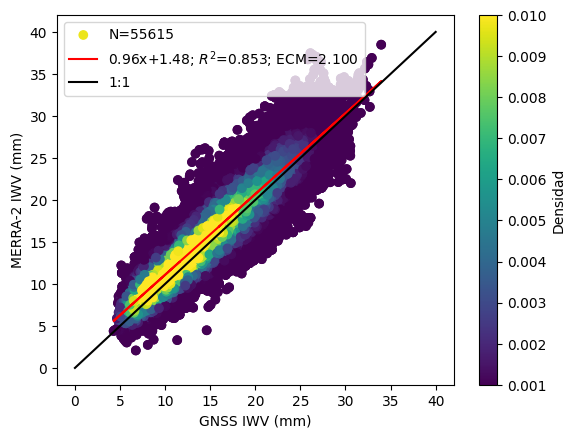

In [68]:
#Obtengo la densidad de puntos
xy_granada_GNSS = np.vstack([union_granada_MERRA['NGL_GNSS'],union_granada_MERRA['TQV']])
z_granada_GNSS = gaussian_kde(xy_granada_GNSS)(xy_granada_GNSS)

#obtengo los errores del ajuste
y_est_granada_GNSS = m_granada_GNSS*union_granada_MERRA['NGL_GNSS'] + y_0_granada_GNSS
y_err_granada_GNSS = union_granada_MERRA['NGL_GNSS'].std()*np.sqrt(1/len(union_granada_MERRA['NGL_GNSS']) + 
                                                   (union_granada_MERRA['NGL_GNSS']-union_granada_MERRA['NGL_GNSS'].mean())**2 / 
                                                    np.sum((union_granada_MERRA['NGL_GNSS']-union_granada_MERRA['NGL_GNSS'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_granada_MERRA['NGL_GNSS'], y= union_granada_MERRA['TQV'], c=z_granada_GNSS, label='N=55615')
ax.set_xlabel('GNSS IWV (mm)')
ax.set_ylabel('MERRA-2 IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_granada_MERRA['NGL_GNSS'], y_est_granada_GNSS, color='r', label=r'0.96x+1.48; $R^2$=0.853; ECM=2.100')
ax.fill_between(union_granada_MERRA['NGL_GNSS'], y_est_granada_GNSS - y_err_granada_GNSS, y_est_granada_GNSS + y_err_granada_GNSS, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_granada_MERRA['NGL_GNSS'], y=union_granada_MERRA['TQV'], c=z_granada_GNSS, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend()
'''plt.savefig('ajuste_MERRA_GNSS.pdf', format='pdf')
plt.savefig('ajuste_MERRA_GNSS.png', format='png')'''
plt.show()

Ahora RS

In [69]:
union_granada_SR.describe()

,Año,Mes,Dia,Hora,RS,NGL_GNSS,dif,RelDif
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,2014.381818,6.490909,19.300000,15.236364,15.949325,15.944636,0.004688,0.279568
std,2.475501,2.313683,7.372836,3.811925,6.075669,4.961576,3.580408,23.324614
min,2011.000000,2.000000,3.000000,8.000000,0.741417,6.610000,-15.244453,-93.907827
25%,2012.000000,5.000000,15.000000,11.000000,12.255786,12.027500,-0.263835,-1.879250
50%,2015.000000,7.000000,21.000000,16.000000,15.821366,15.740000,0.560709,3.978470
75%,2016.000000,7.000000,25.000000,19.000000,19.546618,19.345000,1.524780,9.593292
max,2020.000000,12.000000,30.000000,22.000000,30.819251,29.290000,10.455927,75.657939


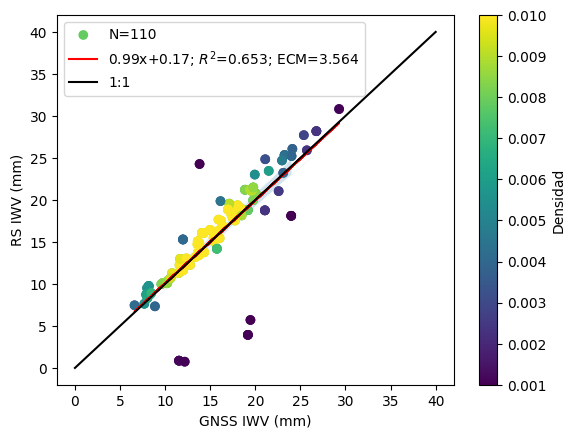

In [70]:
#Obtengo la densidad de puntos
xy_SR_GNSS = np.vstack([union_granada_SR['NGL_GNSS'],union_granada_SR['RS']])
z_SR_GNSS = gaussian_kde(xy_SR_GNSS)(xy_SR_GNSS)

#obtengo los errores del ajuste
y_est_SR_GNSS = m_SR_GNSS*union_granada_SR['NGL_GNSS'] + y_0_SR_GNSS
y_err_SR_GNSS = union_granada_SR['NGL_GNSS'].std()*np.sqrt(1/len(union_granada_SR['NGL_GNSS']) + 
                                                   (union_granada_SR['NGL_GNSS']-union_granada_SR['NGL_GNSS'].mean())**2 / 
                                                    np.sum((union_granada_SR['NGL_GNSS']-union_granada_SR['NGL_GNSS'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_granada_SR['NGL_GNSS'], y= union_granada_SR['RS'], c=z_SR_GNSS, label='N=110')
ax.set_xlabel('GNSS IWV (mm)')
ax.set_ylabel('RS IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_granada_SR['NGL_GNSS'], y_est_SR_GNSS, color='r', label=r'0.99x+0.17; $R^2$=0.653; ECM=3.564')
ax.fill_between(union_granada_SR['NGL_GNSS'], y_est_SR_GNSS - y_err_SR_GNSS, y_est_SR_GNSS + y_err_SR_GNSS, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_granada_SR['NGL_GNSS'], y=union_granada_SR['RS'], c=z_SR_GNSS, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend(loc='upper left')
'''plt.savefig('Ajuste GNSS y RS.pdf', format='pdf')
plt.savefig('Ajuste GNSS y RS.png', format='png')'''
plt.show()

In [71]:
union_SP_SR.describe()

,Año,Mes,Dia,Hora,RS,SP,NGL_GNSS,dif
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,2014.750000,6.694444,20.055556,13.416667,16.304155,16.208487,16.579444,-0.370958
std,2.600824,2.053839,7.281854,3.254667,6.338571,4.916864,5.240770,1.336024
min,2011.000000,3.000000,3.000000,8.000000,0.862234,6.211110,7.900000,-2.658890
25%,2012.000000,5.000000,15.750000,11.000000,13.327568,12.688474,13.305000,-1.513434
50%,2016.000000,7.000000,22.500000,12.500000,15.823872,15.467874,15.890000,-0.338911
75%,2016.000000,7.000000,25.250000,16.000000,19.850003,19.335129,19.657500,0.678409
max,2020.000000,11.000000,30.000000,19.000000,30.819251,26.680255,29.290000,1.729500


In [72]:
union_MWR_SR.describe()

,Año,Mes,Dia,Hora,RS,MWR,NGL_GNSS,dif
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,2014.202703,6.391892,18.932432,16.121622,15.776704,17.570980,15.635811,1.935169
std,2.409910,2.437254,7.438020,3.767026,5.980160,5.228364,4.826320,1.102025
min,2011.000000,2.000000,3.000000,8.000000,0.741417,8.104593,6.610000,0.028136
25%,2012.000000,5.000000,15.000000,13.250000,11.371526,13.399734,11.980000,1.313279
50%,2014.000000,6.500000,21.000000,16.000000,15.821366,17.479337,15.650000,1.699293
75%,2016.000000,7.000000,24.750000,19.000000,19.504280,20.916067,19.177500,2.410878
max,2020.000000,12.000000,30.000000,22.000000,28.184563,29.252336,26.770000,6.152336


In [73]:
union_SR_MERRA.describe()

,Año,Mes,Dia,Hora,TQV,RS
count,137.000000,137.00000,137.000000,137.000000,137.000000,137.000000
mean,2014.978102,6.80292,16.751825,16.131387,17.254191,16.640841
std,2.983945,2.63137,7.952784,3.649773,6.139863,6.628314
min,2011.000000,2.00000,1.000000,8.000000,5.911748,0.334273
25%,2012.000000,5.00000,10.000000,14.000000,12.321397,11.966603
50%,2015.000000,7.00000,17.000000,16.000000,17.331636,16.568012
75%,2016.000000,9.00000,24.000000,19.000000,20.854237,21.208625
max,2021.000000,12.00000,30.000000,22.000000,31.689505,33.229389


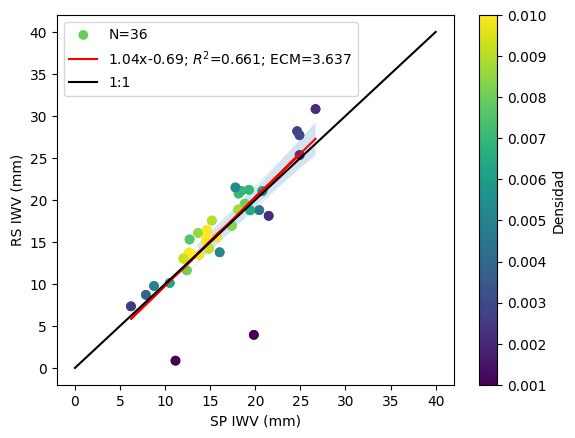

In [74]:
#Obtengo la densidad de puntos
xy_SR_SP = np.vstack([union_SP_SR['SP'],union_SP_SR['RS']])
z_SR_SP = gaussian_kde(xy_SR_SP)(xy_SR_SP)

#obtengo los errores del ajuste
y_est_SR_SP = m_SR_SP*union_SP_SR['SP'] + y_0_SR_SP
y_err_SR_SP = union_SP_SR['SP'].std()*np.sqrt(1/len(union_SP_SR['SP']) + 
                                                   (union_SP_SR['SP']-union_SP_SR['SP'].mean())**2 / 
                                                    np.sum((union_SP_SR['SP']-union_SP_SR['SP'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_SP_SR['SP'], y= union_SP_SR['RS'], c=z_SR_SP, label='N=36')
ax.set_xlabel('SP IWV (mm)')
ax.set_ylabel('RS IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_SP_SR['SP'], y_est_SR_SP, color='r', label=r'1.04x-0.69; $R^2$=0.661; ECM=3.637')
ax.fill_between(union_SP_SR['SP'], y_est_SR_SP - y_err_SR_SP, y_est_SR_SP + y_err_SR_SP, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_SP_SR['SP'], y=union_SP_SR['RS'], c=z_SR_SP, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend(loc='upper left')
'''plt.savefig('Ajuste SP y RS.pdf', format='pdf')
plt.savefig('Ajuste SP y RS.png', format='png')'''
plt.show()

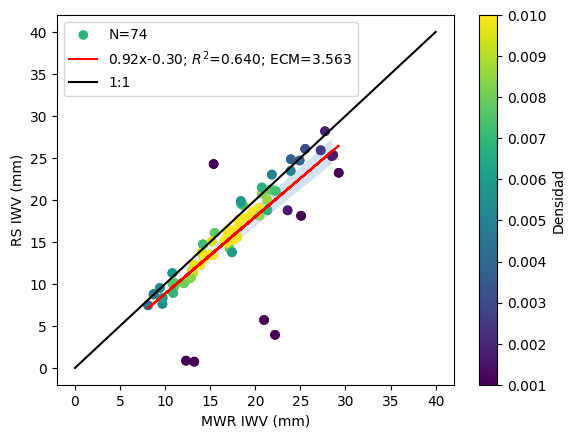

In [75]:
#Obtengo la densidad de puntos
xy_SR_MWR = np.vstack([union_MWR_SR['MWR'],union_MWR_SR['RS']])
z_SR_MWR = gaussian_kde(xy_SR_MWR)(xy_SR_MWR)

#obtengo los errores del ajuste
y_est_SR_MWR = m_SR_MWR*union_MWR_SR['MWR'] + y_0_SR_MWR
y_err_SR_MWR = union_MWR_SR['MWR'].std()*np.sqrt(1/len(union_MWR_SR['MWR']) + 
                                                   (union_MWR_SR['MWR']-union_MWR_SR['MWR'].mean())**2 / 
                                                    np.sum((union_MWR_SR['MWR']-union_MWR_SR['MWR'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_MWR_SR['MWR'], y= union_MWR_SR['RS'], c=z_SR_MWR, label='N=74')
ax.set_xlabel('MWR IWV (mm)')
ax.set_ylabel('RS IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_MWR_SR['MWR'], y_est_SR_MWR, color='r', label=r'0.92x-0.30; $R^2$=0.640; ECM=3.563')
ax.fill_between(union_MWR_SR['MWR'], y_est_SR_MWR - y_err_SR_MWR, y_est_SR_MWR + y_err_SR_MWR, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_MWR_SR['MWR'], y=union_MWR_SR['RS'], c=z_SR_MWR, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend(loc='upper left')
'''plt.savefig('Ajuste MWR y RS.pdf', format='pdf')
plt.savefig('Ajuste MWR y RS.png', format='png')'''
plt.show()

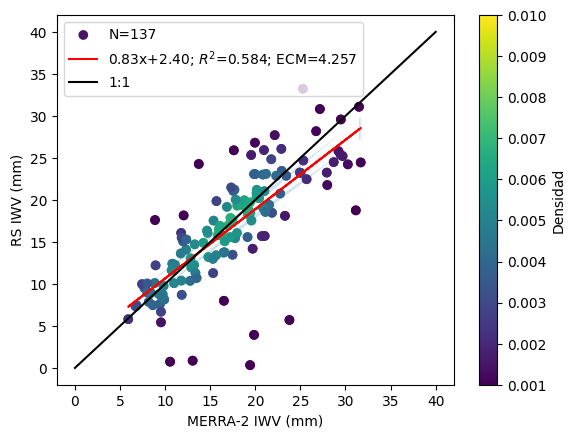

In [76]:
#Obtengo la densidad de puntos
xy_SR_MERRA = np.vstack([union_SR_MERRA['TQV'],union_SR_MERRA['RS']])
z_SR_MERRA = gaussian_kde(xy_SR_MERRA)(xy_SR_MERRA)

#obtengo los errores del ajuste
y_est_SR_MERRA = m_SR_MERRA*union_SR_MERRA['TQV'] + y_0_SR_MERRA
y_err_SR_MERRA = union_SR_MERRA['TQV'].std()*np.sqrt(1/len(union_SR_MERRA['TQV']) + 
                                                   (union_SR_MERRA['TQV']-union_SR_MERRA['TQV'].mean())**2 / 
                                                    np.sum((union_SR_MERRA['TQV']-union_SR_MERRA['TQV'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_SR_MERRA['TQV'], y= union_SR_MERRA['RS'], c=z_SR_MERRA, label='N=137')
ax.set_xlabel('MERRA-2 IWV (mm)')
ax.set_ylabel('RS IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_SR_MERRA['TQV'], y_est_SR_MERRA, color='r', label=r'0.83x+2.40; $R^2$=0.584; ECM=4.257')
ax.fill_between(union_SR_MERRA['TQV'], y_est_SR_MERRA - y_err_SR_MERRA, y_est_SR_MERRA + y_err_SR_MERRA, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_SR_MERRA['TQV'], y=union_SR_MERRA['RS'], c=z_SR_MERRA, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend(loc='upper left')
'''plt.savefig('Ajuste MERRA-2 y RS.pdf', format='pdf')
plt.savefig('Ajuste MERRA-2 y RS.png', format='png')'''
plt.show()

////////////////////////////////////////// Esta no está bien creo ///////////////////////////////////////////////

Pongo ahora RS en el eje x, esto conlleva rehacer todas las gráficas

In [77]:
#Usando numpy ahora con SR en el eje x

ajuste_granada_SR_np_ = np.polyfit(union_granada_SR['RS'], union_granada_SR['NGL_GNSS'], deg=1)

m_SR_GNSS_, y_0_SR_GNSS_ = ajuste_granada_SR_np_

#m_SR_GNSS = 0.98938113
#y_0_SR_GNSS = 0.1740024

print(ajuste_granada_SR_np_)

[0.65980382 5.42121101]


In [78]:
#Usando numpy ahora con SR en el eje x

ajuste_SP_SR_np_ = np.polyfit(union_SP_SR['RS'], union_SP_SR['SP'], deg=1)

m_SR_SP_, y_0_SR_SP_ = ajuste_SP_SR_np_

#m_SR_GNSS = 0.98938113
#y_0_SR_GNSS = 0.1740024

print(ajuste_SP_SR_np_)

[0.63082465 5.92342362]


In [79]:
#Usando numpy ahora con SR en el eje x

ajuste_MWR_SR_np_ = np.polyfit(union_MWR_SR['RS'], union_MWR_SR['MWR'], deg=1)

m_SR_MWR_, y_0_SR_MWR_ = ajuste_MWR_SR_np_

#m_SR_GNSS = 0.98938113
#y_0_SR_GNSS = 0.1740024

print(ajuste_MWR_SR_np_)

[0.69948564 6.53540146]


In [80]:
#Usando numpy ahora con SR en el eje x

ajuste_MERRA_SR_np_ = np.polyfit(union_SR_MERRA['RS'], union_SR_MERRA['TQV'], deg=1)

m_SR_MERRA_, y_0_SR_MERRA_ = ajuste_MERRA_SR_np_

#m_SR_GNSS = 0.98938113
#y_0_SR_GNSS = 0.1740024

print(ajuste_MERRA_SR_np_)

[0.70818427 5.46940951]


In [81]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_granada_SR_sk_ = linear_model.LinearRegression()
ajuste_granada_SR_sk_.fit(X = pd.DataFrame(union_granada_SR['RS']),
                       y = union_granada_SR['NGL_GNSS'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SR_GNSS_ = ajuste_granada_SR_sk_.score(X = pd.DataFrame(union_granada_SR['RS']),
                       y = union_granada_SR['NGL_GNSS'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SR_GNSS_ = ajuste_granada_SR_sk_.predict(X = pd.DataFrame(union_granada_SR['RS']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SR_GNSS_ = mean_squared_error(prediccion_SR_GNSS_, union_granada_SR['NGL_GNSS'])**0.5


print('Pendiente: ', m_SR_GNSS_ , '\n', 'R^2: ', R_2_SR_GNSS_, '\n', 'rmse: ', RMSE_SR_GNSS_)

Pendiente:  0.6598038186062255 
 R^2:  0.6527974471161806 
 rmse:  2.9102348638893956


In [82]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_SP_SR_sk_ = linear_model.LinearRegression()
ajuste_SP_SR_sk_.fit(X = pd.DataFrame(union_SP_SR['RS']),
                       y = union_SP_SR['SP'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SR_SP_ = ajuste_SP_SR_sk_.score(X = pd.DataFrame(union_SP_SR['RS']),
                       y = union_SP_SR['SP'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SR_SP_ = ajuste_SP_SR_sk_.predict(X = pd.DataFrame(union_SP_SR['RS']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SR_SP_ = mean_squared_error(prediccion_SR_SP_, union_SP_SR['SP'])**0.5


print('Pendiente: ', m_SR_SP_ , '\n', 'R^2: ', R_2_SR_SP_, '\n', 'rmse: ', RMSE_SR_SP_)

Pendiente:  0.6308246510860487 
 R^2:  0.6613383027436863 
 rmse:  2.821330681246797


In [83]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_MWR_SR_sk_ = linear_model.LinearRegression()
ajuste_MWR_SR_sk_.fit(X = pd.DataFrame(union_MWR_SR['RS']),
                       y = union_MWR_SR['MWR'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SR_MWR_ = ajuste_MWR_SR_sk_.score(X = pd.DataFrame(union_MWR_SR['RS']),
                       y = union_MWR_SR['MWR'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SR_MWR_ = ajuste_MWR_SR_sk_.predict(X = pd.DataFrame(union_MWR_SR['RS']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SR_MWR_ = mean_squared_error(prediccion_SR_MWR_, union_MWR_SR['MWR'])**0.5


print('Pendiente: ', m_SR_MWR_ , '\n', 'R^2: ', R_2_SR_MWR_, '\n', 'rmse: ', RMSE_SR_MWR_)

Pendiente:  0.6994856446123204 
 R^2:  0.6401054838905366 
 rmse:  3.115294007204462


In [84]:
#Usando sklearn

#Õbtengo el ajuste
ajuste_MERRA_SR_sk_ = linear_model.LinearRegression()
ajuste_MERRA_SR_sk_.fit(X = pd.DataFrame(union_SR_MERRA['RS']),
                       y = union_SR_MERRA['TQV'])

#Obtengo la pendiente
#y_0_SP = ajuste_SP_MERRA_sk.intercept_

#Obtengo el R^2
R_2_SR_MERRA_ = ajuste_MERRA_SR_sk_.score(X = pd.DataFrame(union_SR_MERRA['RS']),
                       y = union_SR_MERRA['TQV'])

#Obtengo cuanto difieren los datos obrenidos con el ajuste y los reales
prediccion_SR_MERRA_ = ajuste_MERRA_SR_sk_.predict(X = pd.DataFrame(union_SR_MERRA['RS']))

#residuos_SP = union_SP_MERRA['SP'] - prediccion_SP

#Obtengo el RMSE
def rmse(predicted, target):
    return(np.sqrt(np.mean((target-predicted)**2)))

#RMSE_SP = rmse(prediccion_SP, union_SP_MERRA['SP'])
RMSE_SR_MERRA_ = mean_squared_error(prediccion_SR_MERRA_, union_SR_MERRA['TQV'])**0.5


print('Pendiente: ', m_SR_MERRA_ , '\n', 'R^2: ', R_2_SR_MERRA_, '\n', 'rmse: ', RMSE_SR_MERRA_)

Pendiente:  0.7081842665583409 
 R^2:  0.5844956937824433 
 rmse:  3.9432620575227806


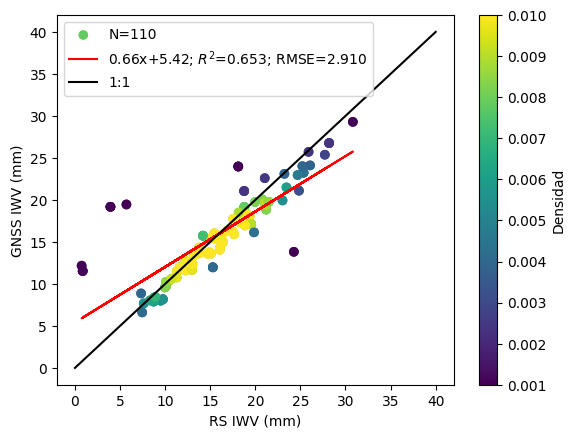

In [90]:
#Obtengo la densidad de puntos
xy_SR_GNSS_ = np.vstack([union_granada_SR['RS'],union_granada_SR['NGL_GNSS']])
z_SR_GNSS_ = gaussian_kde(xy_SR_GNSS_)(xy_SR_GNSS_)

#obtengo los errores del ajuste
y_est_SR_GNSS_ = m_SR_GNSS_*union_granada_SR['RS'] + y_0_SR_GNSS_
y_err_SR_GNSS_ = union_granada_SR['RS'].std()*np.sqrt(1/len(union_granada_SR['RS']) + 
                                                   (union_granada_SR['RS']-union_granada_SR['RS'].mean())**2 / 
                                                    np.sum((union_granada_SR['RS']-union_granada_SR['RS'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_granada_SR['RS'], y= union_granada_SR['NGL_GNSS'], c=z_SR_GNSS, label='N=110')
ax.set_xlabel('RS IWV (mm)')
ax.set_ylabel('GNSS IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_granada_SR['RS'], y_est_SR_GNSS_, color='r', label=r'0.66x+5.42; $R^2$=0.653; RMSE=2.910')
#ax.fill_between(union_granada_SR['RS'], y_est_SR_GNSS_ - y_err_SR_GNSS_, y_est_SR_GNSS_ + y_err_SR_GNSS_, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_granada_SR['RS'], y=union_granada_SR['NGL_GNSS'], c=z_SR_GNSS, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend(loc='upper left')
plt.savefig('Ajuste GNSS y RS en x.pdf', format='pdf')
plt.savefig('Ajuste GNSS y RS en x.png', format='png')
plt.show()

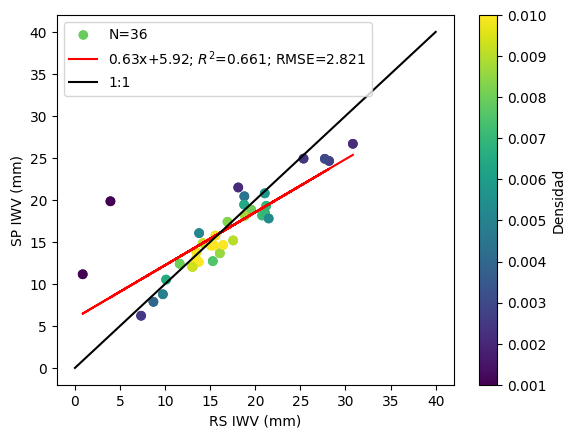

In [91]:
#Obtengo la densidad de puntos
xy_SR_SP_ = np.vstack([union_SP_SR['RS'],union_SP_SR['SP']])
z_SR_SP_ = gaussian_kde(xy_SR_SP_)(xy_SR_SP_)

#obtengo los errores del ajuste
y_est_SR_SP_ = m_SR_SP_*union_SP_SR['RS'] + y_0_SR_SP_
y_err_SR_SP_ = union_SP_SR['RS'].std()*np.sqrt(1/len(union_SP_SR['RS']) + 
                                                   (union_SP_SR['RS']-union_SP_SR['RS'].mean())**2 / 
                                                    np.sum((union_SP_SR['RS']-union_SP_SR['RS'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_SP_SR['RS'], y= union_SP_SR['SP'], c=z_SR_SP_, label='N=36')
ax.set_xlabel('RS IWV (mm)')
ax.set_ylabel('SP IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_SP_SR['RS'], y_est_SR_SP_, color='r', label=r'0.63x+5.92; $R^2$=0.661; RMSE=2.821')
#ax.fill_between(union_SP_SR['RS'], y_est_SR_SP_ - y_err_SR_SP_, y_est_SR_SP_ + y_err_SR_SP_, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_SP_SR['RS'], y=union_SP_SR['SP'], c=z_SR_SP_, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend(loc='upper left')
plt.savefig('Ajuste SP y RS en x.pdf', format='pdf')
plt.savefig('Ajuste SP y RS en x.png', format='png')
plt.show()

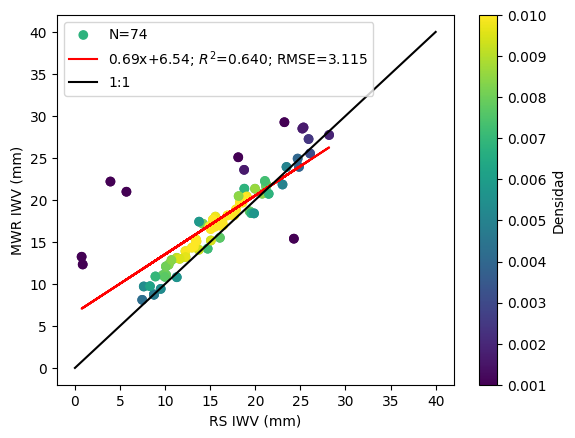

In [92]:
#Obtengo la densidad de puntos
xy_SR_MWR_ = np.vstack([union_MWR_SR['RS'],union_MWR_SR['MWR']])
z_SR_MWR_ = gaussian_kde(xy_SR_MWR_)(xy_SR_MWR_)

#obtengo los errores del ajuste
y_est_SR_MWR_ = m_SR_MWR_*union_MWR_SR['RS'] + y_0_SR_MWR_
y_err_SR_MWR_ = union_MWR_SR['RS'].std()*np.sqrt(1/len(union_MWR_SR['RS']) + 
                                                   (union_MWR_SR['RS']-union_MWR_SR['RS'].mean())**2 / 
                                                    np.sum((union_MWR_SR['RS']-union_MWR_SR['RS'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_MWR_SR['RS'], y= union_MWR_SR['MWR'], c=z_SR_MWR_, label='N=74')
ax.set_xlabel('RS IWV (mm)')
ax.set_ylabel('MWR IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_MWR_SR['RS'], y_est_SR_MWR_, color='r', label=r'0.69x+6.54; $R^2$=0.640; RMSE=3.115')
#ax.fill_between(union_MWR_SR['RS'], y_est_SR_MWR_ - y_err_SR_MWR_, y_est_SR_MWR_ + y_err_SR_MWR_, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_MWR_SR['RS'], y=union_MWR_SR['MWR'], c=z_SR_MWR_, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend(loc='upper left')
plt.savefig('Ajuste MWR y RS en x.pdf', format='pdf')
plt.savefig('Ajuste MWR y RS en x.png', format='png')

plt.show()

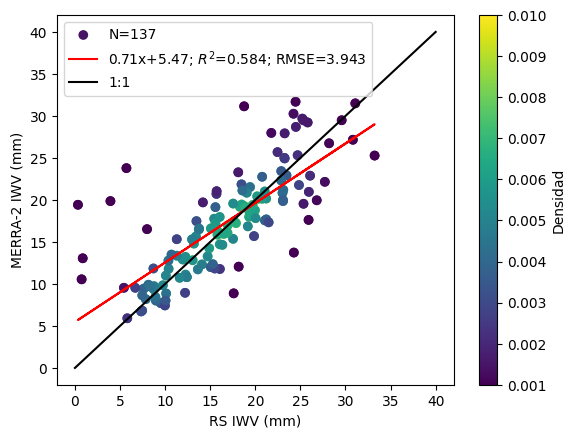

In [93]:
#Obtengo la densidad de puntos
xy_SR_MERRA_ = np.vstack([union_SR_MERRA['RS'],union_SR_MERRA['TQV']])
z_SR_MERRA_ = gaussian_kde(xy_SR_MERRA_)(xy_SR_MERRA_)

#obtengo los errores del ajuste
y_est_SR_MERRA_ = m_SR_MERRA_*union_SR_MERRA['RS'] + y_0_SR_MERRA_
y_err_SR_MERRA_ = union_SR_MERRA['RS'].std()*np.sqrt(1/len(union_SR_MERRA['RS']) + 
                                                   (union_SR_MERRA['RS']-union_SR_MERRA['RS'].mean())**2 / 
                                                    np.sum((union_SR_MERRA['RS']-union_SR_MERRA['RS'].mean())**2))

fig, ax=plt.subplots()

#Muestro los puntos
ax.scatter(x = union_SR_MERRA['RS'], y= union_SR_MERRA['TQV'], c=z_SR_MERRA_, label='N=137')
ax.set_xlabel('RS IWV (mm)')
ax.set_ylabel('MERRA-2 IWV (mm)')

#Muestro la línea de ajuste
ax.plot(union_SR_MERRA['RS'], y_est_SR_MERRA_, color='r', label=r'0.71x+5.47; $R^2$=0.584; RMSE=3.943')
#ax.fill_between(union_SR_MERRA['RS'], y_est_SR_MERRA_ - y_err_SR_MERRA_, y_est_SR_MERRA_ + y_err_SR_MERRA_, alpha=0.2)

#Muestro la línea teórica 1:1
x1 = [0, 40]
ax.plot(x1, x1, color='black', label='1:1')

#Obtengo la leyenda de la densidad de puntos
sc = ax.scatter(x=union_SR_MERRA['RS'], y=union_SR_MERRA['TQV'], c=z_SR_MERRA_, vmin=0.001, vmax=0.01)
cbar = fig.colorbar(sc)
cbar.set_label('Densidad')

plt.legend(loc='upper left')
plt.savefig('Ajuste MERRA-2 y RS en x.pdf', format='pdf')
plt.savefig('Ajuste MERRA-2 y RS en x.png', format='png')
plt.show()

In [89]:
A

NameError: name 'A' is not defined

Mostramos los datos estadísticos interesantes de las gráficas

In [ ]:
valores_estadisticos_graficas = [['Pendiente', m_SP, m_MWR],
                                 ['T.Independietne', y_0_SP, y_0_MWR],
                        ['R^2', R_2_SP, R_2_MWR],
                        ['RMSE', RMSE_SP, RMSE_MWR]]

estadistica_graficas = pd.DataFrame(valores_estadisticos_graficas, columns=['Estadística', 'SP', 'MWR'])

estadistica_graficas

,Estadística,SP,MWR
0,Pendiente,0.845142,0.894939
1,T.Independietne,1.396272,2.639207
2,R^2,0.794674,0.832690
3,RMSE,2.358592,2.193953


Obtenemos ahora la evolución temporal de cada instrumento, para ello obtenemos la media de diaria de los datos de vapor de agua integrado medido por cada instrumento y ploteamos en función del tiempo. Usamos todos los datos posibles para cada instrumento de medida

In [ ]:
#Media diaria de GGL_GNSS
diario_granada = f_granada.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)
diario_granada.drop(columns=['Hora'], axis=1)

diario_granada = diario_granada.reset_index()

def combine_columns(row):
    return str(row['Año']) + str(row['Mes']) + str(row['Dia'])

diario_granada['Combined'] = diario_granada.apply(combine_columns, axis=1)

diario_granada['Combined'] = pd.to_datetime(diario_granada['Combined'], format='%Y.0%m.0%d.0')

diario_granada

,Año,Mes,Dia,Hora,NGL_GNSS,Combined
0,2010,5,17,12.000000,9.080000,2010-05-17
1,2010,5,21,16.500000,14.306667,2010-05-21
2,2010,5,22,12.500000,15.822143,2010-05-22
3,2010,5,23,12.000000,16.052308,2010-05-23
4,2010,5,24,11.833333,13.681667,2010-05-24
...,...,...,...,...,...,...
2941,2021,6,17,14.500000,22.606250,2021-06-17
2942,2021,6,18,10.600000,19.474000,2021-06-18
2943,2021,6,20,14.500000,18.643000,2021-06-20
2944,2021,6,21,12.500000,10.331429,2021-06-21


In [ ]:
#Media diaria de SP
diario_SP = f_SP.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)
diario_SP.drop(columns=['Hora'], axis=1)

diario_SP = diario_SP.reset_index()

diario_SP['Combined'] = diario_SP.apply(combine_columns, axis=1)

diario_SP['Combined'] = pd.to_datetime(diario_SP['Combined'], format='%Y.0%m.0%d.0')

diario_SP

,Año,Mes,Dia,Hora,SP,NGL_GNSS,dif,Combined
0,2010,5,17,12.000000,9.607505,9.080000,0.527505,2010-05-17
1,2010,5,21,16.500000,14.060439,14.306667,-0.246227,2010-05-21
2,2010,5,22,12.500000,14.789164,15.822143,-1.032979,2010-05-22
3,2010,5,23,12.000000,15.045157,16.052308,-1.007150,2010-05-23
4,2010,5,24,11.833333,13.470399,13.681667,-0.211268,2010-05-24
...,...,...,...,...,...,...,...,...
2430,2021,6,17,14.500000,21.006725,22.606250,-1.599525,2021-06-17
2431,2021,6,18,10.600000,18.684299,19.474000,-0.789701,2021-06-18
2432,2021,6,20,14.500000,17.159948,18.643000,-1.483052,2021-06-20
2433,2021,6,21,12.500000,10.391561,10.331429,0.060132,2021-06-21


In [ ]:
#Media diaria de MWR
diario_MWR = f_MWR.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)
diario_MWR.drop(columns=['Hora'], axis=1)

diario_MWR = diario_MWR.reset_index()

diario_MWR['Combined'] = diario_MWR.apply(combine_columns, axis=1)

diario_MWR['Combined'] = pd.to_datetime(diario_MWR['Combined'], format='%Y.0%m.0%d.0')

diario_MWR

,Año,Mes,Dia,Hora,MWR,NGL_GNSS,dif,Combined
0,2011,1,2,13.400000,11.365447,9.980500,1.384947,2011-01-02
1,2011,1,3,8.500000,8.823134,7.302222,1.520912,2011-01-03
2,2011,1,4,10.888889,12.218899,10.508333,1.710566,2011-01-04
3,2011,1,10,11.500000,10.466260,9.272500,1.193760,2011-01-10
4,2011,1,11,11.500000,13.612292,12.202917,1.409375,2011-01-11
...,...,...,...,...,...,...,...,...
1875,2020,12,16,12.000000,10.943662,10.190435,0.753227,2020-12-16
1876,2020,12,18,11.500000,14.037049,13.330833,0.706216,2020-12-18
1877,2020,12,22,13.300000,14.172398,13.650000,0.522398,2020-12-22
1878,2020,12,23,15.500000,12.228167,11.894375,0.333792,2020-12-23


In [ ]:
#Media diaria de MERRA
diario_MERRA = f_MERRA.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)
diario_MERRA.drop(columns=['Hora'], axis=1)

diario_MERRA = diario_MERRA.reset_index()

diario_MERRA['Combined'] = diario_MERRA.apply(combine_columns, axis=1)

diario_MERRA['Combined'] = pd.to_datetime(diario_MERRA['Combined'], format='%Y.0%m.0%d.0')

diario_MERRA

,Año,Mes,Dia,Hora,TQV,Combined
0,2011,1,1,11.5,13.313735,2011-01-01
1,2011,1,2,11.5,11.501446,2011-01-02
2,2011,1,4,11.5,12.514850,2011-01-04
3,2011,1,5,11.5,15.126759,2011-01-05
4,2011,1,6,11.5,16.032806,2011-01-06
...,...,...,...,...,...,...
4013,2021,12,28,11.5,11.280077,2021-12-28
4014,2021,12,29,11.5,10.239287,2021-12-29
4015,2021,12,30,11.5,8.029115,2021-12-30
4016,2021,12,31,11.5,7.937208,2021-12-31


Ahora con RS

In [ ]:
#Media diaria de MERRA
diario_SR = f_SR.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)
diario_SR.drop(columns=['Hora'], axis=1)

diario_SR = diario_SR.reset_index()

diario_SR['Combined'] = diario_SR.apply(combine_columns, axis=1)

diario_SR['Combined'] = pd.to_datetime(diario_SR['Combined'], format='%Y.0%m.0%d.0')

diario_SR

,Año,Mes,Dia,Hora,RS,Combined
0,2011,7,1,11.0,31.087096,2011-07-01
1,2011,7,18,16.0,15.079785,2011-07-18
2,2011,7,22,15.0,27.130321,2011-07-22
3,2011,7,25,15.5,21.888156,2011-07-25
4,2011,7,28,15.5,23.026116,2011-07-28
...,...,...,...,...,...,...
119,2023,1,31,12.0,3.706673,2023-01-31
120,2023,2,2,13.0,7.153267,2023-02-02
121,2023,3,3,11.0,4.674919,2023-03-03
122,2023,3,14,10.0,8.461033,2023-03-14


Obtenemos lo mismo pero para los valores donde coinciden temporalmente todos los instrumentos

In [ ]:
#Media diaria de MERRA
union_granada_MERRA_diario = union_granada_MERRA.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)

union_granada_MERRA_diario = union_granada_MERRA_diario.reset_index()

union_granada_MERRA_diario['Combined'] = union_granada_MERRA_diario.apply(combine_columns, axis=1)

union_granada_MERRA_diario['Combined'] = pd.to_datetime(union_granada_MERRA_diario['Combined'], format='%Y.0%m.0%d.0')

union_granada_MERRA_diario

,Año,Mes,Dia,Hora,TQV,NGL_GNSS,dif,RelDif,Combined
0,2011,1,2,13.409091,11.378600,9.958636,1.419964,14.711396,2011-01-02
1,2011,1,4,11.384615,12.690944,10.652308,2.038636,19.402178,2011-01-04
2,2011,1,10,11.838710,8.206497,8.697742,-0.491245,-5.215315,2011-01-10
3,2011,1,11,11.500000,12.369410,12.202917,0.166493,1.519540,2011-01-11
4,2011,1,12,13.680000,11.670427,10.678000,0.992427,9.575744,2011-01-12
...,...,...,...,...,...,...,...,...,...
2773,2021,6,17,14.500000,21.599706,22.606250,-1.006544,-3.655602,2021-06-17
2774,2021,6,18,10.600000,25.630948,19.474000,6.156948,31.694026,2021-06-18
2775,2021,6,20,14.500000,18.540976,18.643000,-0.102024,-0.331323,2021-06-20
2776,2021,6,21,12.500000,11.309751,10.331429,0.978322,10.066761,2021-06-21


Ahora con RS

In [ ]:
#Media diaria de MERRA
union_SR_MERRA_diario = union_SR_MERRA.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)

union_SR_MERRA_diario = union_SR_MERRA_diario.reset_index()

union_SR_MERRA_diario['Combined'] = union_SR_MERRA_diario.apply(combine_columns, axis=1)

union_SR_MERRA_diario['Combined'] = pd.to_datetime(union_SR_MERRA_diario['Combined'], format='%Y.0%m.0%d.0')

union_SR_MERRA_diario

,Año,Mes,Dia,Hora,TQV,RS,Combined
0,2011,7,1,11.0,31.498268,31.087096,2011-07-01
1,2011,7,18,16.0,12.049473,15.079785,2011-07-18
2,2011,7,22,15.0,24.814966,27.130321,2011-07-22
3,2011,7,25,15.5,21.794935,21.888156,2011-07-25
4,2011,7,28,15.5,20.966311,23.026116,2011-07-28
...,...,...,...,...,...,...,...
105,2021,9,24,10.0,31.689505,24.464121,2021-09-24
106,2021,11,3,12.0,8.188169,7.854378,2021-11-03
107,2021,11,11,12.0,8.024032,10.049595,2021-11-11
108,2021,12,2,17.0,5.911748,5.805855,2021-12-02


Obtengo la diferencia y diferencia relativa para SP y MWR

In [ ]:
#union_SP_MERRA.insert(6, 'dif', union_SP_MERRA['SP'] - union_SP_MERRA['NGL_GNSS'])

In [ ]:
union_SP_MERRA.insert(7, 'RelDif', union_SP_MERRA['dif']/(union_SP_MERRA['NGL_GNSS']/100))

In [ ]:
#union_MWR_MERRA.insert(6, 'dif', union_MWR_MERRA['MWR'] - union_MWR_MERRA['NGL_GNSS'])

In [ ]:
union_MWR_MERRA.insert(7, 'RelDif', union_MWR_MERRA['dif']/(union_MWR_MERRA['NGL_GNSS']/100))

In [ ]:
union_SP_MERRA

,Año,Mes,Dia,Hora,TQV,SP,NGL_GNSS,RelDif,dif
0,2011,1,2,12,11.643253,10.662090,10.39,2.618768,0.272090
1,2011,1,2,15,11.800663,9.762030,9.09,7.393069,0.672030
2,2011,1,4,9,12.286804,10.744580,10.79,-0.420945,-0.045420
3,2011,1,4,10,12.649545,10.763927,10.77,-0.056391,-0.006073
4,2011,1,4,11,13.214520,10.157374,10.41,-2.426763,-0.252626
...,...,...,...,...,...,...,...,...,...
19357,2021,6,22,14,15.329567,14.417866,14.41,0.054586,0.007866
19358,2021,6,22,15,15.806153,14.328368,14.53,-1.387694,-0.201632
19359,2021,6,22,16,16.110914,13.839899,15.17,-8.767967,-1.330101
19360,2021,6,22,17,16.251667,15.152969,15.72,-3.607067,-0.567031


In [ ]:
union_MWR_MERRA

,Año,Mes,Dia,Hora,TQV,MWR,NGL_GNSS,RelDif,dif
0,2011,1,2,3,11.949394,12.575733,11.58,8.598727,0.995733
1,2011,1,2,4,11.877585,12.187981,11.06,10.198739,1.127981
2,2011,1,2,6,11.738265,12.052036,10.73,12.320930,1.322036
3,2011,1,2,7,11.692534,12.164294,10.72,13.472894,1.444294
4,2011,1,2,8,11.638454,12.072080,10.66,13.246534,1.412080
...,...,...,...,...,...,...,...,...,...
36248,2020,9,30,19,16.990911,18.722515,17.04,9.873912,1.682515
36249,2020,9,30,20,16.707552,17.795550,17.13,3.885287,0.665550
36250,2020,9,30,21,16.285463,17.865958,17.04,4.847173,0.825958
36251,2020,9,30,22,15.874342,16.471782,16.90,-2.533832,-0.428218


Obtengo ahora la media diaria donde estos instrumentos coinciden temporalmente con MERRA-2

In [ ]:
union_SP_MERRA_diario = union_SP_MERRA.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)

union_SP_MERRA_diario = union_SP_MERRA_diario.reset_index()

union_SP_MERRA_diario['Combined'] = union_SP_MERRA_diario.apply(combine_columns, axis=1)

union_SP_MERRA_diario['Combined'] = pd.to_datetime(union_SP_MERRA_diario['Combined'], format='%Y.0%m.0%d.0')

union_SP_MERRA_diario

,Año,Mes,Dia,Hora,TQV,SP,NGL_GNSS,RelDif,dif,Combined
0,2011,1,2,13.500000,11.721958,10.212060,9.740000,5.005919,0.472060,2011-01-02
1,2011,1,4,12.500000,13.575234,10.954127,10.976250,-0.193649,-0.022123,2011-01-04
2,2011,1,10,13.000000,6.590003,6.949276,6.727143,3.928991,0.222133,2011-01-10
3,2011,1,12,12.666667,12.087435,11.016920,11.016667,0.058253,0.000253,2011-01-12
4,2011,1,13,12.000000,9.475588,8.010348,7.574444,5.836449,0.435904,2011-01-13
...,...,...,...,...,...,...,...,...,...,...
2262,2021,6,17,14.500000,21.599706,21.006725,22.606250,-6.879416,-1.599525,2021-06-17
2263,2021,6,18,10.600000,25.630948,18.684299,19.474000,-4.049045,-0.789701,2021-06-18
2264,2021,6,20,14.500000,18.540976,17.159948,18.643000,-7.996793,-1.483052,2021-06-20
2265,2021,6,21,12.500000,11.309751,10.391561,10.331429,0.363911,0.060132,2021-06-21


In [ ]:
union_MWR_MERRA_diario = union_MWR_MERRA.groupby(['Año', 'Mes', 'Dia']).mean()

#Borro la columna de la hora (No se por qué no se borra)

union_MWR_MERRA_diario = union_MWR_MERRA_diario.reset_index()

union_MWR_MERRA_diario['Combined'] = union_MWR_MERRA_diario.apply(combine_columns, axis=1)

union_MWR_MERRA_diario['Combined'] = pd.to_datetime(union_MWR_MERRA_diario['Combined'], format='%Y.0%m.0%d.0')

union_MWR_MERRA_diario

,Año,Mes,Dia,Hora,TQV,MWR,NGL_GNSS,RelDif,dif,Combined
0,2011,1,2,13.400000,11.344264,11.365447,9.980500,14.123879,1.384947,2011-01-02
1,2011,1,4,10.888889,12.297926,12.218899,10.508333,16.353820,1.710566,2011-01-04
2,2011,1,10,11.500000,8.677974,10.466260,9.272500,14.027211,1.193760,2011-01-10
3,2011,1,11,11.500000,12.369410,13.612292,12.202917,11.644594,1.409375,2011-01-11
4,2011,1,12,14.000000,11.538741,12.519730,10.571053,18.485501,1.948677,2011-01-12
...,...,...,...,...,...,...,...,...,...,...
1874,2020,12,16,12.000000,13.285148,10.943662,10.190435,7.130330,0.753227,2020-12-16
1875,2020,12,18,11.500000,13.521006,14.037049,13.330833,5.351214,0.706216,2020-12-18
1876,2020,12,22,13.300000,16.406031,14.172398,13.650000,3.827079,0.522398,2020-12-22
1877,2020,12,23,15.500000,13.211525,12.228167,11.894375,3.067940,0.333792,2020-12-23


Uno ahora los datos de SR y GNSS diariamente

In [ ]:
union_granada_SR_diario = union_granada_SR.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_granada_SR_diario = union_granada_SR_diario.reset_index()

union_granada_SR_diario['Combined'] = union_granada_SR_diario.apply(combine_columns, axis=1)

union_granada_SR_diario['Combined'] = pd.to_datetime(union_granada_SR_diario['Combined'], format='%Y.0%m.0%d.0')

union_granada_SR_diario

,Año,Mes,Dia,Hora,RS,NGL_GNSS,dif,RelDif,Combined
0,2011,7,18,12.000000,16.070879,14.090000,1.980879,14.058760,2011-07-18
1,2011,7,22,13.333333,27.481735,25.883333,1.598402,6.240965,2011-07-22
2,2011,7,25,14.000000,21.512157,20.013333,1.498824,7.503643,2011-07-25
3,2011,7,28,14.000000,22.420286,19.606667,2.813619,14.216034,2011-07-28
4,2011,11,17,19.000000,14.715284,13.580000,1.135284,8.359971,2011-11-17
...,...,...,...,...,...,...,...,...,...
62,2019,9,27,10.000000,13.053750,12.360000,0.693750,5.612864,2019-09-27
63,2020,2,13,14.000000,10.708237,10.610000,0.098237,0.925890,2020-02-13
64,2020,6,24,15.000000,21.048544,22.590000,-1.541456,-6.823623,2020-06-24
65,2020,7,14,15.000000,30.819251,29.290000,1.529251,5.221067,2020-07-14


Creamos ahora los gaps necesarios para que las gráficas se vean bien

In [ ]:
inicio_gap_MWR_1 = '2019-04-30'
fin_gap_MWR_1 = '2020-01-10'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_1) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_1), 'MWR'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_1) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_1), 'dif'] = np.nan

#mask = (union_MWR_MERRA_diario['Combined'] >= inicio_gap_MWR_1) & (union_MWR_MERRA_diario['Combined'] <= fin_gap_MWR_1)
#print(union_MWR_MERRA_diario[mask])

In [ ]:
inicio_gap_MWR_2 = '2017-10-9'
fin_gap_MWR_2 = '2018-04-24'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_2) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_2), 'MWR'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_2) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_2), 'dif'] = np.nan

#mask = (union_MWR_MERRA_diario['Combined'] >= inicio_gap_MWR_2) & (union_MWR_MERRA_diario['Combined'] <= fin_gap_MWR_2)
#print(union_MWR_MERRA_diario[mask])

In [ ]:
inicio_gap_MWR_3 = '2015-05-27'
fin_gap_MWR_3 = '2015-07-14'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_3) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_3), 'MWR'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_3) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_3), 'dif'] = np.nan

In [ ]:
inicio_gap_MWR_4 = '2015-05-08'
fin_gap_MWR_4 = '2015-05-18'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_4) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_4), 'MWR'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_4) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_4), 'dif'] = np.nan

In [ ]:
inicio_gap_MWR_5 = '2017-07-21'
fin_gap_MWR_5 = '2017-07-26'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_5) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_5), 'MWR'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_5) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_5), 'dif'] = np.nan

In [ ]:
inicio_gap_MWR_6 = '2014-07-01'
fin_gap_MWR_6 = '2014-11-01'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_6) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_6), 'MWR'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_6) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_6), 'dif'] = np.nan

In [ ]:
inicio_gap_MWR_7 = '2015-06-27'
fin_gap_MWR_7 = '2015-07-05'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_7) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_7), 'MWR'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_7) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_7), 'dif'] = np.nan

In [ ]:
'''inicio_gap_MWR_7 = '2018-05-18'
fin_gap_MWR_7 = '2018-07-05'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_7) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_7), 'MWR'] = np.nan'''

"inicio_gap_MWR_7 = '2018-05-18'\nfin_gap_MWR_7 = '2018-07-05'\n\nunion_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_7) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_7), 'MWR'] = np.nan"

In [ ]:
'''inicio_gap_MWR_8 = '2018-07-10'
fin_gap_MWR_8 = '2018-07-16'

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_8) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_8), 'MWR'] = np.nan'''

"inicio_gap_MWR_8 = '2018-07-10'\nfin_gap_MWR_8 = '2018-07-16'\n\nunion_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_8) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_8), 'MWR'] = np.nan"

In [ ]:
inicio_gap_SP_1 = '2013-08-06'
fin_gap_SP_1 = '2015-04-18'

union_SP_MERRA_diario.loc[(union_SP_MERRA_diario.Combined >= inicio_gap_SP_1) & (union_SP_MERRA_diario.Combined <= fin_gap_SP_1), 'SP'] = np.nan

union_SP_MERRA_diario.loc[(union_SP_MERRA_diario.Combined >= inicio_gap_SP_1) & (union_SP_MERRA_diario.Combined <= fin_gap_SP_1), 'dif'] = np.nan

In [ ]:
inicio_gap_SP_2 = '2020-02-06'
fin_gap_SP_2 = '2020-05-03'

union_SP_MERRA_diario.loc[(union_SP_MERRA_diario.Combined >= inicio_gap_SP_2) & (union_SP_MERRA_diario.Combined <= fin_gap_SP_2), 'SP'] = np.nan

union_SP_MERRA_diario.loc[(union_SP_MERRA_diario.Combined >= inicio_gap_SP_2) & (union_SP_MERRA_diario.Combined <= fin_gap_SP_2), 'dif'] = np.nan

In [ ]:
inicio_gap_GNSS = '2014-07-01'
fin_gap_GNSS = '2014-11-01'

union_granada_MERRA_diario.loc[(union_granada_MERRA_diario.Combined >= inicio_gap_GNSS) & (union_granada_MERRA_diario.Combined <= fin_gap_GNSS), 'NGL_GNSS'] = np.nan

union_granada_MERRA_diario.loc[(union_granada_MERRA_diario.Combined >= inicio_gap_GNSS) & (union_granada_MERRA_diario.Combined <= fin_gap_GNSS), 'dif'] = np.nan

union_granada_MERRA_diario.loc[(union_granada_MERRA_diario.Combined >= inicio_gap_GNSS) & (union_granada_MERRA_diario.Combined <= fin_gap_GNSS), 'TQV'] = np.nan

In [ ]:
inicio_gap_GNSS_2 = '2015-06-27'
fin_gap_GNSS_2 = '2015-07-05'

union_granada_MERRA_diario.loc[(union_granada_MERRA_diario.Combined >= inicio_gap_GNSS_2) & (union_granada_MERRA_diario.Combined <= fin_gap_GNSS_2), 'NGL_GNSS'] = np.nan

union_granada_MERRA_diario.loc[(union_granada_MERRA_diario.Combined >= inicio_gap_GNSS_2) & (union_granada_MERRA_diario.Combined <= fin_gap_GNSS_2), 'dif'] = np.nan

union_granada_MERRA_diario.loc[(union_granada_MERRA_diario.Combined >= inicio_gap_GNSS_2) & (union_granada_MERRA_diario.Combined <= fin_gap_GNSS_2), 'TQV'] = np.nan

Mostramos ahora gráficamente todos estos datos que hemos obtenido

Falata poner la gráfica bonita (colores y cosas así fancy)

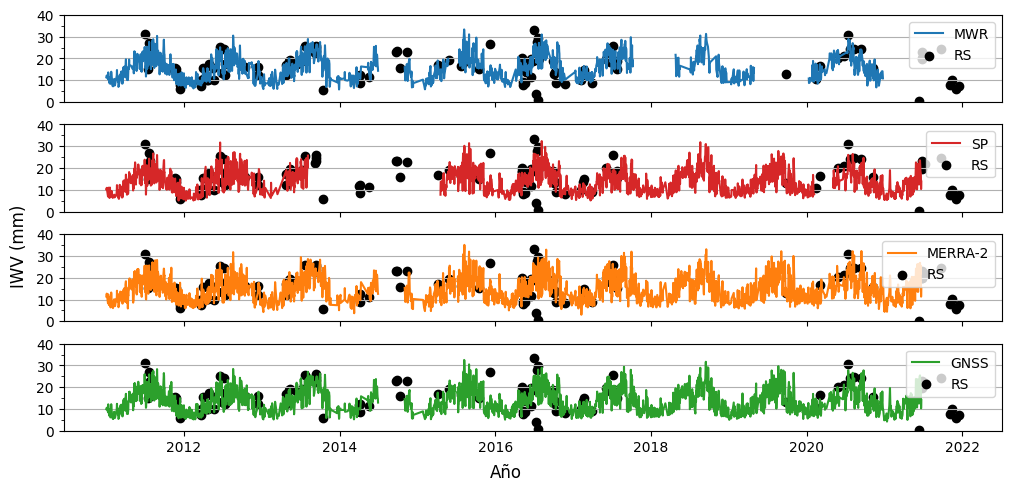

In [ ]:
fig, ax = plt.subplots(4, sharex=True, constrained_layout=True)

ax[0].plot(union_MWR_MERRA_diario.Combined, union_MWR_MERRA_diario.MWR, label='MWR', color='tab:blue')
ax[0].scatter(union_SR_MERRA_diario.Combined, union_SR_MERRA_diario.RS, label='RS', color='black')
ax[0].legend(loc='upper right')
ax[0].grid(True, which='major', axis='y')
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax[0].set_ylim(0, 40)
#ax[0].set_yticklabels([0,10,20,30], color='black',size=15)

ax[1].plot(union_SP_MERRA_diario.Combined, union_SP_MERRA_diario.SP, label='SP', color='tab:red')
ax[1].scatter(union_SR_MERRA_diario.Combined, union_SR_MERRA_diario.RS, label='RS', color='black')
ax[1].legend(loc='upper right')
ax[1].grid(True, which='major', axis='y')
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax[1].set_ylim(0, 40)
#ax[1].set_yticklabels([0,10,20,30], color='black',size=15)

ax[2].plot(union_granada_MERRA_diario.Combined, union_granada_MERRA_diario.TQV, label='MERRA-2', color='tab:orange')
ax[2].scatter(union_SR_MERRA_diario.Combined, union_SR_MERRA_diario.RS, label='RS', color='black')
ax[2].legend(loc='upper right')
ax[2].grid(True, which='major', axis='y')
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax[2].set_ylim(0, 40)
#ax[2].set_yticklabels([0,10,20,30], color='black',size=15)

ax[3].plot(union_granada_MERRA_diario.Combined, union_granada_MERRA_diario.NGL_GNSS, label='GNSS', color='tab:green')
ax[3].scatter(union_SR_MERRA_diario.Combined, union_SR_MERRA_diario.RS, label='RS', color='black')
ax[3].legend(loc='upper right')
ax[3].grid(True, which='major', axis='y')
ax[3].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax[3].set_ylim(0, 40)
#ax[3].set_yticklabels([0,10,20,30], color='black',size=15)
#ax[3].set_xticklabels([2010, 2012, 2014, 2016, 2018, 2020, 2022], color='black',size=15)


'''ax[4].scatter(union_SR_MERRA_diario.Combined, union_SR_MERRA_diario.RS, label='RS', color='tab:purple')
ax[4].legend(loc='upper right')
ax[4].grid(True, which='major', axis='y')
ax[4].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[4].yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax[4].set_ylim(0, 40)'''

fig.set_figwidth(10)
fig.supxlabel('Año')
fig.supylabel('IWV (mm)')

plt.savefig('Evolucion diaria de SP, MWR, MERRA y GNSS y RS de fondo negro.pdf', format='pdf')
plt.savefig('Evolucion diaria de SP, MWR, MERRA y GNSS y RS de fondo negro.png', format='png')
plt.show()

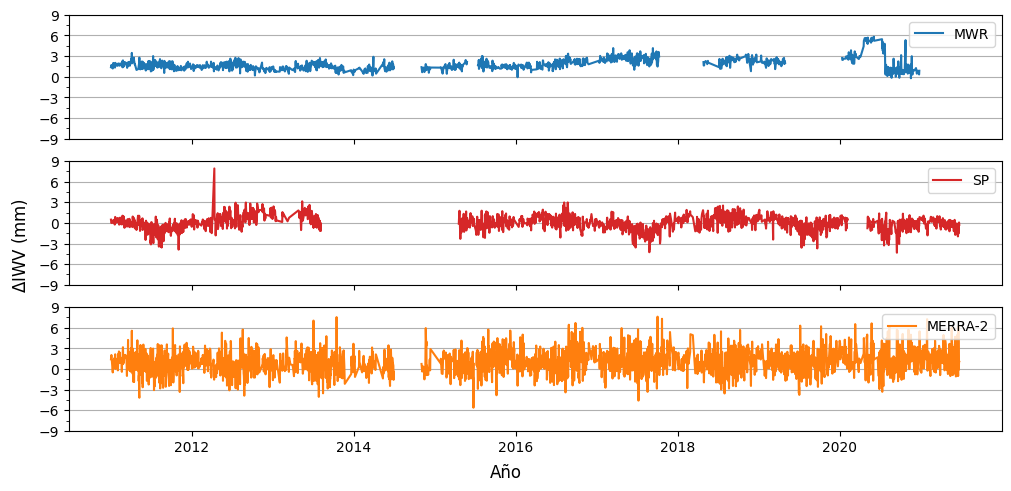

In [ ]:
fig, ax = plt.subplots(3, sharex=True, constrained_layout=True)

ax[0].plot(union_MWR_MERRA_diario.Combined, union_MWR_MERRA_diario.dif, label='MWR', color='tab:blue')
ax[0].grid(True, which='major', axis='y')
ax[0].legend(loc='upper right')
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(3))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(1.5))
ax[0].set_ylim(-9, 9)


ax[1].plot(union_SP_MERRA_diario.Combined, union_SP_MERRA_diario.dif, label='SP', color='tab:red')
ax[1].grid(True, which='major', axis='y')
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(3))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(1.5))
ax[1].set_ylim(-9, 9)

ax[2].plot(union_granada_MERRA_diario.Combined, union_granada_MERRA_diario.dif, label='MERRA-2', color='tab:orange')
ax[2].grid(True, which='major', axis='y')
ax[2].legend(loc='upper right')
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(3))
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(1.5))
ax[2].set_ylim(-9, 9)

'''ax[3].scatter(union_granada_SR_diario.Combined, union_granada_SR_diario.dif, label='RS', color='tab:purple')
ax[3].grid(True, which='major', axis='y')
ax[3].legend(loc='upper right')
ax[3].yaxis.set_major_locator(ticker.MultipleLocator(6))
ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(3))
ax[3].set_ylim(-16, 9)'''

#Ponemos ahora el eje x (no queda bien)
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(9000))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(90))

fig.set_figwidth(10)
fig.supxlabel('Año')
fig.supylabel(r'$\Delta$IWV (mm)')

plt.savefig('Evolucion diaria de MWR, SP y MERRA tomando como referencia GNSS.pdf', format='pdf')
plt.savefig('Evolucion diaria de MWR, SP y MERRA tomando como referencia GNSS.png', format='png')
plt.show()

Añado las columnas para obtener la diferencia relativa de cada instrumento

In [ ]:
union_SP_MERRA_diario.insert(9, 'relativo', (union_SP_MERRA_diario['dif']/union_SP_MERRA_diario['NGL_GNSS'])*100)

In [ ]:
union_MWR_MERRA_diario.insert(9, 'relativo', (union_MWR_MERRA_diario['dif']/union_MWR_MERRA_diario['NGL_GNSS'])*100)

In [ ]:
union_granada_MERRA_diario.insert(9, 'relativo', (union_granada_MERRA_diario['dif']/union_granada_MERRA_diario['NGL_GNSS'])*100)

In [ ]:
union_SP_MERRA_diario

,Año,Mes,Dia,Hora,TQV,SP,NGL_GNSS,RelDif,dif,relativo,Combined
0,2011,1,2,13.500000,11.721958,10.212060,9.740000,5.005919,0.472060,4.846612,2011-01-02
1,2011,1,4,12.500000,13.575234,10.954127,10.976250,-0.193649,-0.022123,-0.201551,2011-01-04
2,2011,1,10,13.000000,6.590003,6.949276,6.727143,3.928991,0.222133,3.302046,2011-01-10
3,2011,1,12,12.666667,12.087435,11.016920,11.016667,0.058253,0.000253,0.002297,2011-01-12
4,2011,1,13,12.000000,9.475588,8.010348,7.574444,5.836449,0.435904,5.754931,2011-01-13
...,...,...,...,...,...,...,...,...,...,...,...
2262,2021,6,17,14.500000,21.599706,21.006725,22.606250,-6.879416,-1.599525,-7.075587,2021-06-17
2263,2021,6,18,10.600000,25.630948,18.684299,19.474000,-4.049045,-0.789701,-4.055155,2021-06-18
2264,2021,6,20,14.500000,18.540976,17.159948,18.643000,-7.996793,-1.483052,-7.955008,2021-06-20
2265,2021,6,21,12.500000,11.309751,10.391561,10.331429,0.363911,0.060132,0.582033,2021-06-21


In [ ]:
union_granada_SR_diario.insert(9, 'relativo', (union_granada_SR_diario['dif']/union_granada_SR_diario['NGL_GNSS'])*100)

Elimino los periodos donde no ha habido datos

In [ ]:
union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_1) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_1), 'relativo'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_2) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_2), 'relativo'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_3) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_3), 'relativo'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_4) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_4), 'relativo'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_5) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_5), 'relativo'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_6) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_6), 'relativo'] = np.nan

union_MWR_MERRA_diario.loc[(union_MWR_MERRA_diario.Combined >= inicio_gap_MWR_7) & (union_MWR_MERRA_diario.Combined <= fin_gap_MWR_7), 'relativo'] = np.nan

In [ ]:
union_SP_MERRA_diario.loc[(union_SP_MERRA_diario.Combined >= inicio_gap_SP_1) & (union_SP_MERRA_diario.Combined <= fin_gap_SP_1), 'relativo'] = np.nan

union_SP_MERRA_diario.loc[(union_SP_MERRA_diario.Combined >= inicio_gap_SP_2) & (union_SP_MERRA_diario.Combined <= fin_gap_SP_2), 'relativo'] = np.nan

In [ ]:
union_granada_MERRA_diario.loc[(union_granada_MERRA_diario.Combined >= inicio_gap_GNSS) & (union_granada_MERRA_diario.Combined <= fin_gap_GNSS), 'relativo'] = np.nan

union_granada_MERRA_diario.loc[(union_granada_MERRA_diario.Combined >= inicio_gap_GNSS_2) & (union_granada_MERRA_diario.Combined <= fin_gap_GNSS_2), 'relativo'] = np.nan

Hago ahora la gráfica con estas diferencias relativas

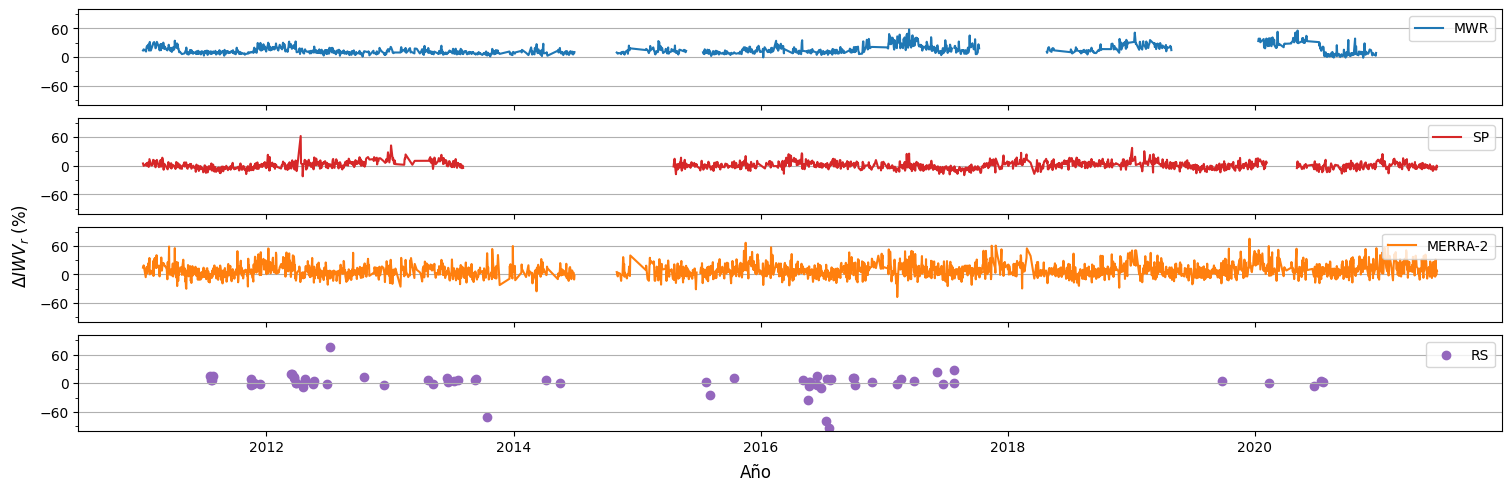

In [ ]:
fig, ax = plt.subplots(4, sharex=True, constrained_layout=True)

ax[0].plot(union_MWR_MERRA_diario.Combined, union_MWR_MERRA_diario.relativo, label='MWR', color='tab:blue')
ax[0].grid(True, which='major', axis='y')
ax[0].legend(loc='upper right')
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(60))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(30))
ax[0].set_ylim(-100, 100)


ax[1].plot(union_SP_MERRA_diario.Combined, union_SP_MERRA_diario.relativo, label='SP', color='tab:red')
ax[1].grid(True, which='major', axis='y')
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(60))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(30))
ax[1].set_ylim(-100, 100)

ax[2].plot(union_granada_MERRA_diario.Combined, union_granada_MERRA_diario.relativo, label='MERRA-2', color='tab:orange')
ax[2].grid(True, which='major', axis='y')
ax[2].legend(loc='upper right')
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(60))
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(30))
ax[2].set_ylim(-100, 100)

ax[3].scatter(union_granada_SR_diario.Combined, union_granada_SR_diario.relativo, label='RS', color='tab:purple')
ax[3].grid(True, which='major', axis='y')
ax[3].legend(loc='upper right')
ax[3].yaxis.set_major_locator(ticker.MultipleLocator(60))
ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(30))
ax[3].set_ylim(-100, 100)

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel(r'$\Delta IWV_r$ (%)')

'''plt.savefig('Evolucion relativa tomando como referencia GNSS.pdf', format='pdf')
plt.savefig('Evolucion relativa tomando como referencia GNSS.png', format='png')'''
plt.show()

Realizamos ahora un boxplot con los datos anuales de cada instrumento

In [ ]:
union_SP_MERRA.head(5)

,Año,Mes,Dia,Hora,TQV,SP,NGL_GNSS,RelDif,dif
0,2011,1,2,12,11.643253,10.662090,10.39,2.618768,0.272090
1,2011,1,2,15,11.800663,9.762030,9.09,7.393069,0.672030
2,2011,1,4,9,12.286804,10.744580,10.79,-0.420945,-0.045420
3,2011,1,4,10,12.649545,10.763927,10.77,-0.056391,-0.006073
4,2011,1,4,11,13.214520,10.157374,10.41,-2.426763,-0.252626


In [ ]:
union_SP_MERRA['Combined'] = union_SP_MERRA.apply(combine_columns, axis=1)

union_SP_MERRA['Combined'] = pd.to_datetime(union_SP_MERRA['Combined'], format='%Y.0%m.0%d.0')

union_SP_MERRA.head(5)

,Año,Mes,Dia,Hora,TQV,SP,NGL_GNSS,RelDif,dif,Combined
0,2011,1,2,12,11.643253,10.662090,10.39,2.618768,0.272090,2011-01-02
1,2011,1,2,15,11.800663,9.762030,9.09,7.393069,0.672030,2011-01-02
2,2011,1,4,9,12.286804,10.744580,10.79,-0.420945,-0.045420,2011-01-04
3,2011,1,4,10,12.649545,10.763927,10.77,-0.056391,-0.006073,2011-01-04
4,2011,1,4,11,13.214520,10.157374,10.41,-2.426763,-0.252626,2011-01-04


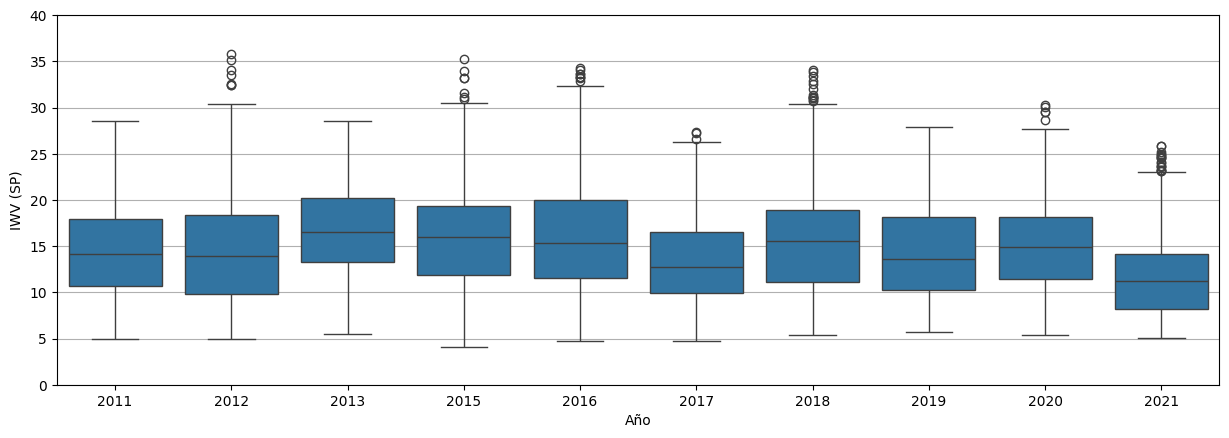

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_SP_MERRA, x = 'Año', y = 'SP')

ax.grid(True, which='major', axis='y')
ax.set_ylim(0, 40)

ax.set(ylabel='IWV (SP)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion SP en boxplot.pdf', format='pdf')
plt.savefig('Evolucion SP en boxplot.png', format='png')'''
plt.show()

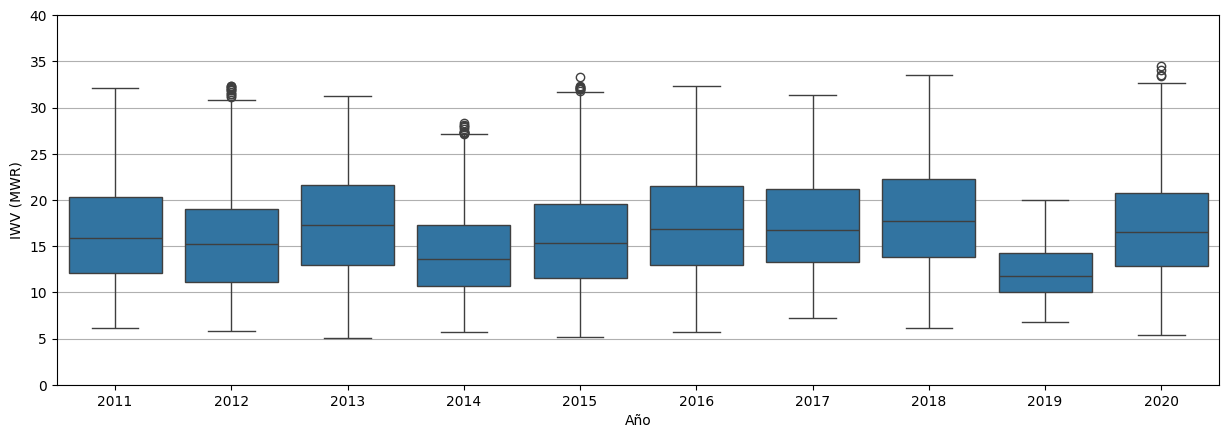

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_MWR_MERRA, x = 'Año', y = 'MWR')

ax.grid(True, which='major', axis='y')
ax.set_ylim(0, 40)

ax.set(ylabel='IWV (MWR)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion MWR en boxplot.pdf', format='pdf')
plt.savefig('Evolucion MWR en boxplot.png', format='png')'''
plt.show()

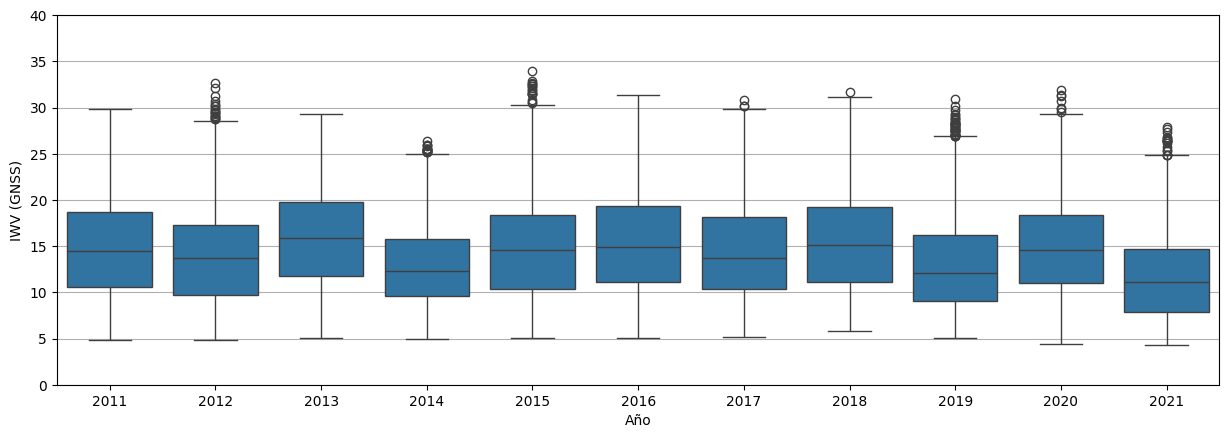

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_MERRA, x = 'Año', y = 'NGL_GNSS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(0, 40)

ax.set(ylabel='IWV (GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion GNSS en boxplot.png', format='png')'''
plt.show()

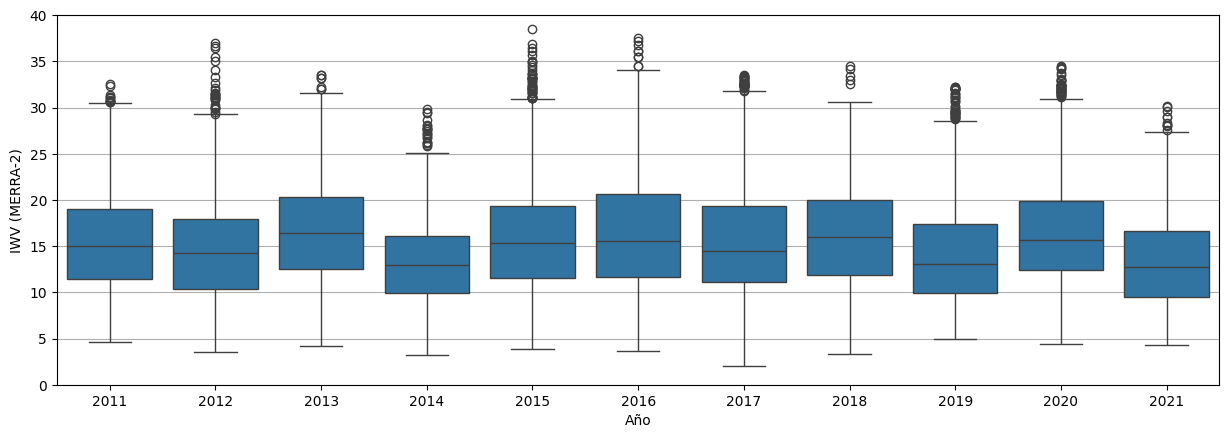

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_MERRA, x = 'Año', y = 'TQV')

ax.grid(True, which='major', axis='y')
ax.set_ylim(0, 40)

ax.set(ylabel='IWV (MERRA-2)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion MERRA-2 en boxplot.pdf', format='pdf')
plt.savefig('Evolucion MERRA-2 en boxplot.png', format='png')'''
plt.show()

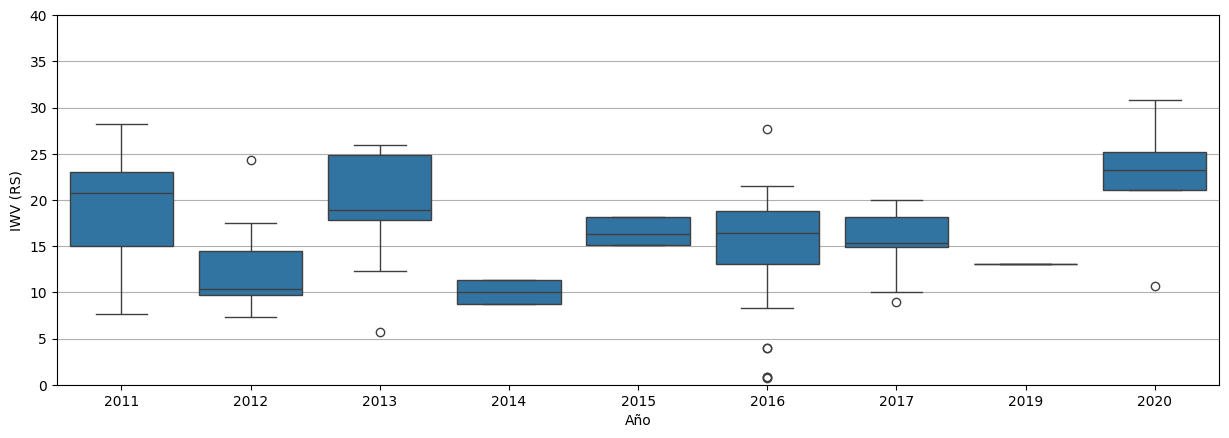

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_SR, x = 'Año', y = 'RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(0, 40)

ax.set(ylabel='IWV (RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion RS en boxplot.png', format='png')'''
plt.show()

Igual con la diferencia con respecto a GNSS

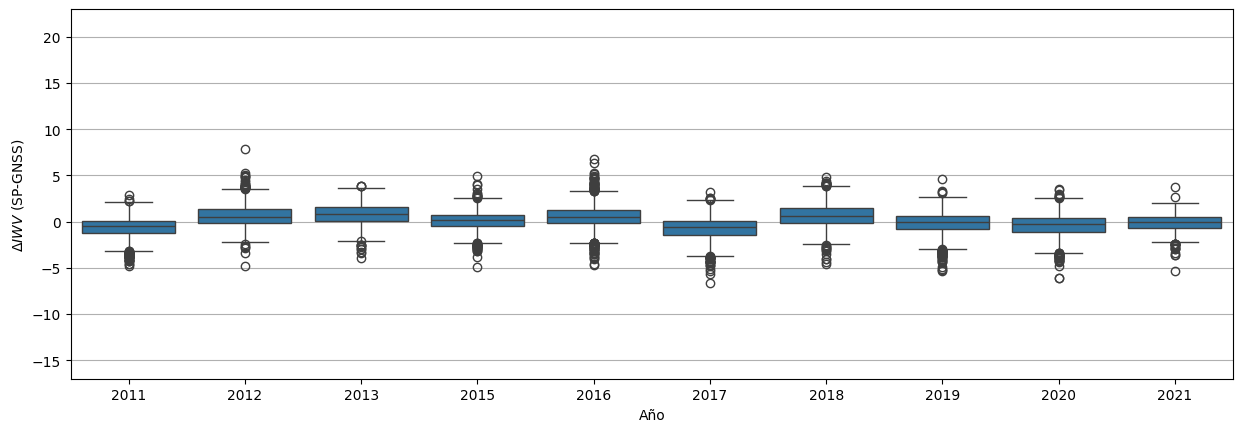

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_SP_MERRA, x = 'Año', y = 'dif')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-17, 23)

ax.set(ylabel=r'$\Delta IWV$ (SP-GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion diferencia SP con referencia GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion diferencia SP con referencia GNSS en boxplot.png', format='png')'''
plt.show()

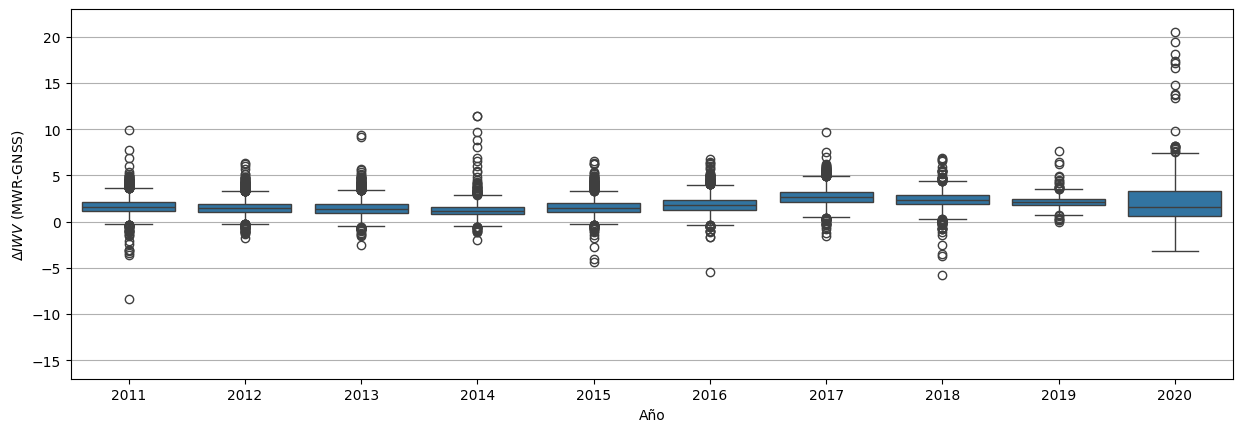

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_MWR_MERRA, x = 'Año', y = 'dif')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-17, 23)

ax.set(ylabel=r'$\Delta IWV$ (MWR-GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion diferencia MWR con referencia GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion diferencia MWR con referencia GNSS en boxplot.png', format='png')'''
plt.show()

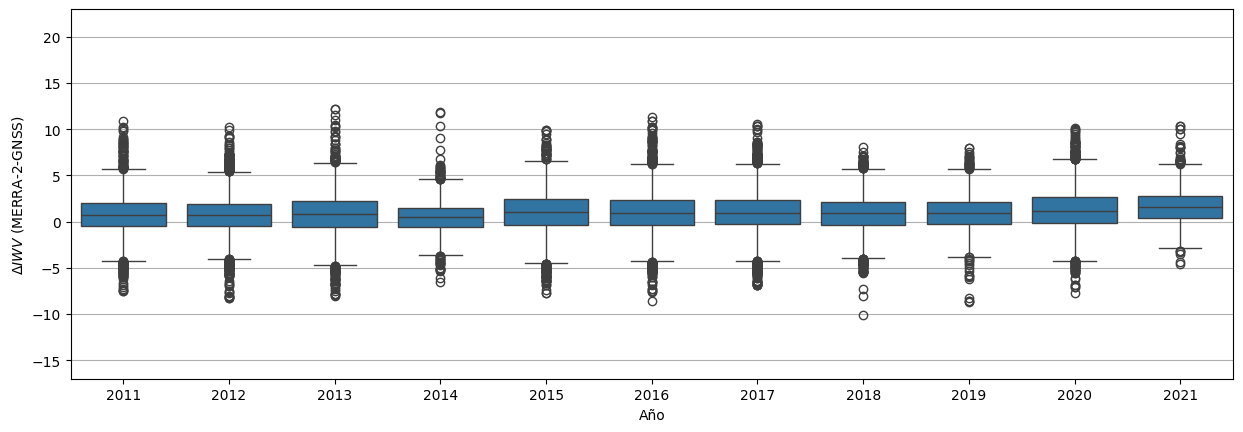

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_MERRA, x = 'Año', y = 'dif')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-17, 23)

ax.set(ylabel=r'$\Delta IWV$ (MERRA-2-GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion diferencia MERRA-2 con referencia GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion diferencia MERRA-2 con referencia GNSS en boxplot.png', format='png')'''
plt.show()

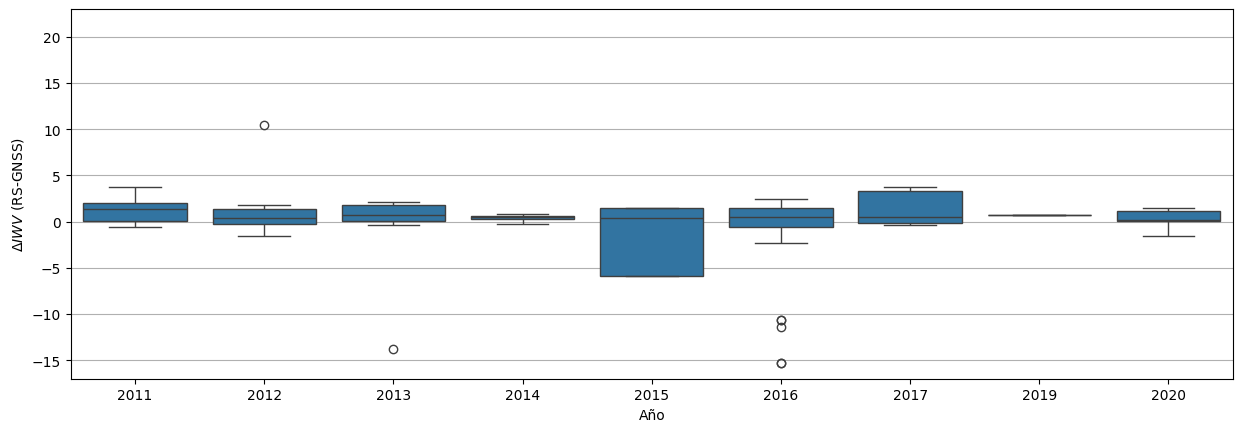

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_SR, x = 'Año', y = 'dif')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-17, 23)

ax.set(ylabel=r'$\Delta IWV$ (RS-GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion diferencia RS con referencia GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion diferencia RS con referencia GNSS en boxplot.png', format='png')'''
plt.show()

Igual con la diferencia relativa con respecto a GNSS

Primera añado la columna para obtener la diferencia relativa

In [ ]:
union_SP_MERRA.insert(9, 'relativo', (union_SP_MERRA['dif']/union_SP_MERRA['NGL_GNSS'])*100)

In [ ]:
union_MWR_MERRA.insert(9, 'relativo', (union_MWR_MERRA['dif']/union_MWR_MERRA['NGL_GNSS'])*100)

In [ ]:
union_granada_MERRA.insert(8, 'relativo', (union_granada_MERRA['dif']/union_granada_MERRA['NGL_GNSS'])*100)

In [ ]:
union_granada_SR.insert(8, 'relativo', (union_granada_SR['dif']/union_granada_SR['NGL_GNSS'])*100)

Realizo ahora los plots

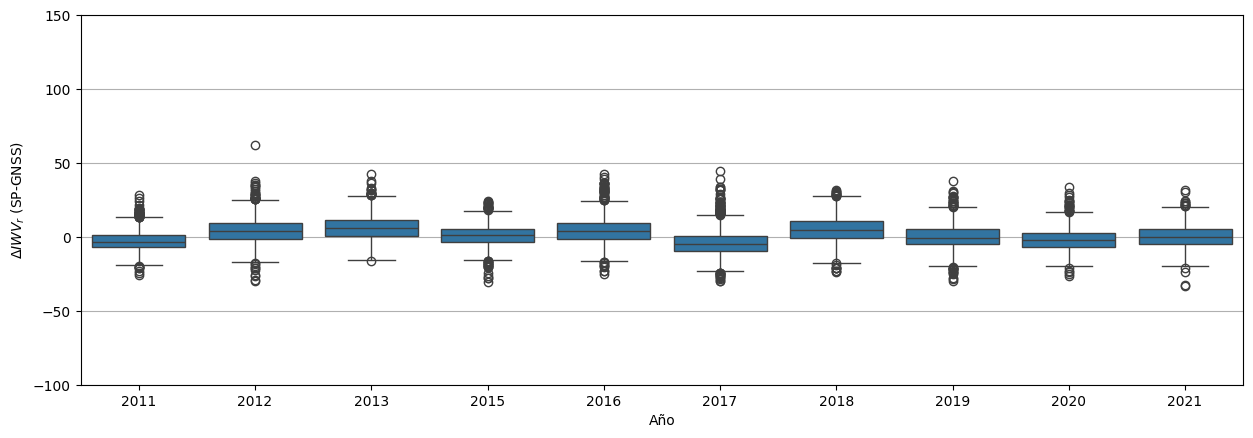

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_SP_MERRA, x = 'Año', y = 'relativo')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-100, 150)

ax.set(ylabel=r'$\Delta IWV_r$ (SP-GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion relativa SP con referencia GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa SP con referencia GNSS en boxplot.png', format='png')'''
plt.show()

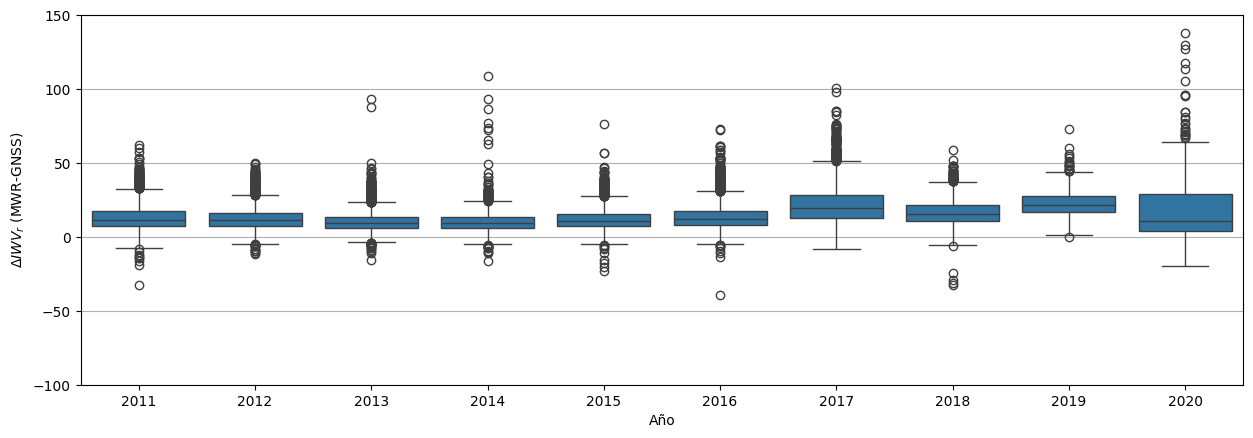

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_MWR_MERRA, x = 'Año', y = 'relativo')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-100, 150)

ax.set(ylabel=r'$\Delta IWV_r$ (MWR-GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion relativa MWR con referencia GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa MWR con referencia GNSS en boxplot.png', format='png')'''
plt.show()

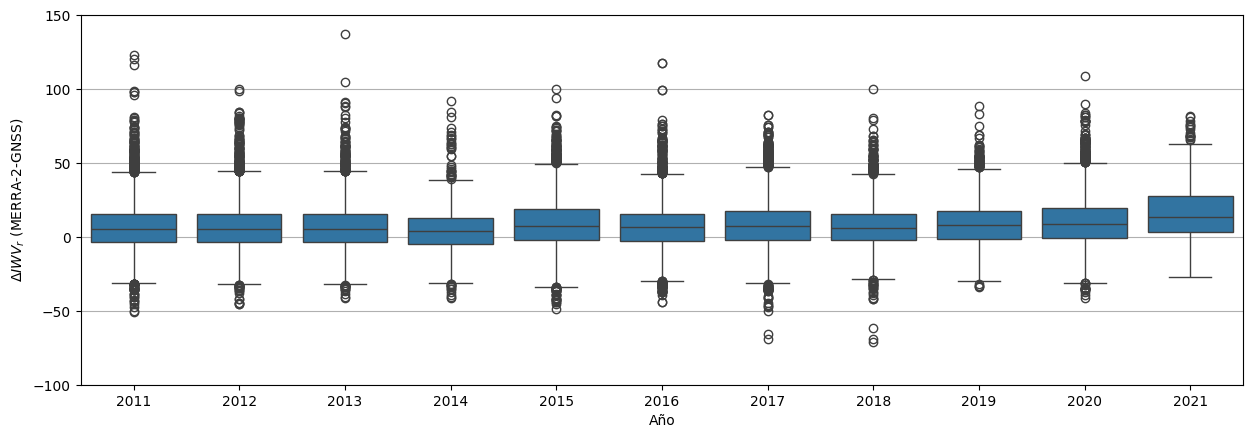

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_MERRA, x = 'Año', y = 'relativo')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-100, 150)

ax.set(ylabel=r'$\Delta IWV_r$ (MERRA-2-GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion relativa MERRA-2 con referencia GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa MERRA-2 con referencia GNSS en boxplot.png', format='png')'''
plt.show()

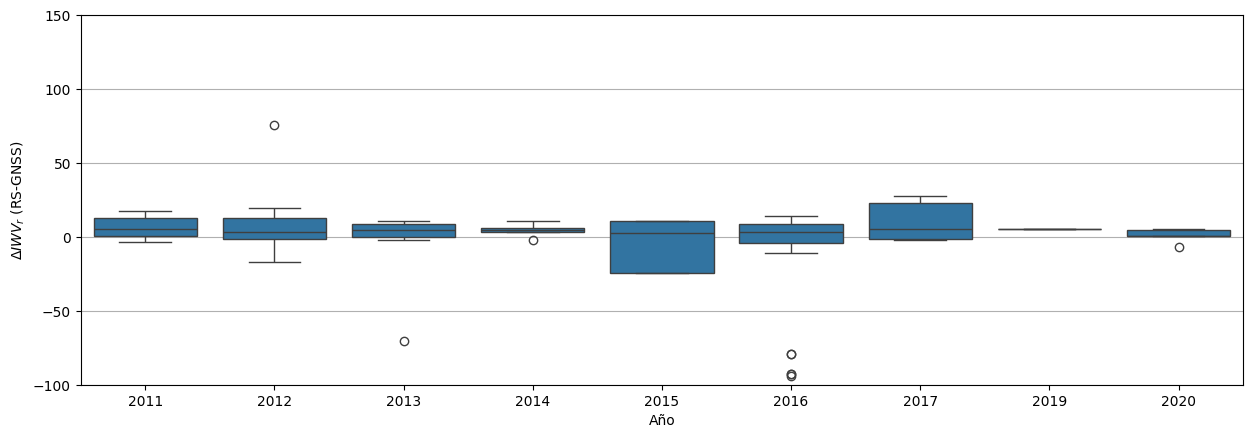

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_SR, x = 'Año', y = 'relativo')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-100, 150)

ax.set(ylabel=r'$\Delta IWV_r$ (RS-GNSS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion relativa RS con referencia GNSS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa RS con referencia GNSS en boxplot.png', format='png')'''
plt.show()

Ahora igual pero tomando como referencia RS

Primero obtengo la diferencia y direrencia relativa de los valores de cada instrumento con RS

In [ ]:
union_SP_SR.insert(6, 'dif_RS', union_SP_SR['SP'] - union_SP_SR['RS'])

In [ ]:
union_MWR_SR.insert(6, 'dif_RS', union_MWR_SR['MWR'] - union_MWR_SR['RS'])

In [ ]:
union_SR_MERRA.insert(6, 'dif_RS', union_SR_MERRA['TQV'] - union_SR_MERRA['RS'])

In [ ]:
union_granada_SR.insert(6, 'dif_RS', union_granada_SR['NGL_GNSS'] - union_granada_SR['RS'])

In [ ]:
union_SP_SR.insert(8, 'relativo_RS', (union_SP_SR['dif_RS']/union_SP_SR['RS'])*100)

In [ ]:
union_MWR_SR.insert(8, 'relativo_RS', (union_MWR_SR['dif_RS']/union_MWR_SR['RS'])*100)

In [ ]:
union_SR_MERRA.insert(7, 'relativo_RS', (union_SR_MERRA['dif_RS']/union_SR_MERRA['RS'])*100)

In [ ]:
union_granada_SR.insert(7, 'relativo_RS', (union_granada_SR['dif_RS']/union_granada_SR['RS'])*100)

Realizo ahora las medias diarias para conseguir las gráficas anteriores

In [ ]:
#Media diaria de la unión de RS y SP

union_SP_SR_diario = union_SP_SR.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_SP_SR_diario = union_SP_SR_diario.reset_index()

union_SP_SR_diario['Combined'] = union_SP_SR_diario.apply(combine_columns, axis=1)

union_SP_SR_diario['Combined'] = pd.to_datetime(union_SP_SR_diario['Combined'], format='%Y.0%m.0%d.0')

union_SP_SR_diario

,Año,Mes,Dia,Hora,RS,SP,dif_RS,NGL_GNSS,relativo_RS,dif,Combined
0,2011,7,18,12.0,16.070879,13.648988,-2.421892,14.090,-15.070064,-0.441012,2011-07-18
1,2011,7,22,10.0,28.184563,24.637846,-3.546717,26.770,-12.583899,-2.132154,2011-07-22
2,2011,7,25,11.0,20.760160,18.147806,-2.612354,20.050,-12.583498,-1.902194,2011-07-25
3,2011,7,28,11.0,21.208625,19.300294,-1.908331,18.860,-8.997901,0.440294,2011-07-28
4,2011,11,18,12.0,15.440228,14.562210,-0.878018,16.040,-5.686560,-1.477790,2011-11-18
5,2011,11,25,11.0,13.732424,12.616154,-1.116270,13.640,-8.128719,-1.023846,2011-11-25
6,2012,3,16,12.0,9.753618,8.770077,-0.983541,8.180,-10.083860,0.590077,2012-03-16
7,2012,3,23,12.0,8.702428,7.868103,-0.834324,7.900,-9.587258,-0.031897,2012-03-23
8,2012,4,18,10.0,7.336035,6.211110,-1.124925,8.870,-15.334232,-2.658890,2012-04-18
9,2012,4,24,10.0,10.110379,10.514883,0.404503,9.760,4.000873,0.754883,2012-04-24


In [ ]:
#Media diaria de la unión de RS y MWR

union_MWR_SR_diario = union_MWR_SR.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_MWR_SR_diario = union_MWR_SR_diario.reset_index()

union_MWR_SR_diario['Combined'] = union_MWR_SR_diario.apply(combine_columns, axis=1)

union_MWR_SR_diario['Combined'] = pd.to_datetime(union_MWR_SR_diario['Combined'], format='%Y.0%m.0%d.0')

union_MWR_SR_diario

,Año,Mes,Dia,Hora,RS,MWR,dif_RS,NGL_GNSS,relativo_RS,dif,Combined
0,2011,7,18,12.0,16.070879,15.500007,-0.570872,14.090,-3.552213,1.410007,2011-07-18
1,2011,7,22,15.0,27.130321,26.631372,-0.498950,25.440,-1.848499,1.191372,2011-07-22
2,2011,7,25,15.5,21.888156,21.289752,-0.598403,19.995,-2.603949,1.294752,2011-07-25
3,2011,7,28,15.5,23.026116,22.762394,-0.263723,19.980,-0.931536,2.782394,2011-07-28
4,2011,11,17,19.0,14.715284,14.197407,-0.517877,13.580,-3.519313,0.617407,2011-11-17
...,...,...,...,...,...,...,...,...,...,...,...
56,2017,6,22,20.0,18.156026,20.449943,2.293917,18.490,12.634464,1.959943,2017-06-22
57,2017,7,26,20.0,19.966755,21.331706,1.364951,19.750,6.836118,1.581706,2017-07-26
58,2017,7,27,13.0,15.291686,17.646449,2.354762,11.980,15.398971,5.666449,2017-07-27
59,2020,2,13,14.0,10.708237,12.836318,2.128081,10.610,19.873311,2.226318,2020-02-13


In [ ]:
#Media diaria de la unión de RS y MERRA

union_MERRA_SR_diario = union_SR_MERRA.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_MERRA_SR_diario = union_MERRA_SR_diario.reset_index()

union_MERRA_SR_diario['Combined'] = union_MERRA_SR_diario.apply(combine_columns, axis=1)

union_MERRA_SR_diario['Combined'] = pd.to_datetime(union_MERRA_SR_diario['Combined'], format='%Y.0%m.0%d.0')

union_MERRA_SR_diario

,Año,Mes,Dia,Hora,TQV,RS,dif_RS,relativo_RS,Combined
0,2011,7,1,11.0,31.498268,31.087096,0.411172,1.322646,2011-07-01
1,2011,7,18,16.0,12.049473,15.079785,-3.030311,-19.629510,2011-07-18
2,2011,7,22,15.0,24.814966,27.130321,-2.315355,-8.672508,2011-07-22
3,2011,7,25,15.5,21.794935,21.888156,-0.093220,0.066186,2011-07-25
4,2011,7,28,15.5,20.966311,23.026116,-2.059806,-8.652263,2011-07-28
...,...,...,...,...,...,...,...,...,...
105,2021,9,24,10.0,31.689505,24.464121,7.225384,29.534616,2021-09-24
106,2021,11,3,12.0,8.188169,7.854378,0.333790,4.249736,2021-11-03
107,2021,11,11,12.0,8.024032,10.049595,-2.025563,-20.155672,2021-11-11
108,2021,12,2,17.0,5.911748,5.805855,0.105893,1.823906,2021-12-02


In [ ]:
#Media diaria de la unión de RS y GNSS

union_granada_SR_diario = union_granada_SR.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_granada_SR_diario = union_granada_SR_diario.reset_index()

union_granada_SR_diario['Combined'] = union_granada_SR_diario.apply(combine_columns, axis=1)

union_granada_SR_diario['Combined'] = pd.to_datetime(union_granada_SR_diario['Combined'], format='%Y.0%m.0%d.0')

union_granada_SR_diario

,Año,Mes,Dia,Hora,RS,NGL_GNSS,dif_RS,relativo_RS,dif,RelDif,relativo,Combined
0,2011,7,18,12.000000,16.070879,14.090000,-1.980879,-12.325893,1.980879,14.058760,14.058760,2011-07-18
1,2011,7,22,13.333333,27.481735,25.883333,-1.598402,-5.859213,1.598402,6.240965,6.240965,2011-07-22
2,2011,7,25,14.000000,21.512157,20.013333,-1.498824,-6.735584,1.498824,7.503643,7.503643,2011-07-25
3,2011,7,28,14.000000,22.420286,19.606667,-2.813619,-12.405508,2.813619,14.216034,14.216034,2011-07-28
4,2011,11,17,19.000000,14.715284,13.580000,-1.135284,-7.714999,1.135284,8.359971,8.359971,2011-11-17
...,...,...,...,...,...,...,...,...,...,...,...,...
62,2019,9,27,10.000000,13.053750,12.360000,-0.693750,-5.314564,0.693750,5.612864,5.612864,2019-09-27
63,2020,2,13,14.000000,10.708237,10.610000,-0.098237,-0.917396,0.098237,0.925890,0.925890,2020-02-13
64,2020,6,24,15.000000,21.048544,22.590000,1.541456,7.323340,-1.541456,-6.823623,-6.823623,2020-06-24
65,2020,7,14,15.000000,30.819251,29.290000,-1.529251,-4.961998,1.529251,5.221067,5.221067,2020-07-14


Realizamos ambas gráficas

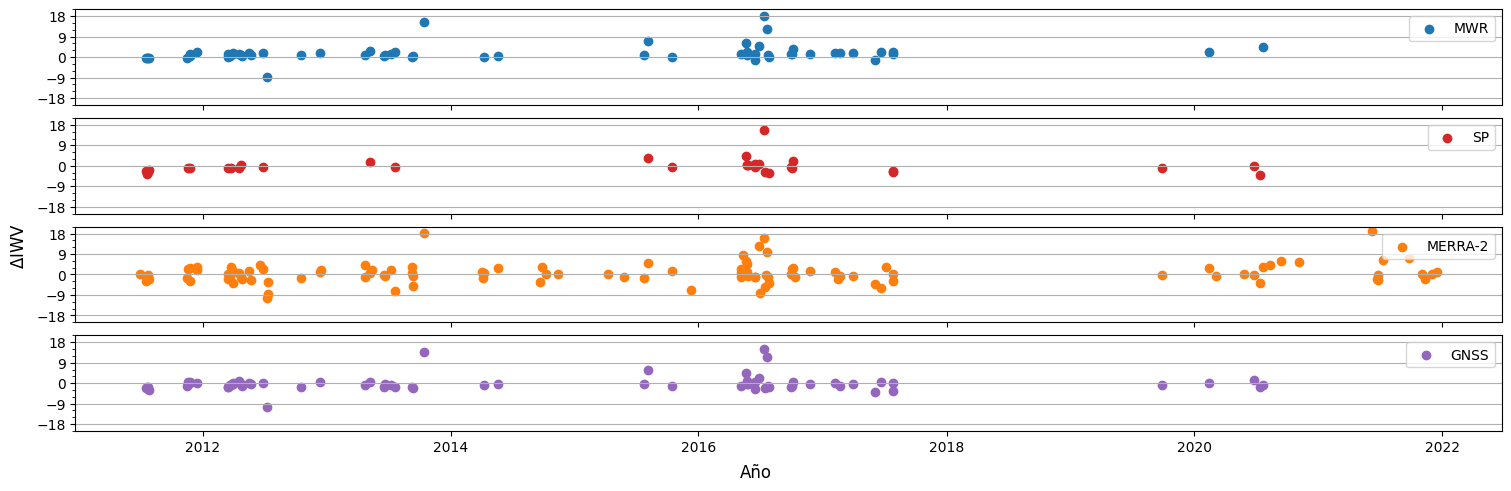

In [ ]:
#Diferencia con respecto a RS

fig, ax = plt.subplots(4, sharex=True, constrained_layout=True)

ax[0].scatter(union_MWR_SR_diario.Combined, union_MWR_SR_diario.dif_RS, label='MWR', color='tab:blue')
ax[0].grid(True, which='major', axis='y')
ax[0].legend(loc='upper right')
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(9))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(3))
ax[0].set_ylim(-21, 21)


ax[1].scatter(union_SP_SR_diario.Combined, union_SP_SR_diario.dif_RS, label='SP', color='tab:red')
ax[1].grid(True, which='major', axis='y')
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(9))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(3))
ax[1].set_ylim(-21, 21)

ax[2].scatter(union_MERRA_SR_diario.Combined, union_MERRA_SR_diario.dif_RS, label='MERRA-2', color='tab:orange')
ax[2].grid(True, which='major', axis='y')
ax[2].legend(loc='upper right')
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(9))
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(3))
ax[2].set_ylim(-21, 21)

ax[3].scatter(union_granada_SR_diario.Combined, union_granada_SR_diario.dif_RS, label='GNSS', color='tab:purple')
ax[3].grid(True, which='major', axis='y')
ax[3].legend(loc='upper right')
ax[3].yaxis.set_major_locator(ticker.MultipleLocator(9))
ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(3))
ax[3].set_ylim(-21, 21)

#Ponemos ahora el eje x (no queda bien)
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(9000))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(90))

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel(r'$\Delta$IWV')

'''plt.savefig('Evolucion diaria tomando como referencia RS.pdf', format='pdf')
plt.savefig('Evolucion diaria tomando como referencia RS.png', format='png')'''
plt.show()

In [ ]:
union_granada_SR_diario.describe()

,Año,Mes,Dia,Hora,RS,NGL_GNSS,dif_RS,relativo_RS,dif,RelDif,relativo,Combined
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67
mean,2014.313433,6.537313,18.701493,15.756219,15.481961,15.423209,-0.058752,37.523079,0.058752,1.049958,1.049958,2014-10-27 17:54:37.611940352
min,2011.000000,2.000000,3.000000,8.000000,0.741417,6.610000,-10.455927,-43.071176,-15.244453,-93.907827,-93.907827,2011-07-18 00:00:00
25%,2012.000000,5.000000,14.500000,13.750000,10.549007,11.825000,-1.505096,-8.054218,-0.280129,-1.720983,-1.720983,2012-04-25 00:00:00
50%,2014.000000,7.000000,20.000000,16.000000,15.440228,15.370000,-0.560709,-3.663749,0.560709,3.803084,3.803084,2014-04-08 00:00:00
75%,2016.000000,7.500000,24.000000,19.000000,18.815779,18.735000,0.280129,1.751196,1.505096,8.761227,8.761227,2016-07-26 12:00:00
max,2020.000000,12.000000,30.000000,20.500000,30.819251,29.290000,15.244453,1541.450470,10.455927,75.657939,75.657939,2020-07-21 00:00:00
std,2.600751,2.624641,7.329920,3.388723,5.969241,5.066225,3.534659,208.693968,3.534659,22.349460,22.349460,NaN


Esta está mal, no se por qué no calcula bien el relativo

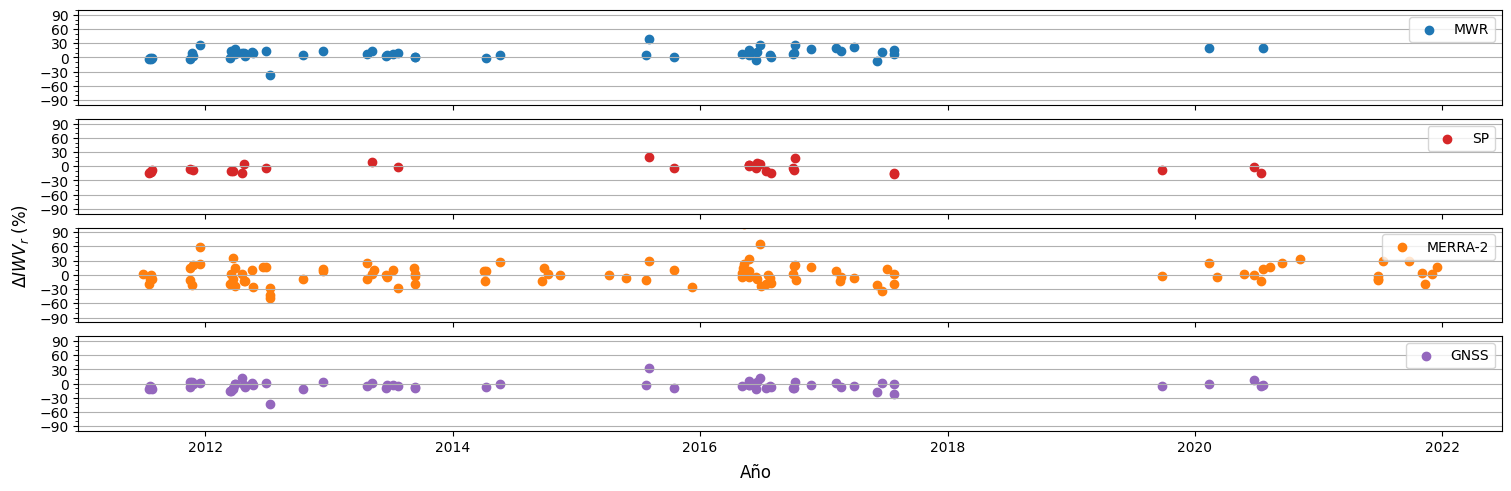

In [ ]:
#Gráfica de diferencia relativa con RS

fig, ax = plt.subplots(4, sharex=True, constrained_layout=True)

ax[0].scatter(union_MWR_SR_diario.Combined, union_MWR_SR_diario.relativo_RS, label='MWR', color='tab:blue')
ax[0].grid(True, which='major', axis='y')
ax[0].legend(loc='upper right')
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(30))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(10))
ax[0].set_ylim(-100, 100)


ax[1].scatter(union_SP_SR_diario.Combined, union_SP_SR_diario.relativo_RS, label='SP', color='tab:red')
ax[1].grid(True, which='major', axis='y')
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(30))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(10))
ax[1].set_ylim(-100, 100)

ax[2].scatter(union_MERRA_SR_diario.Combined, union_MERRA_SR_diario.relativo_RS, label='MERRA-2', color='tab:orange')
ax[2].grid(True, which='major', axis='y')
ax[2].legend(loc='upper right')
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(30))
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(10))
ax[2].set_ylim(-100, 100)

ax[3].scatter(union_granada_SR_diario.Combined, union_granada_SR_diario.relativo_RS, label='GNSS', color='tab:purple')
ax[3].grid(True, which='major', axis='y')
ax[3].legend(loc='upper right')
ax[3].yaxis.set_major_locator(ticker.MultipleLocator(30))
ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(10))
ax[3].set_ylim(-100, 100)

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel(r'$\Delta IWV_r$ (%)')

'''plt.savefig('Evolucion relativa tomando como referencia RS.pdf', format='pdf')
plt.savefig('Evolucion relativa tomando como referencia RS.png', format='png')'''
plt.show()

Ahora obtenemos las gráficas con la diferencia con respecto a RS en intervalos anuales igual que antes

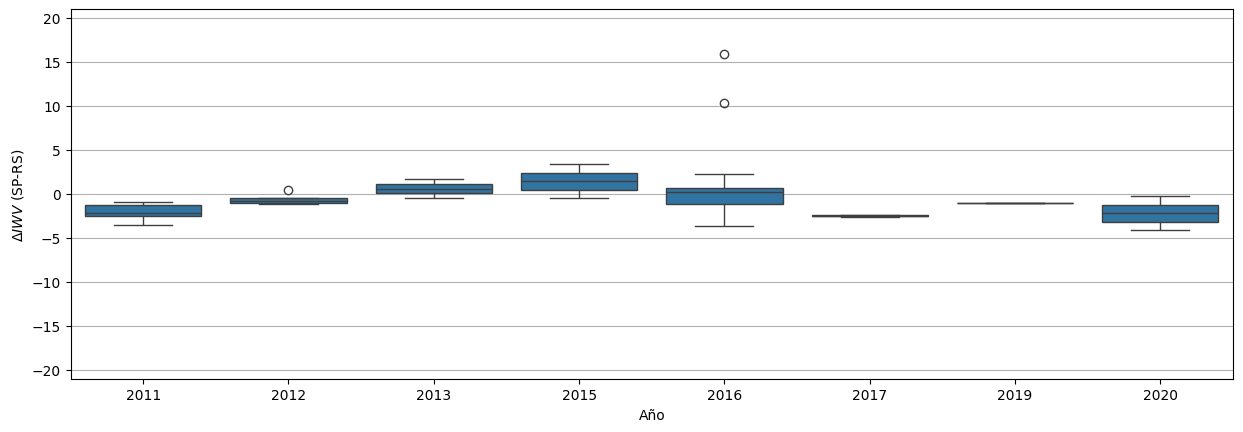

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_SP_SR, x = 'Año', y = 'dif_RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-21, 21)

ax.set(ylabel=r'$\Delta IWV$ (SP-RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion diferencia SP con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion diferencia SP con referencia RS en boxplot.png', format='png')'''
plt.show()

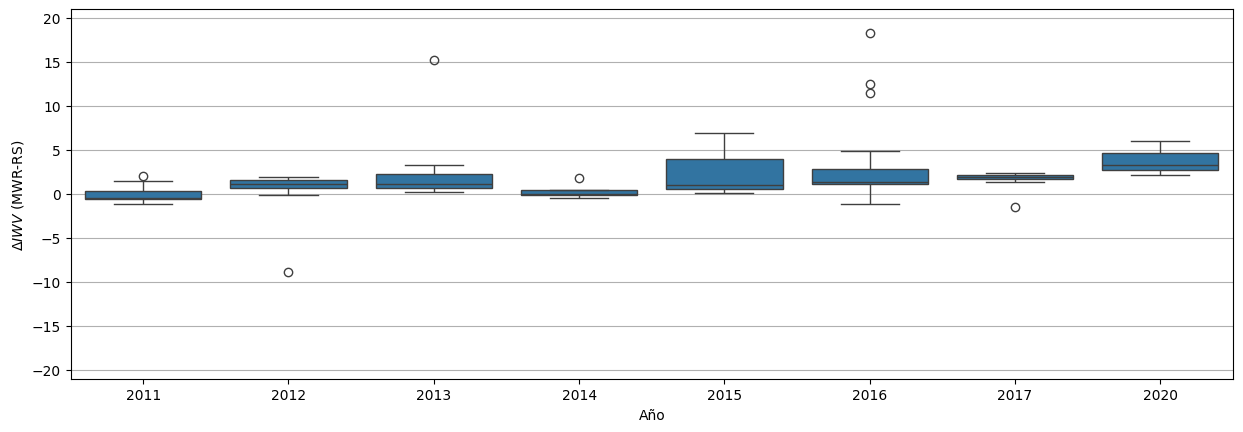

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_MWR_SR, x = 'Año', y = 'dif_RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-21, 21)

ax.set(ylabel=r'$\Delta IWV$ (MWR-RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion diferencia MWR con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion diferencia MWR con referencia RS en boxplot.png', format='png')'''
plt.show()

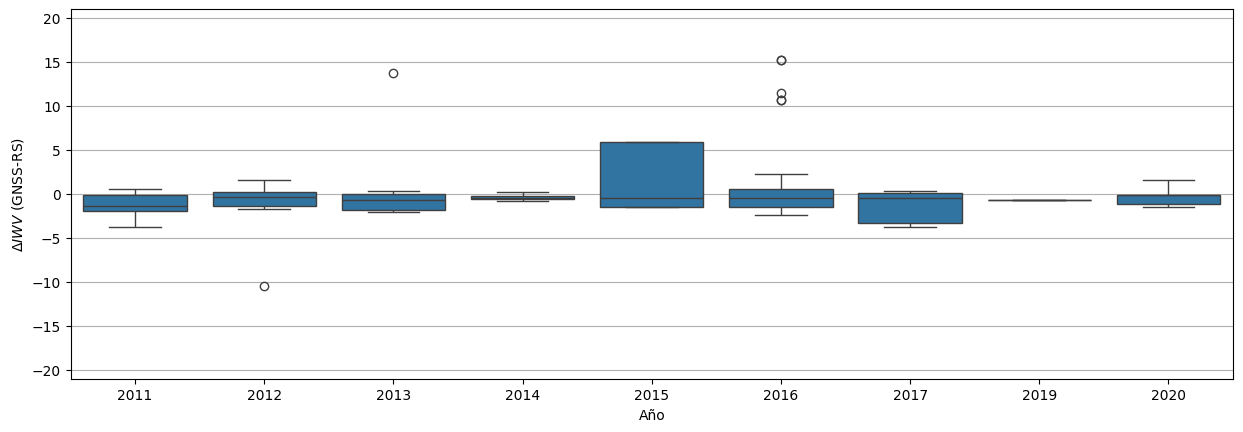

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_SR, x = 'Año', y = 'dif_RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-21, 21)

ax.set(ylabel=r'$\Delta IWV$ (GNSS-RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion diferencia GNSS con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion diferencia GNSS con referencia RS en boxplot.png', format='png')'''
plt.show()

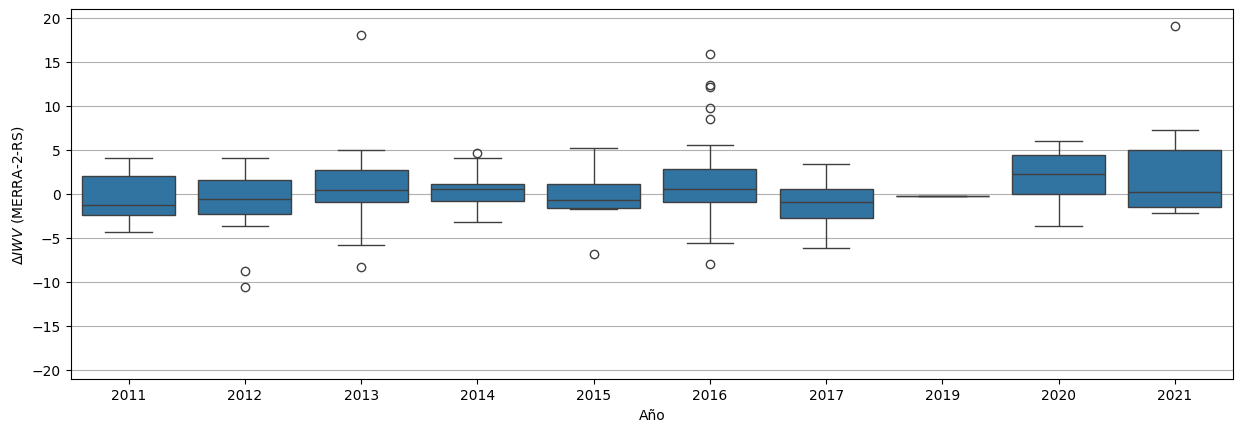

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_SR_MERRA, x = 'Año', y = 'dif_RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-21, 21)

ax.set(ylabel=r'$\Delta IWV$ (MERRA-2-RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion diferencia MERRA-2 con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion diferencia MERRA-2 con referencia RS en boxplot.png', format='png')'''
plt.show()

Ahora con la diferencia relativa

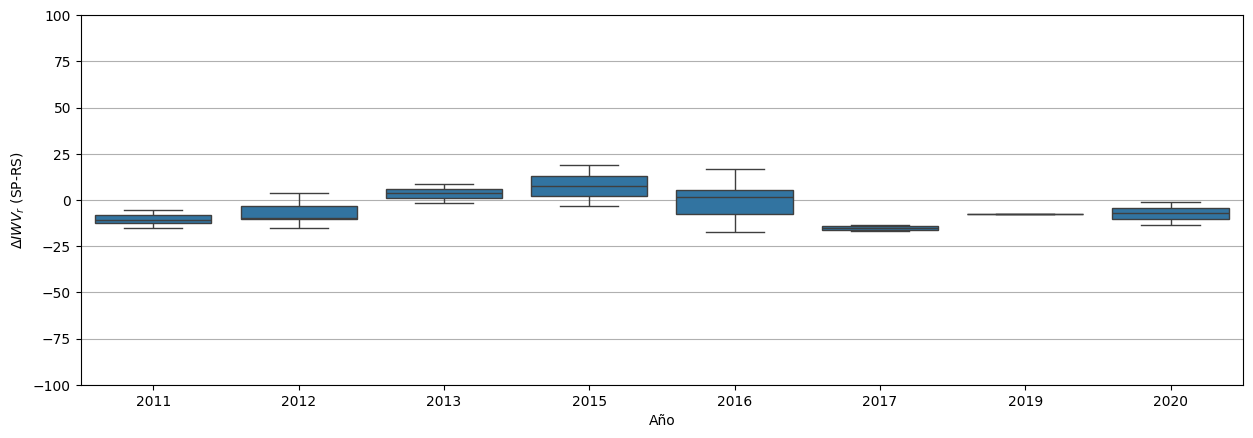

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_SP_SR, x = 'Año', y = 'relativo_RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-100, 100)

ax.set(ylabel=r'$\Delta IWV_r$ (SP-RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion relativa SP con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa SP con referencia RS en boxplot.png', format='png')'''
plt.show()

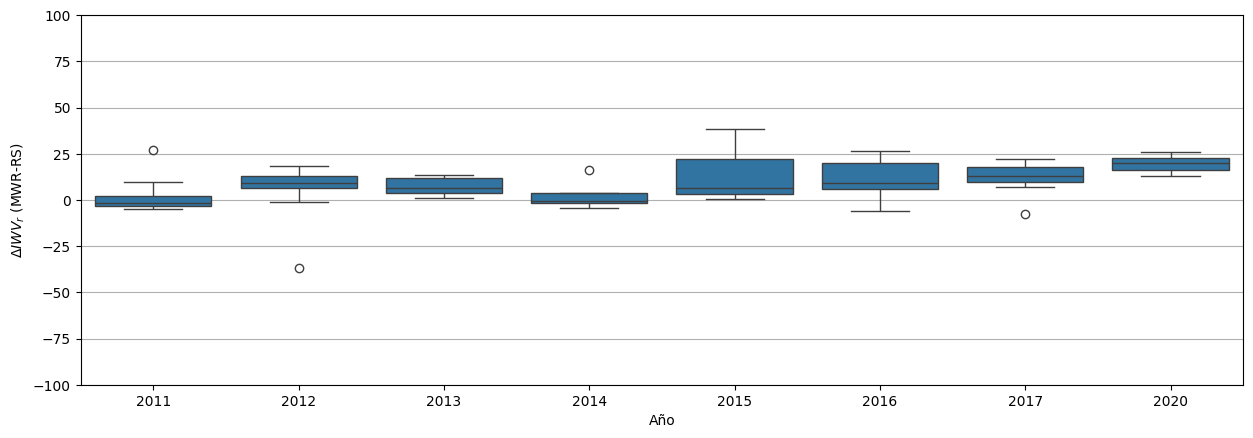

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_MWR_SR, x = 'Año', y = 'relativo_RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-100, 100)

ax.set(ylabel=r'$\Delta IWV_r$ (MWR-RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion relativa MWR con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa MWR con referencia RS en boxplot.png', format='png')'''
plt.show()

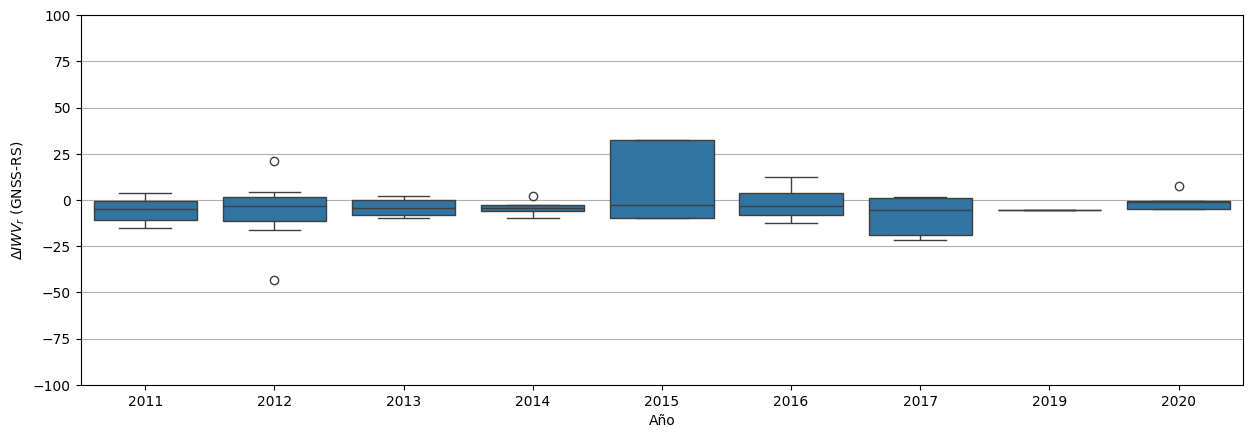

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_granada_SR, x = 'Año', y = 'relativo_RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-100, 100)

ax.set(ylabel=r'$\Delta IWV_r$ (GNSS-RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion relativa GNSS con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa GNSS con referencia RS en boxplot.png', format='png')'''
plt.show()

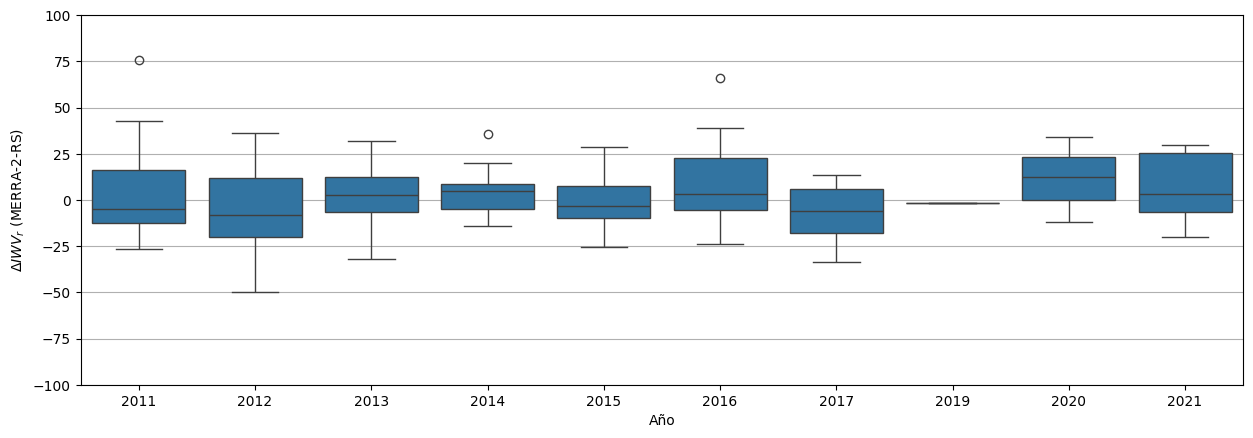

In [ ]:
fig, ax = plt.subplots()

sb.boxplot(data=union_SR_MERRA, x = 'Año', y = 'relativo_RS')

ax.grid(True, which='major', axis='y')
ax.set_ylim(-100, 100)

ax.set(ylabel=r'$\Delta IWV_r$ (MERRA-2-RS)')
fig.set_figwidth(15)

'''plt.savefig('Evolucion relativa MERRA-2 con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa MERRA-2 con referencia RS en boxplot.png', format='png')'''
plt.show()

Rehago las de diferencia relativa pero sin mostrar los puntos que no tienen sentido

In [ ]:
'''fig, ax = plt.subplots()

sb.boxplot(data=union_SP_SR, x = 'Año', y = 'relativo_RS', showfliers=False)

ax.grid(True, which='major', axis='y')

ax.set(ylabel=r'$\Delta IWV_r$ (SP-RS)')
fig.set_figwidth(15)

plt.savefig('Evolucion relativa SP con referencia RS en boxplot.pdf', format='pdf')
plt.savefig('Evolucion relativa SP con referencia RS en boxplot.png', format='png')
plt.show()'''

"fig, ax = plt.subplots()\n\nsb.boxplot(data=union_SP_SR, x = 'Año', y = 'relativo_RS', showfliers=False)\n\nax.grid(True, which='major', axis='y')\n\nax.set(ylabel=r'$\\Delta IWV_r$ (SP-RS)')\nfig.set_figwidth(15)\n\nplt.savefig('Evolucion relativa SP con referencia RS en boxplot.pdf', format='pdf')\nplt.savefig('Evolucion relativa SP con referencia RS en boxplot.png', format='png')\nplt.show()"

In [ ]:
'''fig, ax = plt.subplots()

sb.boxplot(data=union_MWR_SR, x = 'Año', y = 'relativo_RS', showfliers=False)

ax.grid(True, which='major', axis='y')

ax.set(ylabel=r'$\Delta IWV_r$ (MWR-RS)')
fig.set_figwidth(15)

plt.savefig('Evolucion relativa MWR con referencia RS en boxplot.pdf', format='pdf')
plt.show()'''

"fig, ax = plt.subplots()\n\nsb.boxplot(data=union_MWR_SR, x = 'Año', y = 'relativo_RS', showfliers=False)\n\nax.grid(True, which='major', axis='y')\n\nax.set(ylabel=r'$\\Delta IWV_r$ (MWR-RS)')\nfig.set_figwidth(15)\n\nplt.savefig('Evolucion relativa MWR con referencia RS en boxplot.pdf', format='pdf')\nplt.show()"

In [ ]:
'''fig, ax = plt.subplots()

sb.boxplot(data=union_granada_SR, x = 'Año', y = 'relativo_RS', showfliers=False)

ax.grid(True, which='major', axis='y')

ax.set(ylabel=r'$\Delta IWV_r$ (GNSS-RS)')
fig.set_figwidth(15)

plt.savefig('Evolucion relativa GNSS con referencia RS en boxplot.pdf', format='pdf')
plt.show()'''

"fig, ax = plt.subplots()\n\nsb.boxplot(data=union_granada_SR, x = 'Año', y = 'relativo_RS', showfliers=False)\n\nax.grid(True, which='major', axis='y')\n\nax.set(ylabel=r'$\\Delta IWV_r$ (GNSS-RS)')\nfig.set_figwidth(15)\n\nplt.savefig('Evolucion relativa GNSS con referencia RS en boxplot.pdf', format='pdf')\nplt.show()"

In [ ]:
'''fig, ax = plt.subplots()

sb.boxplot(data=union_SR_MERRA, x = 'Año', y = 'relativo_RS', showfliers=False)

ax.grid(True, which='major', axis='y')

ax.set(ylabel=r'$\Delta IWV_r$ (MERRA-2-RS)')
fig.set_figwidth(15)

plt.savefig('Evolucion relativa MERRA-2 con referencia RS en boxplot.pdf', format='pdf')
plt.show()'''

"fig, ax = plt.subplots()\n\nsb.boxplot(data=union_SR_MERRA, x = 'Año', y = 'relativo_RS', showfliers=False)\n\nax.grid(True, which='major', axis='y')\n\nax.set(ylabel=r'$\\Delta IWV_r$ (MERRA-2-RS)')\nfig.set_figwidth(15)\n\nplt.savefig('Evolucion relativa MERRA-2 con referencia RS en boxplot.pdf', format='pdf')\nplt.show()"

Realizamos ahora las gráficas de seasonal decompose con la media diaria y mensual de cada instrumento

Primero media diaria

In [ ]:
diario_SP.set_index('Combined', inplace=True)

In [ ]:
SP_decompose = seasonal_decompose(diario_SP['SP'], model='additive', period=365)

In [ ]:
observado_SP = SP_decompose.observed
tendencia_SP = SP_decompose.trend
estacional_SP = SP_decompose.seasonal
residuos_SP = SP_decompose.resid



observado_SP.loc[(observado_SP.index >= inicio_gap_SP_1) & (observado_SP.index <= fin_gap_SP_1)] = np.nan
observado_SP.loc[(observado_SP.index >= inicio_gap_SP_2) & (observado_SP.index <= fin_gap_SP_2)] = np.nan

tendencia_SP.loc[(tendencia_SP.index >= inicio_gap_SP_1) & (tendencia_SP.index <= fin_gap_SP_1)] = np.nan
tendencia_SP.loc[(tendencia_SP.index >= inicio_gap_SP_2) & (tendencia_SP.index <= fin_gap_SP_2)] = np.nan

estacional_SP.loc[(estacional_SP.index >= inicio_gap_SP_1) & (estacional_SP.index <= fin_gap_SP_1)] = np.nan
estacional_SP.loc[(estacional_SP.index >= inicio_gap_SP_2) & (estacional_SP.index <= fin_gap_SP_2)] = np.nan

residuos_SP.loc[(residuos_SP.index >= inicio_gap_SP_1) & (residuos_SP.index <= fin_gap_SP_1)] = np.nan
residuos_SP.loc[(residuos_SP.index >= inicio_gap_SP_2) & (residuos_SP.index <= fin_gap_SP_2)] = np.nan

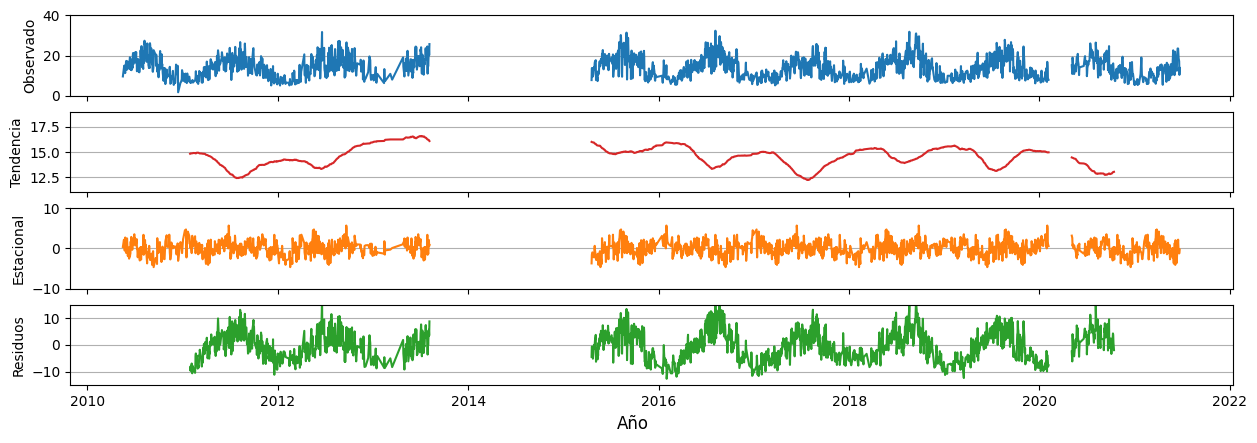

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(observado_SP, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(480))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].plot(tendencia_SP, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].plot(estacional_SP, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].plot(residuos_SP, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose SP.pdf', format='pdf')
plt.savefig('Seasonal decompose SP.png', format='png')'''
plt.show()

MWR

In [ ]:
diario_MWR.set_index('Combined', inplace=True)

In [ ]:
MWR_decompose = seasonal_decompose(diario_MWR['MWR'], model='additive', period=365)

In [ ]:
observado_MWR = MWR_decompose.observed
tendencia_MWR = MWR_decompose.trend
estacional_MWR = MWR_decompose.seasonal
residuos_MWR = MWR_decompose.resid

observado_MWR.loc[(observado_MWR.index >= inicio_gap_MWR_1) & (observado_MWR.index <= fin_gap_MWR_1)] = np.nan
tendencia_MWR.loc[(tendencia_MWR.index >= inicio_gap_MWR_1) & (tendencia_MWR.index <= fin_gap_MWR_1)] = np.nan
estacional_MWR.loc[(estacional_MWR.index >= inicio_gap_MWR_1) & (estacional_MWR.index <= fin_gap_MWR_1)] = np.nan
residuos_MWR.loc[(residuos_MWR.index >= inicio_gap_MWR_1) & (residuos_MWR.index <= fin_gap_MWR_1)] = np.nan

observado_MWR.loc[(observado_MWR.index >= inicio_gap_MWR_2) & (observado_MWR.index <= fin_gap_MWR_2)] = np.nan
tendencia_MWR.loc[(tendencia_MWR.index >= inicio_gap_MWR_2) & (tendencia_MWR.index <= fin_gap_MWR_2)] = np.nan
estacional_MWR.loc[(estacional_MWR.index >= inicio_gap_MWR_2) & (estacional_MWR.index <= fin_gap_MWR_2)] = np.nan
residuos_MWR.loc[(residuos_MWR.index >= inicio_gap_MWR_2)& (residuos_MWR.index <= fin_gap_MWR_2)] = np.nan

observado_MWR.loc[(observado_MWR.index >= inicio_gap_MWR_3) & (observado_MWR.index <= fin_gap_MWR_3)] = np.nan
tendencia_MWR.loc[(tendencia_MWR.index >= inicio_gap_MWR_3) & (tendencia_MWR.index <= fin_gap_MWR_3)] = np.nan
estacional_MWR.loc[(estacional_MWR.index >= inicio_gap_MWR_3) & (estacional_MWR.index <= fin_gap_MWR_3)] = np.nan
residuos_MWR.loc[(residuos_MWR.index >= inicio_gap_MWR_3) & (residuos_MWR.index <= fin_gap_MWR_3)] = np.nan

observado_MWR.loc[(observado_MWR.index >= inicio_gap_MWR_4) & (observado_MWR.index <= fin_gap_MWR_4)] = np.nan
tendencia_MWR.loc[(tendencia_MWR.index >= inicio_gap_MWR_4) & (tendencia_MWR.index <= fin_gap_MWR_4)] = np.nan
estacional_MWR.loc[(estacional_MWR.index >= inicio_gap_MWR_4) & (estacional_MWR.index <= fin_gap_MWR_4)] = np.nan
residuos_MWR.loc[(residuos_MWR.index >= inicio_gap_MWR_4) & (residuos_MWR.index <= fin_gap_MWR_4)] = np.nan

observado_MWR.loc[(observado_MWR.index >= inicio_gap_MWR_5) & (observado_MWR.index <= fin_gap_MWR_5)] = np.nan
tendencia_MWR.loc[(tendencia_MWR.index >= inicio_gap_MWR_5) & (tendencia_MWR.index <= fin_gap_MWR_5)] = np.nan
estacional_MWR.loc[(estacional_MWR.index >= inicio_gap_MWR_5) & (estacional_MWR.index <= fin_gap_MWR_5)] = np.nan
residuos_MWR.loc[(residuos_MWR.index >= inicio_gap_MWR_5) & (residuos_MWR.index <= fin_gap_MWR_5)] = np.nan

observado_MWR.loc[(observado_MWR.index >= inicio_gap_MWR_6) & (observado_MWR.index <= fin_gap_MWR_6)] = np.nan
tendencia_MWR.loc[(tendencia_MWR.index >= inicio_gap_MWR_6) & (tendencia_MWR.index <= fin_gap_MWR_6)] = np.nan
estacional_MWR.loc[(estacional_MWR.index >= inicio_gap_MWR_6) & (estacional_MWR.index <= fin_gap_MWR_6)] = np.nan
residuos_MWR.loc[(residuos_MWR.index >= inicio_gap_MWR_6) & (residuos_MWR.index <= fin_gap_MWR_6)] = np.nan

observado_MWR.loc[(observado_MWR.index >= inicio_gap_MWR_7) & (observado_MWR.index <= fin_gap_MWR_7)] = np.nan
tendencia_MWR.loc[(tendencia_MWR.index >= inicio_gap_MWR_7) & (tendencia_MWR.index <= fin_gap_MWR_7)] = np.nan
estacional_MWR.loc[(estacional_MWR.index >= inicio_gap_MWR_7) & (estacional_MWR.index <= fin_gap_MWR_7)] = np.nan
residuos_MWR.loc[(residuos_MWR.index >= inicio_gap_MWR_7) & (residuos_MWR.index <= fin_gap_MWR_7)] = np.nan

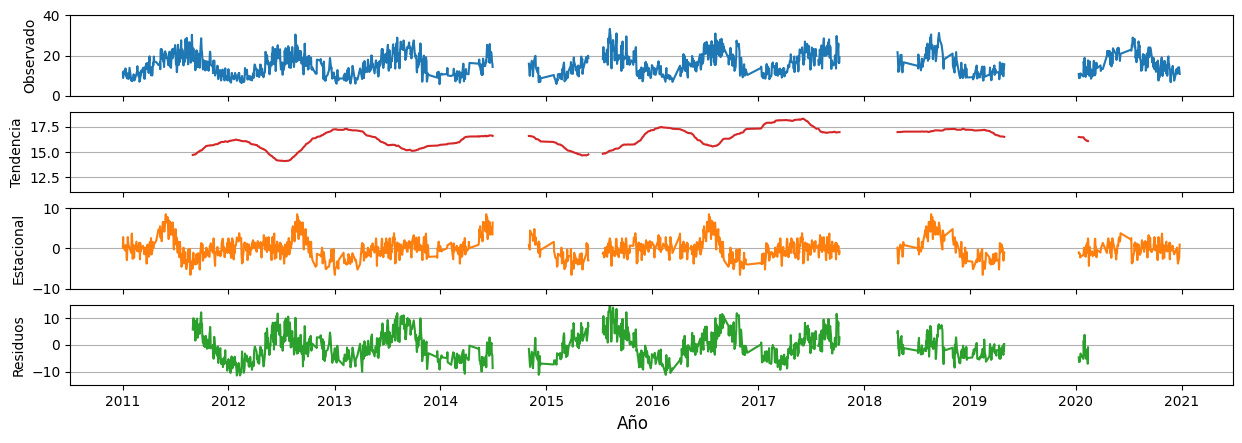

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(observado_MWR, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].plot(tendencia_MWR, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].plot(estacional_MWR, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].plot(residuos_MWR, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose MWR.pdf', format='pdf')
plt.savefig('Seasonal decompose MWR.pdf', format='pdf')'''
plt.show()

Ahora MERRA-2

In [ ]:
diario_MERRA.set_index('Combined', inplace=True)

In [ ]:
MERRA_decompose = seasonal_decompose(diario_MERRA['TQV'], model='additive', period=365)

In [ ]:
observado_MERRA = MERRA_decompose.observed
tendencia_MERRA = MERRA_decompose.trend
estacional_MERRA = MERRA_decompose.seasonal
residuos_MERRA = MERRA_decompose.resid

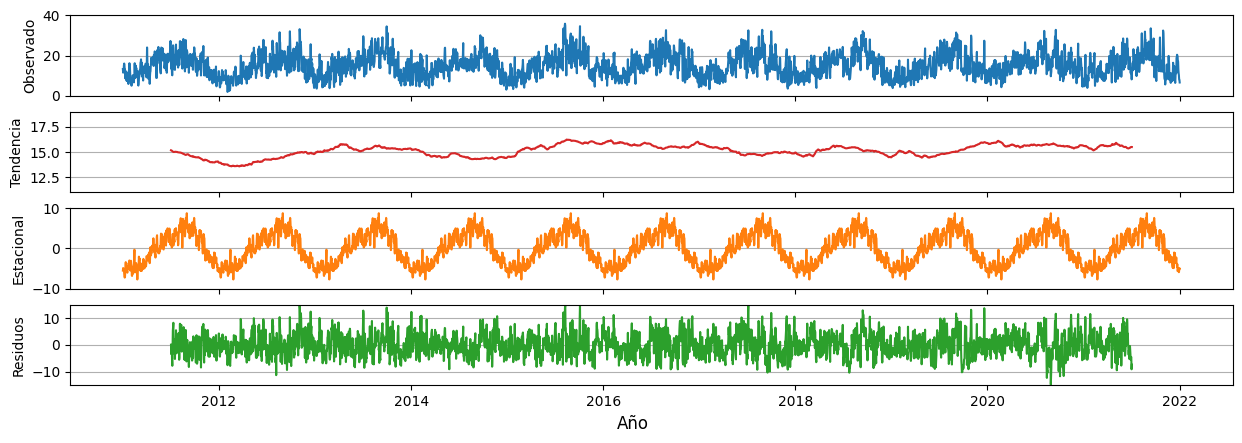

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(observado_MERRA, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].plot(tendencia_MERRA, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].plot(estacional_MERRA, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].plot(residuos_MERRA, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose MERRA-2.pdf', format='pdf')
plt.savefig('Seasonal decompose MERRA-2.png', format='png')'''
plt.show()

Ahora GNSS

In [ ]:
diario_granada.set_index('Combined', inplace=True)

In [ ]:
granada_decompose = seasonal_decompose(diario_granada['NGL_GNSS'], model='additive', period=365)

In [ ]:
observado_granada = granada_decompose.observed
tendencia_granada = granada_decompose.trend
estacional_granada = granada_decompose.seasonal
residuos_granada = granada_decompose.resid

observado_granada.loc[(observado_granada.index >= inicio_gap_GNSS) & (observado_granada.index <= fin_gap_GNSS)] = np.nan
tendencia_granada.loc[(tendencia_granada.index >= inicio_gap_GNSS) & (tendencia_granada.index <= fin_gap_GNSS)] = np.nan
estacional_granada.loc[(estacional_granada.index >= inicio_gap_GNSS) & (estacional_granada.index <= fin_gap_GNSS)] = np.nan
observado_granada.loc[(residuos_granada.index >= inicio_gap_GNSS) & (residuos_granada.index <= fin_gap_GNSS)] = np.nan

observado_granada.loc[(observado_granada.index >= inicio_gap_GNSS_2) & (observado_granada.index <= fin_gap_GNSS_2)] = np.nan
tendencia_granada.loc[(tendencia_granada.index >= inicio_gap_GNSS_2) & (tendencia_granada.index <= fin_gap_GNSS_2)] = np.nan
estacional_granada.loc[(estacional_granada.index >= inicio_gap_GNSS_2) & (estacional_granada.index <= fin_gap_GNSS_2)] = np.nan
residuos_granada.loc[(residuos_granada.index >= inicio_gap_GNSS_2) & (residuos_granada.index <= fin_gap_GNSS_2)] = np.nan

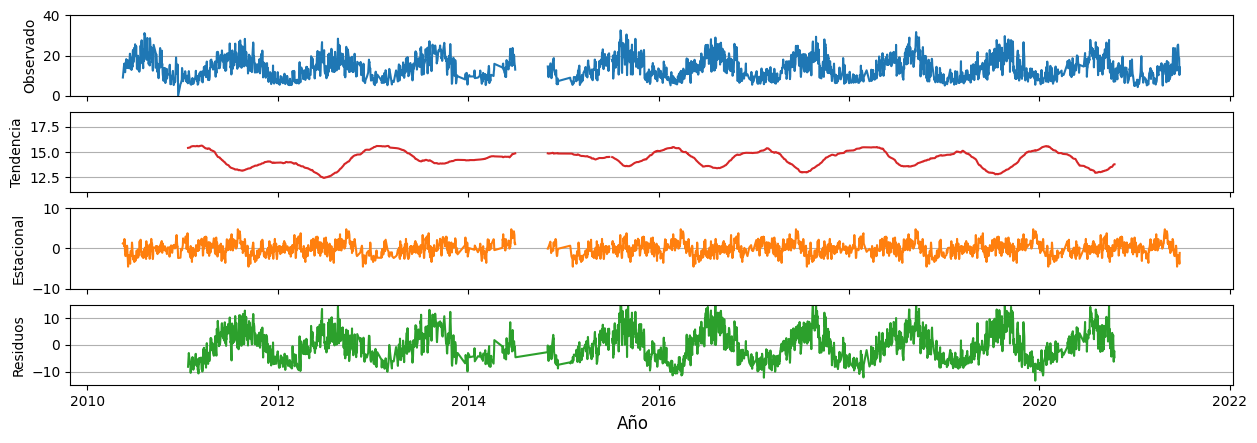

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(observado_granada, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].plot(tendencia_granada, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].plot(estacional_granada, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].plot(residuos_granada, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose GNSS.pdf', format='pdf')
plt.savefig('Seasonal decompose GNSS.png', format='png')'''
plt.show()

Ahora RS

In [ ]:
diario_SR.set_index('Combined', inplace=True)

In [ ]:
'''SR_decompose = seasonal_decompose(diario_SR['RS'], model='additive', period=365)'''

"SR_decompose = seasonal_decompose(diario_SR['RS'], model='additive', period=365)"

In [ ]:
'''observado_SR = SR_decompose.observed
tendencia_SR = SR_decompose.trend
estacional_SR = SR_decompose.seasonal
residuos_SR = SR_decompose.resid'''

'observado_SR = SR_decompose.observed\ntendencia_SR = SR_decompose.trend\nestacional_SR = SR_decompose.seasonal\nresiduos_SR = SR_decompose.resid'

In [ ]:
'''#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].scatter(observado_SR, color='tab:blue')
ax[0].set_ylabel('Observado')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].scatter(tendencia_SR, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].scatter(estacional_SR, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].scatter(residuos_SR, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

plt.savefig('Seasonal decompose RS.pdf', format='pdf')
plt.show()'''

"#Obtengo la gráfica con todos los datos que aporta el seasonal decompose\n\nfig, ax = plt.subplots(4, sharex=True)\n\nax[0].scatter(observado_SR, color='tab:blue')\nax[0].set_ylabel('Observado')\nax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))\nax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))\nax[0].grid(True, which='major', axis='y')\nax[0].set_ylim(0, 40)\n\nax[1].scatter(tendencia_SR, color='tab:red')\nax[1].set_ylabel('Tendencia')\nax[1].grid(True, which='major', axis='y')\nax[1].set_ylim(11, 19)\n\nax[2].scatter(estacional_SR, color='tab:orange')\nax[2].set_ylabel('Estacional')\nax[2].grid(True, which='major', axis='y')\nax[2].set_ylim(-10, 10)\n\nax[3].scatter(residuos_SR, color='tab:green')\nax[3].set_ylabel('Residuos')\nax[3].grid(True, which='major', axis='y')\nax[3].set_ylim(-15, 15)\n\nfig.set_figwidth(15)\nfig.supxlabel('Año')\n\nplt.savefig('Seasonal decompose RS.pdf', format='pdf')\nplt.show()"

Ahora realizamos las medias mensuales y realizamos este mismo análisis de seasonal decomposition

Primero obtenemos las medias mensuales

In [ ]:
#Media diaria de NGL_GNSS
mes_granada = f_granada.groupby(['Año', 'Mes']).mean()

mes_granada = mes_granada.reset_index()

def combine_columns_mes(row):
    return str(row['Año']) + str(row['Mes'])

mes_granada['Combined'] = mes_granada.apply(combine_columns_mes, axis=1)

mes_granada['Combined'] = pd.to_datetime(mes_granada['Combined'], format='%Y.0%m.0')

mes_granada

,Año,Mes,Dia,Hora,NGL_GNSS,Combined
0,2010,5,25.394366,12.492958,14.738873,2010-05-01
1,2010,6,16.176056,12.411972,16.663134,2010-06-01
2,2010,7,16.284900,12.612536,19.113504,2010-07-01
3,2010,8,15.919403,12.244776,21.042388,2010-08-01
4,2010,9,13.728643,12.437186,17.137236,2010-09-01
...,...,...,...,...,...,...
126,2021,2,18.911111,12.211111,8.122778,2021-02-01
127,2021,3,18.345794,11.990654,8.886075,2021-03-01
128,2021,4,12.759398,12.285714,12.481429,2021-04-01
129,2021,5,14.400000,11.934545,12.484073,2021-05-01


In [ ]:
#Media diaria de SP
mes_SP = f_SP.groupby(['Año', 'Mes']).mean()

mes_SP = mes_SP.reset_index()

mes_SP['Combined'] = mes_SP.apply(combine_columns_mes, axis=1)

mes_SP['Combined'] = pd.to_datetime(mes_SP['Combined'], format='%Y.0%m.0')

mes_SP

,Año,Mes,Dia,Hora,SP,NGL_GNSS,dif,Combined
0,2010,5,25.394366,12.492958,14.158832,14.738873,-0.580041,2010-05-01
1,2010,6,16.176056,12.411972,15.819307,16.663134,-0.843827,2010-06-01
2,2010,7,16.284900,12.612536,17.671530,19.113504,-1.441974,2010-07-01
3,2010,8,15.919403,12.244776,19.378372,21.042388,-1.664017,2010-08-01
4,2010,9,13.728643,12.437186,16.412644,17.137236,-0.724592,2010-09-01
...,...,...,...,...,...,...,...,...
109,2021,2,18.911111,12.211111,8.641141,8.122778,0.518363,2021-02-01
110,2021,3,18.345794,11.990654,9.111728,8.886075,0.225653,2021-03-01
111,2021,4,12.759398,12.285714,12.419949,12.481429,-0.061480,2021-04-01
112,2021,5,14.400000,11.934545,12.270805,12.484073,-0.213268,2021-05-01


In [ ]:
#Media diaria de MWR
mes_MWR = f_MWR.groupby(['Año', 'Mes']).mean()

mes_MWR = mes_MWR.reset_index()

mes_MWR['Combined'] = mes_MWR.apply(combine_columns_mes, axis=1)

mes_MWR['Combined'] = pd.to_datetime(mes_MWR['Combined'], format='%Y.0%m.0')

mes_MWR

,Año,Mes,Dia,Hora,MWR,NGL_GNSS,dif,Combined
0,2011,1,14.281899,11.747774,10.632662,9.002938,1.629724,2011-01-01
1,2011,2,15.129909,12.048338,10.184675,8.327553,1.857122,2011-02-01
2,2011,3,18.216359,12.013193,12.698919,10.823325,1.875595,2011-03-01
3,2011,4,10.927681,11.511222,14.302062,12.048828,2.253234,2011-04-01
4,2011,5,19.211310,11.979167,18.477948,16.883333,1.594615,2011-05-01
...,...,...,...,...,...,...,...,...
96,2020,8,13.773543,12.213004,20.029382,19.175179,0.854203,2020-08-01
97,2020,9,12.240476,12.178571,19.616314,18.872762,0.743552,2020-09-01
98,2020,10,17.240933,12.606218,14.310119,13.235492,1.074627,2020-10-01
99,2020,11,13.538012,12.070175,13.476566,12.368070,1.108496,2020-11-01


In [ ]:
#Media diaria de MERRA-2
mes_MERRA = f_MERRA.groupby(['Año', 'Mes']).mean()

mes_MERRA = mes_MERRA.reset_index()

mes_MERRA['Combined'] = mes_MERRA.apply(combine_columns_mes, axis=1)

mes_MERRA['Combined'] = pd.to_datetime(mes_MERRA['Combined'], format='%Y.0%m.0')

mes_MERRA

,Año,Mes,Dia,Hora,TQV,Combined
0,2011,1,16.433333,11.5,11.135818,2011-01-01
1,2011,2,14.500000,11.5,9.663236,2011-02-01
2,2011,3,16.000000,11.5,12.410157,2011-03-01
3,2011,4,15.500000,11.5,14.907311,2011-04-01
4,2011,5,16.000000,11.5,18.391543,2011-05-01
...,...,...,...,...,...,...
128,2021,9,15.500000,11.5,20.220345,2021-09-01
129,2021,10,16.000000,11.5,17.564470,2021-10-01
130,2021,11,15.500000,11.5,11.800346,2021-11-01
131,2021,12,16.000000,11.5,12.405647,2021-12-01


In [ ]:
#Media diaria de RS
mes_SR = f_SR.groupby(['Año', 'Mes']).mean()

mes_SR = mes_SR.reset_index()

mes_SR['Combined'] = mes_SR.apply(combine_columns_mes, axis=1)

mes_SR['Combined'] = pd.to_datetime(mes_SR['Combined'], format='%Y.0%m.0')

mes_SR

,Año,Mes,Dia,Hora,RS,Combined
0,2011,7,20.777778,15.000000,22.815095,2011-07-01
1,2011,11,21.000000,15.250000,14.736208,2011-11-01
2,2011,12,15.666667,14.333333,6.582343,2011-12-01
3,2012,3,22.500000,15.833333,10.220787,2012-03-01
4,2012,4,21.500000,14.750000,12.043775,2012-04-01
5,2012,5,19.000000,16.000000,12.779420,2012-05-01
6,2012,6,23.000000,9.500000,19.388105,2012-06-01
7,2012,7,10.000000,20.000000,18.030508,2012-07-01
8,2012,10,16.000000,16.000000,16.061830,2012-10-01
9,2012,12,13.500000,14.500000,14.153880,2012-12-01


Ahora hacemos el seasonal decomposition

SP

In [ ]:
mes_SP.set_index('Combined', inplace=True)

In [ ]:
SP_decompose_mes = seasonal_decompose(mes_SP['SP'], model='additive', period=12)

In [ ]:
observado_SP_mes = SP_decompose_mes.observed
tendencia_SP_mes = SP_decompose_mes.trend
estacional_SP_mes = SP_decompose_mes.seasonal
residuos_SP_mes = SP_decompose_mes.resid



observado_SP_mes.loc[(observado_SP_mes.index >= inicio_gap_SP_1) & (observado_SP_mes.index <= fin_gap_SP_1)] = np.nan
observado_SP_mes.loc[(observado_SP_mes.index >= inicio_gap_SP_2) & (observado_SP_mes.index <= fin_gap_SP_2)] = np.nan

tendencia_SP_mes.loc[(tendencia_SP_mes.index >= inicio_gap_SP_1) & (tendencia_SP_mes.index <= fin_gap_SP_1)] = np.nan
tendencia_SP_mes.loc[(tendencia_SP_mes.index >= inicio_gap_SP_2) & (tendencia_SP_mes.index <= fin_gap_SP_2)] = np.nan

estacional_SP_mes.loc[(estacional_SP_mes.index >= inicio_gap_SP_1) & (estacional_SP_mes.index <= fin_gap_SP_1)] = np.nan
estacional_SP_mes.loc[(estacional_SP_mes.index >= inicio_gap_SP_2) & (estacional_SP_mes.index <= fin_gap_SP_2)] = np.nan

residuos_SP_mes.loc[(residuos_SP_mes.index >= inicio_gap_SP_1) & (residuos_SP_mes.index <= fin_gap_SP_1)] = np.nan
residuos_SP_mes.loc[(residuos_SP_mes.index >= inicio_gap_SP_2) & (residuos_SP_mes.index <= fin_gap_SP_2)] = np.nan

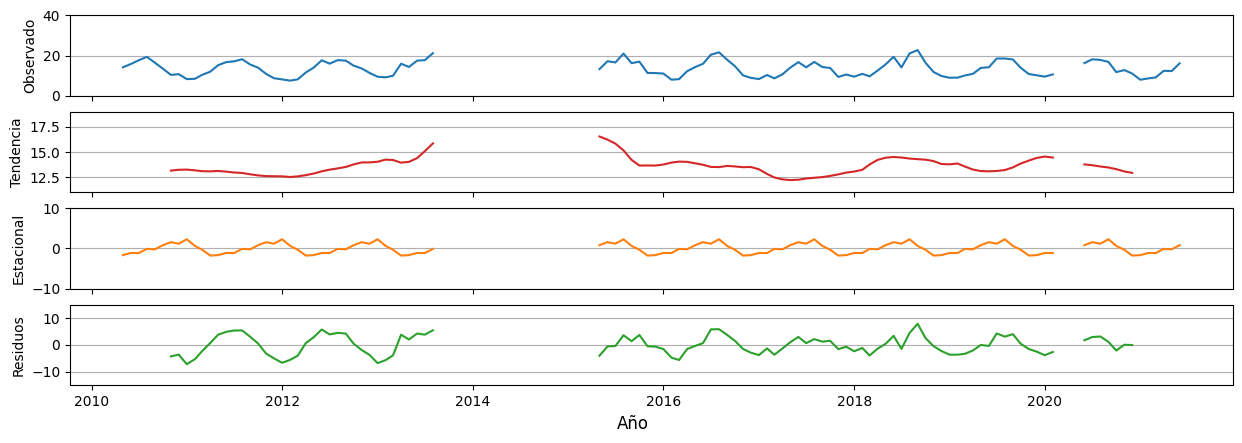

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(observado_SP_mes, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].plot(tendencia_SP_mes, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].plot(estacional_SP_mes, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].plot(residuos_SP_mes, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose SP mensual.pdf', format='pdf')
plt.savefig('Seasonal decompose SP mensual.png', format='png')'''
plt.show()

MWR

In [ ]:
mes_MWR.set_index('Combined', inplace=True)

In [ ]:
MWR_decompose_mes = seasonal_decompose(mes_MWR['MWR'], model='additive', period=12)

In [ ]:
observado_MWR_mes = MWR_decompose_mes.observed
tendencia_MWR_mes = MWR_decompose_mes.trend
estacional_MWR_mes = MWR_decompose_mes.seasonal
residuos_MWR_mes = MWR_decompose_mes.resid

observado_MWR_mes.loc[(observado_MWR_mes.index >= inicio_gap_MWR_1) & (observado_MWR_mes.index <= fin_gap_MWR_1)] = np.nan
tendencia_MWR_mes.loc[(tendencia_MWR_mes.index >= inicio_gap_MWR_1) & (tendencia_MWR_mes.index <= fin_gap_MWR_1)] = np.nan
estacional_MWR_mes.loc[(estacional_MWR_mes.index >= inicio_gap_MWR_1) & (estacional_MWR_mes.index <= fin_gap_MWR_1)] = np.nan
residuos_MWR_mes.loc[(residuos_MWR_mes.index >= inicio_gap_MWR_1) & (residuos_MWR_mes.index <= fin_gap_MWR_1)] = np.nan

observado_MWR_mes.loc[(observado_MWR_mes.index >= inicio_gap_MWR_2) & (observado_MWR_mes.index <= fin_gap_MWR_2)] = np.nan
tendencia_MWR_mes.loc[(tendencia_MWR_mes.index >= inicio_gap_MWR_2) & (tendencia_MWR_mes.index <= fin_gap_MWR_2)] = np.nan
estacional_MWR_mes.loc[(estacional_MWR_mes.index >= inicio_gap_MWR_2) & (estacional_MWR_mes.index <= fin_gap_MWR_2)] = np.nan
residuos_MWR_mes.loc[(residuos_MWR_mes.index >= inicio_gap_MWR_2)& (residuos_MWR_mes.index <= fin_gap_MWR_2)] = np.nan

observado_MWR_mes.loc[(observado_MWR_mes.index >= inicio_gap_MWR_3) & (observado_MWR_mes.index <= fin_gap_MWR_3)] = np.nan
tendencia_MWR_mes.loc[(tendencia_MWR_mes.index >= inicio_gap_MWR_3) & (tendencia_MWR_mes.index <= fin_gap_MWR_3)] = np.nan
estacional_MWR_mes.loc[(estacional_MWR_mes.index >= inicio_gap_MWR_3) & (estacional_MWR_mes.index <= fin_gap_MWR_3)] = np.nan
residuos_MWR_mes.loc[(residuos_MWR_mes.index >= inicio_gap_MWR_3) & (residuos_MWR_mes.index <= fin_gap_MWR_3)] = np.nan

observado_MWR_mes.loc[(observado_MWR_mes.index >= inicio_gap_MWR_4) & (observado_MWR_mes.index <= fin_gap_MWR_4)] = np.nan
tendencia_MWR_mes.loc[(tendencia_MWR_mes.index >= inicio_gap_MWR_4) & (tendencia_MWR_mes.index <= fin_gap_MWR_4)] = np.nan
estacional_MWR_mes.loc[(estacional_MWR_mes.index >= inicio_gap_MWR_4) & (estacional_MWR_mes.index <= fin_gap_MWR_4)] = np.nan
residuos_MWR_mes.loc[(residuos_MWR_mes.index >= inicio_gap_MWR_4) & (residuos_MWR_mes.index <= fin_gap_MWR_4)] = np.nan

observado_MWR_mes.loc[(observado_MWR_mes.index >= inicio_gap_MWR_5) & (observado_MWR_mes.index <= fin_gap_MWR_5)] = np.nan
tendencia_MWR_mes.loc[(tendencia_MWR_mes.index >= inicio_gap_MWR_5) & (tendencia_MWR_mes.index <= fin_gap_MWR_5)] = np.nan
estacional_MWR_mes.loc[(estacional_MWR_mes.index >= inicio_gap_MWR_5) & (estacional_MWR_mes.index <= fin_gap_MWR_5)] = np.nan
residuos_MWR_mes.loc[(residuos_MWR_mes.index >= inicio_gap_MWR_5) & (residuos_MWR_mes.index <= fin_gap_MWR_5)] = np.nan

observado_MWR_mes.loc[(observado_MWR_mes.index >= inicio_gap_MWR_6) & (observado_MWR_mes.index <= fin_gap_MWR_6)] = np.nan
tendencia_MWR_mes.loc[(tendencia_MWR_mes.index >= inicio_gap_MWR_6) & (tendencia_MWR_mes.index <= fin_gap_MWR_6)] = np.nan
estacional_MWR_mes.loc[(estacional_MWR_mes.index >= inicio_gap_MWR_6) & (estacional_MWR_mes.index <= fin_gap_MWR_6)] = np.nan
residuos_MWR_mes.loc[(residuos_MWR_mes.index >= inicio_gap_MWR_6) & (residuos_MWR_mes.index <= fin_gap_MWR_6)] = np.nan

observado_MWR_mes.loc[(observado_MWR_mes.index >= inicio_gap_MWR_7) & (observado_MWR_mes.index <= fin_gap_MWR_7)] = np.nan
tendencia_MWR_mes.loc[(tendencia_MWR_mes.index >= inicio_gap_MWR_7) & (tendencia_MWR_mes.index <= fin_gap_MWR_7)] = np.nan
estacional_MWR_mes.loc[(estacional_MWR_mes.index >= inicio_gap_MWR_7) & (estacional_MWR_mes.index <= fin_gap_MWR_7)] = np.nan
residuos_MWR_mes.loc[(residuos_MWR_mes.index >= inicio_gap_MWR_7) & (residuos_MWR_mes.index <= fin_gap_MWR_7)] = np.nan

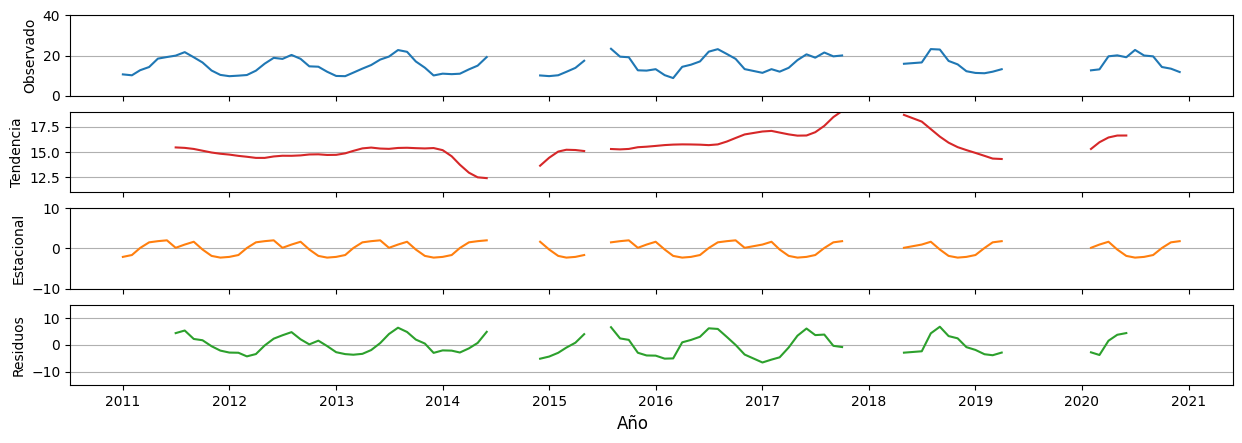

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(observado_MWR_mes, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].plot(tendencia_MWR_mes, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].plot(estacional_MWR_mes, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].plot(residuos_MWR_mes, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose MWR mensual.pdf', format='pdf')
plt.savefig('Seasonal decompose MWR mensual.png', format='png')'''
plt.show()

MERRA-2

In [ ]:
mes_MERRA.set_index('Combined', inplace=True)

In [ ]:
MERRA_decompose_mes = seasonal_decompose(mes_MERRA['TQV'], model='additive', period=12)

In [ ]:
observado_MERRA_mes = MERRA_decompose_mes.observed
tendencia_MERRA_mes = MERRA_decompose_mes.trend
estacional_MERRA_mes = MERRA_decompose_mes.seasonal
residuos_MERRA_mes = MERRA_decompose_mes.resid

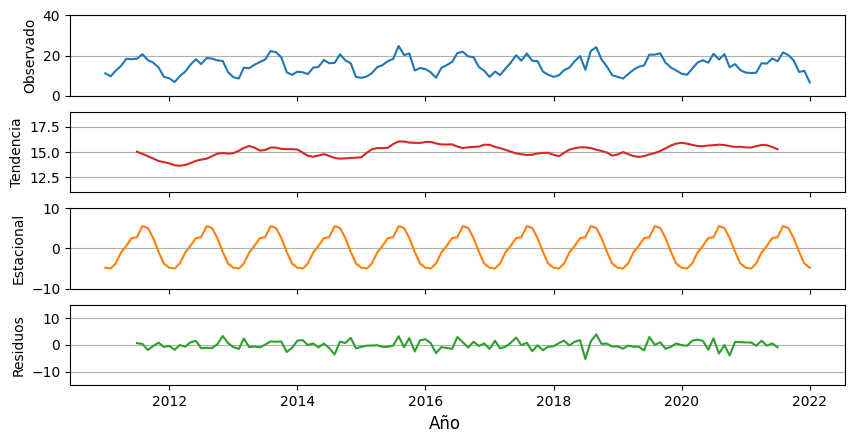

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(observado_MERRA_mes, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].plot(tendencia_MERRA_mes, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].plot(estacional_MERRA_mes, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].plot(residuos_MERRA_mes, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(10)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose MERRA-2 mensual.pdf', format='pdf')
plt.savefig('Seasonal decompose MERRA-2 mensual.png', format='png')'''
plt.show()

GNSS

In [ ]:
mes_granada.set_index('Combined', inplace=True)

In [ ]:
granada_decompose_mes = seasonal_decompose(mes_granada['NGL_GNSS'], model='additive', period=12)

In [ ]:
observado_granada_mes = granada_decompose_mes.observed
tendencia_granada_mes = granada_decompose_mes.trend
estacional_granada_mes = granada_decompose_mes.seasonal
residuos_granada_mes = granada_decompose_mes.resid

observado_granada_mes.loc[(observado_granada_mes.index >= inicio_gap_GNSS) & (observado_granada_mes.index <= fin_gap_GNSS)] = np.nan
tendencia_granada_mes.loc[(tendencia_granada_mes.index >= inicio_gap_GNSS) & (tendencia_granada_mes.index <= fin_gap_GNSS)] = np.nan
estacional_granada_mes.loc[(estacional_granada_mes.index >= inicio_gap_GNSS) & (estacional_granada_mes.index <= fin_gap_GNSS)] = np.nan
observado_granada.loc[(residuos_granada.index >= inicio_gap_GNSS) & (residuos_granada.index <= fin_gap_GNSS)] = np.nan

observado_granada_mes.loc[(observado_granada_mes.index >= inicio_gap_GNSS_2) & (observado_granada_mes.index <= fin_gap_GNSS_2)] = np.nan
tendencia_granada_mes.loc[(tendencia_granada_mes.index >= inicio_gap_GNSS_2) & (tendencia_granada_mes.index <= fin_gap_GNSS_2)] = np.nan
estacional_granada_mes.loc[(estacional_granada_mes.index >= inicio_gap_GNSS_2) & (estacional_granada_mes.index <= fin_gap_GNSS_2)] = np.nan
residuos_granada_mes.loc[(residuos_granada_mes.index >= inicio_gap_GNSS_2) & (residuos_granada_mes.index <= fin_gap_GNSS_2)] = np.nan

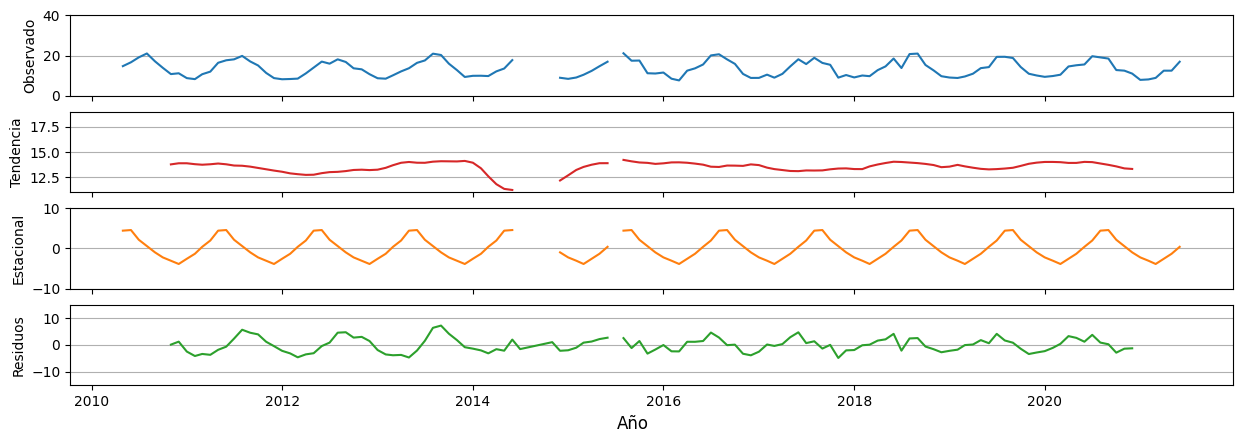

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(observado_granada_mes, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].plot(tendencia_granada_mes, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].plot(estacional_granada_mes, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].plot(residuos_granada_mes, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose GNSS mensual.pdf', format='pdf')
plt.savefig('Seasonal decompose GNSS mensual.png', format='png')'''
plt.show()

RS

In [ ]:
mes_SR.set_index('Combined', inplace=True)

In [ ]:
granada_SR_mes = seasonal_decompose(mes_SR['RS'], model='additive', period=12)

In [ ]:
observado_SR_mes = granada_SR_mes.observed
tendencia_SR_mes = granada_SR_mes.trend
estacional_SR_mes = granada_SR_mes.seasonal
residuos_SR_mes = granada_SR_mes.resid

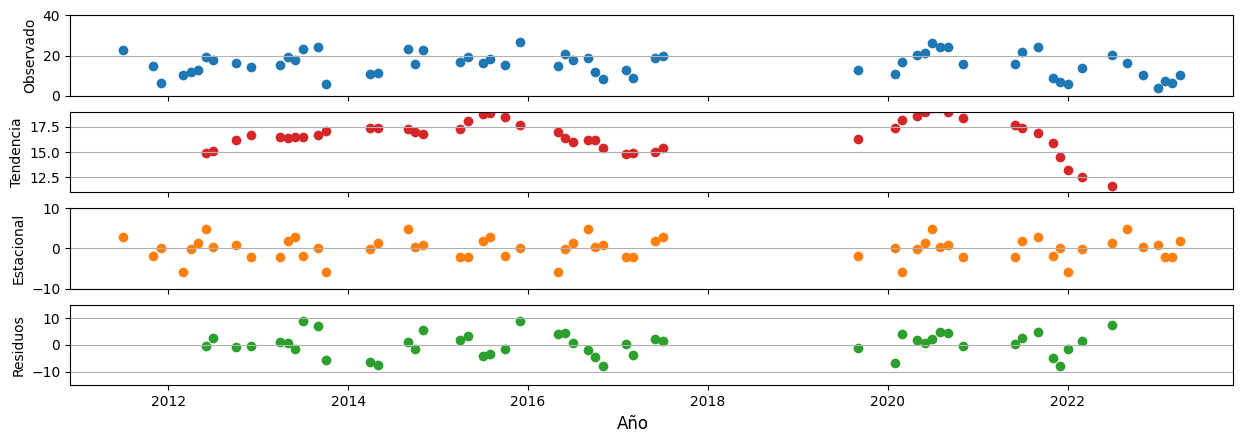

In [ ]:
#Obtengo la gráfica con todos los datos que aporta el seasonal decompose

fig, ax = plt.subplots(4, sharex=True)

ax[0].scatter(observado_SR_mes.index, observado_SR_mes, color='tab:blue')
ax[0].set_ylabel('Observado')
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(480))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(240))
ax[0].grid(True, which='major', axis='y')
ax[0].set_ylim(0, 40)

ax[1].scatter(tendencia_SR_mes.index, tendencia_SR_mes, color='tab:red')
ax[1].set_ylabel('Tendencia')
ax[1].grid(True, which='major', axis='y')
ax[1].set_ylim(11, 19)

ax[2].scatter(estacional_SR_mes.index, estacional_SR_mes, color='tab:orange')
ax[2].set_ylabel('Estacional')
ax[2].grid(True, which='major', axis='y')
ax[2].set_ylim(-10, 10)

ax[3].scatter(residuos_SR_mes.index, residuos_SR_mes, color='tab:green')
ax[3].set_ylabel('Residuos')
ax[3].grid(True, which='major', axis='y')
ax[3].set_ylim(-15, 15)

fig.set_figwidth(15)
fig.supxlabel('Año')

'''plt.savefig('Seasonal decompose RS mensual.pdf', format='pdf')
plt.savefig('Seasonal decompose RS mensual.png', format='png')'''
plt.show()

In [ ]:
calculos_estadisticos1 = [['Media', union_SP_SR['RS'].mean(), union_MWR_SR['RS'].mean(), union_SR_MERRA['RS'].mean(), union_granada_SR['RS'].mean()],
                        ['MBE',union_SP_SR['dif_RS'].mean(), union_MWR_SR['dif_RS'].mean(), union_SR_MERRA['dif_RS'].mean(), union_granada_SR['dif_RS'].mean()],
                        ['MBEr',union_SP_SR['relativo_RS'].mean(), union_MWR_SR['relativo_RS'].mean(), union_SR_MERRA['relativo_RS'].mean(), union_granada_SR['relativo_RS'].mean()],
                        ['SD',union_SP_SR['dif_RS'].std(), union_MWR_SR['dif_RS'].std(), union_SR_MERRA['dif_RS'].std(), union_granada_SR['dif_RS'].std()],
                        ['SDr',union_SP_SR['relativo_RS'].std(), union_MWR_SR['relativo_RS'].std(), union_SR_MERRA['relativo_RS'].std(), union_granada_SR['relativo_RS'].std()]]

valores_estadisticos1 = pd.DataFrame(calculos_estadisticos1, columns=['Estadistica', 'SP', 'MWR', 'MERRA-2', 'GNSS'])

valores_estadisticos1

,Estadistica,SP,MWR,MERRA-2,GNSS
0,Media,16.304155,15.776704,16.640841,15.949325
1,MBE,-0.095669,1.794275,0.613350,-0.004688
2,MBEr,40.057512,57.908927,69.458453,42.013944
3,SD,3.696368,3.614921,4.405106,3.580408
4,SDr,209.253492,252.516713,514.631761,227.032419


In [ ]:
hasta aquí

SyntaxError: invalid syntax (4249173014.py, line 1)

In [ ]:
#Media anual de GGL_GNSS

anual_granada = f_granada.groupby(['Año']).mean()

#Borro la columna de la hora (No se por qué no se borra)
anual_granada.drop(columns=['Hora'], axis=1)

anual_granada = anual_granada.reset_index()

def combine_columns_anual(row):
    return str(row['Año'])

anual_granada['Combined'] = anual_granada.apply(combine_columns_anual, axis=1)

anual_granada['Combined'] = pd.to_datetime(anual_granada['Combined'], format='%Y.0')

anual_granada

In [ ]:
#Media anual de SP

anual_SP = f_SP.groupby(['Año']).mean()

#Borro la columna de la hora (No se por qué no se borra)
anual_SP.drop(columns=['Hora'], axis=1)

anual_SP = anual_SP.reset_index()

anual_SP['Combined'] = anual_SP.apply(combine_columns_anual, axis=1)

anual_SP['Combined'] = pd.to_datetime(anual_SP['Combined'], format='%Y.0')

anual_SP

In [ ]:
#Media anual de MWR

anual_MWR = f_MWR.groupby(['Año']).mean()

#Borro la columna de la hora (No se por qué no se borra)
anual_MWR.drop(columns=['Hora'], axis=1)

anual_MWR = anual_MWR.reset_index()

anual_MWR['Combined'] = anual_MWR.apply(combine_columns_anual, axis=1)

anual_MWR['Combined'] = pd.to_datetime(anual_MWR['Combined'], format='%Y.0')

anual_MWR

In [ ]:
#Media anual de MERRA

anual_MERRA = f_MERRA.groupby(['Año']).mean()

anual_MERRA = anual_MERRA.reset_index()

anual_MERRA['Combined'] = anual_MERRA.apply(combine_columns_anual, axis=1)

anual_MERRA['Combined'] = pd.to_datetime(anual_MERRA['Combined'], format='%Y.0')

anual_MERRA.drop(anual_MERRA.tail(1).index, inplace = True)

anual_MERRA

In [ ]:
#Media anual de RS

anual_SR = f_SR.groupby(['Año']).mean()

anual_SR = anual_SR.reset_index()

anual_SR['Combined'] = anual_SR.apply(combine_columns_anual, axis=1)

anual_SR['Combined'] = pd.to_datetime(anual_SR['Combined'], format='%Y.0')

anual_SR.drop(anual_SR.tail(1).index, inplace = True)

anual_SR

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua obtenida por GNSS

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_granada.Combined, anual_granada.NGL_GNSS, width=300)
ax.scatter(anual_granada.Combined, anual_granada.NGL_GNSS,  color='tab:red')
ax.plot(anual_granada.Combined, anual_granada.NGL_GNSS, color='tab:red')

ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (GNSS)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua obtenida por SP

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_SP.Combined, anual_SP.SP, width=300)
ax.scatter(anual_SP.Combined, anual_SP.SP,  color='tab:red')
ax.plot(anual_SP.Combined, anual_SP.SP, color='tab:red')

ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (SP)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua obtenida por MWR

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MWR.Combined, anual_MWR.MWR, width=300)
ax.scatter(anual_MWR.Combined, anual_MWR.MWR,  color='tab:red')
ax.plot(anual_MWR.Combined, anual_MWR.MWR, color='tab:red')

ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MWR)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua obtenida por MERRA

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MERRA.Combined, anual_MERRA.TQV, width=300)
ax.scatter(anual_MERRA.Combined, anual_MERRA.TQV,  color='tab:red')
ax.plot(anual_MERRA.Combined, anual_MERRA.TQV, color='tab:red')

ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MERRA-2)')
plt.show()

In [ ]:
anual_SR

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua obtenida por RS

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_SR.Combined, anual_SR.RS, width=300)
ax.scatter(anual_SR.Combined, anual_SR.RS,  color='tab:red')
ax.plot(anual_SR.Combined, anual_SR.RS, color='tab:red')

ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (RS)')
plt.show()

Ahora igual pero con las diferencias relativas con respecto a GNSS

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por SP

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_SP.Combined, anual_SP.dif, width=300)
ax.scatter(anual_SP.Combined, anual_SP.dif,  color='tab:red')
ax.plot(anual_SP.Combined, anual_SP.dif, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (SP)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MWR

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MWR.Combined, anual_MWR.dif, width=300)
ax.scatter(anual_MWR.Combined, anual_MWR.dif,  color='tab:red')
ax.plot(anual_MWR.Combined, anual_MWR.dif, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MWR)')
plt.show()

In [ ]:
#Media anual de MERRA
anual_MERRA_dif = union_granada_MERRA.groupby(['Año']).mean()

anual_MERRA_dif = anual_MERRA_dif.reset_index()

anual_MERRA_dif['Combined'] = anual_MERRA_dif.apply(combine_columns_anual, axis=1)

anual_MERRA_dif['Combined'] = pd.to_datetime(anual_MERRA_dif['Combined'], format='%Y.0')

anual_MERRA_dif.drop(anual_MERRA.tail(1).index, inplace = True)

anual_MERRA_dif

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MERRA

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MERRA_dif.Combined, anual_MERRA_dif.dif, width=300)
ax.scatter(anual_MERRA_dif.Combined, anual_MERRA_dif.dif,  color='tab:red')
ax.plot(anual_MERRA_dif.Combined, anual_MERRA_dif.dif, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MERRA-2)')
plt.show()

Igual con RS

In [ ]:
#Media anual de MERRA
anual_SR_dif = union_granada_SR.groupby(['Año']).mean()

anual_SR_dif = anual_SR_dif.reset_index()

anual_SR_dif['Combined'] = anual_SR_dif.apply(combine_columns_anual, axis=1)

anual_SR_dif['Combined'] = pd.to_datetime(anual_SR_dif['Combined'], format='%Y.0')

#anual_SR_dif.drop(anual_SR.tail(1).index, inplace = True)

anual_SR_dif

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MERRA

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_SR_dif.Combined, anual_SR_dif.dif, width=300)
ax.scatter(anual_SR_dif.Combined, anual_SR_dif.dif,  color='tab:red')
ax.plot(anual_SR_dif.Combined, anual_SR_dif.dif, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (SR)')
plt.show()

Ahora con el error relativo, tomando GNSS como referencia

In [ ]:
anual_SP.insert(7, 'relativo', anual_SP['dif']/anual_SP['NGL_GNSS'])

In [ ]:
anual_MWR.insert(7, 'relativo', anual_MWR['dif']/anual_MWR['NGL_GNSS'])

In [ ]:
anual_MERRA_dif.insert(8, 'relativo', anual_MERRA_dif['dif']/anual_MERRA_dif['NGL_GNSS'])

In [ ]:
anual_SR_dif.insert(8, 'relativo', anual_SR_dif['dif']/anual_SR_dif['NGL_GNSS'])

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MWR

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_SP.Combined, anual_SP.relativo, width=300)
ax.scatter(anual_SP.Combined, anual_SP.relativo,  color='tab:red')
ax.plot(anual_SP.Combined, anual_SP.relativo, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (SP)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MWR

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MWR.Combined, anual_MWR.relativo, width=300)
ax.scatter(anual_MWR.Combined, anual_MWR.relativo,  color='tab:red')
ax.plot(anual_MWR.Combined, anual_MWR.relativo, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MWR)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MERRA

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MERRA_dif.Combined, anual_MERRA_dif.relativo, width=300)
ax.scatter(anual_MERRA_dif.Combined, anual_MERRA_dif.relativo,  color='tab:red')
ax.plot(anual_MERRA_dif.Combined, anual_MERRA_dif.relativo, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MERRA-2)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MERRA

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_SR_dif.Combined, anual_SR_dif.relativo, width=300)
ax.scatter(anual_SR_dif.Combined, anual_SR_dif.relativo,  color='tab:red')
ax.plot(anual_SR_dif.Combined, anual_SR_dif.relativo, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (SR)')
plt.show()

Ahora se realiza lo mismo tomando de referencia el RS con el resto de instrumentos

Primero, tengo que crear las columnas para la diferencia entre RS y el resto

In [ ]:
union_SP_SR

In [ ]:
union_SP_SR.insert(6, 'dif_RS', union_SP_SR['SP'] - union_SP_SR['RS'])

In [ ]:
union_MWR_SR.insert(6, 'dif_RS', union_MWR_SR['MWR'] - union_MWR_SR['RS'])

In [ ]:
union_SR_MERRA.insert(6, 'dif_RS', union_SR_MERRA['TQV'] - union_SR_MERRA['RS'])

In [ ]:
union_granada_SR.insert(6, 'dif_RS', union_granada_SR['NGL_GNSS'] - union_granada_SR['RS'])

In [ ]:
union_SP_SR.insert(7, 'RelDif_RS', union_SP_SR['dif_RS']/(union_SP_SR['RS']/100))

In [ ]:
union_MWR_SR.insert(7, 'RelDif_RS', union_MWR_SR['dif_RS']/(union_MWR_SR['RS']/100))

In [ ]:
union_SR_MERRA.insert(7, 'RelDif_RS', union_SR_MERRA['dif_RS']/(union_SR_MERRA['RS']/100))

In [ ]:
union_granada_SR.insert(7, 'RelDif_RS', union_granada_SR['dif_RS']/(union_granada_SR['RS']/100))

In [ ]:
union_SP_SR.insert(9, 'relativo_RS', union_SP_SR['dif_RS']/union_SP_SR['RS'])

In [ ]:
union_MWR_SR.insert(9, 'relativo_RS', union_MWR_SR['dif_RS']/union_MWR_SR['RS'])

In [ ]:
union_SR_MERRA.insert(8, 'relativo_RS', union_SR_MERRA['dif_RS']/union_SR_MERRA['RS'])

In [ ]:
union_granada_SR.insert(9, 'relativo_RS', union_granada_SR['dif_RS']/union_granada_SR['RS'])

In [ ]:
#Media diaria de la unión de RS y SP

union_SP_SR_diario = union_SP_SR.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_SP_SR_diario = union_SP_SR_diario.reset_index()

union_SP_SR_diario['Combined'] = union_SP_SR_diario.apply(combine_columns, axis=1)

union_SP_SR_diario['Combined'] = pd.to_datetime(union_SP_SR_diario['Combined'], format='%Y.0%m.0%d.0')

union_SP_SR_diario

In [ ]:
#Media diaria de la unión de RS y MWR

union_MWR_SR_diario = union_MWR_SR.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_MWR_SR_diario = union_MWR_SR_diario.reset_index()

union_MWR_SR_diario['Combined'] = union_MWR_SR_diario.apply(combine_columns, axis=1)

union_MWR_SR_diario['Combined'] = pd.to_datetime(union_MWR_SR_diario['Combined'], format='%Y.0%m.0%d.0')

union_MWR_SR_diario

In [ ]:
#Media diaria de la unión de RS y MERRA

union_SR_MERRA_diario = union_SR_MERRA.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_SR_MERRA_diario = union_SR_MERRA_diario.reset_index()

union_SR_MERRA_diario['Combined'] = union_SR_MERRA_diario.apply(combine_columns, axis=1)

union_SR_MERRA_diario['Combined'] = pd.to_datetime(union_SR_MERRA_diario['Combined'], format='%Y.0%m.0%d.0')

union_SR_MERRA_diario

In [ ]:
#Media diaria de la unión de RS y GNSS

union_granada_SR_diario = union_granada_SR.groupby(['Año', 'Mes', 'Dia']).mean()

#=========================================#

union_granada_SR_diario = union_granada_SR_diario.reset_index()

union_granada_SR_diario['Combined'] = union_granada_SR_diario.apply(combine_columns, axis=1)

union_granada_SR_diario['Combined'] = pd.to_datetime(union_granada_SR_diario['Combined'], format='%Y.0%m.0%d.0')

union_granada_SR_diario

In [ ]:
#Media anual de SP y RS
anual_SP_dif_SR = union_SP_SR.groupby(['Año']).mean()

anual_SP_dif_SR = anual_SP_dif_SR.reset_index()

anual_SP_dif_SR['Combined'] = anual_SP_dif_SR.apply(combine_columns_anual, axis=1)

anual_SP_dif_SR['Combined'] = pd.to_datetime(anual_SP_dif_SR['Combined'], format='%Y.0')

#anual_SP_dif_SR.drop(anual_MERRA.tail(1).index, inplace = True)

anual_SP_dif_SR

In [ ]:
#Media anual de SP y RS
anual_MWR_dif_SR = union_MWR_SR.groupby(['Año']).mean()

anual_MWR_dif_SR = anual_MWR_dif_SR.reset_index()

anual_MWR_dif_SR['Combined'] = anual_MWR_dif_SR.apply(combine_columns_anual, axis=1)

anual_MWR_dif_SR['Combined'] = pd.to_datetime(anual_MWR_dif_SR['Combined'], format='%Y.0')

#anual_SP_dif_SR.drop(anual_MERRA.tail(1).index, inplace = True)

anual_MWR_dif_SR

In [ ]:
#Media anual de SP y RS
anual_MERRA_dif_SR = union_SR_MERRA.groupby(['Año']).mean()

anual_MERRA_dif_SR = anual_MERRA_dif_SR.reset_index()

anual_MERRA_dif_SR['Combined'] = anual_MERRA_dif_SR.apply(combine_columns_anual, axis=1)

anual_MERRA_dif_SR['Combined'] = pd.to_datetime(anual_MERRA_dif_SR['Combined'], format='%Y.0')

#anual_SP_dif_SR.drop(anual_MERRA.tail(1).index, inplace = True)

anual_MERRA_dif_SR

In [ ]:
#Media anual de SP y RS
anual_granada_dif_SR = union_granada_SR.groupby(['Año']).mean()

anual_granada_dif_SR = anual_granada_dif_SR.reset_index()

anual_granada_dif_SR['Combined'] = anual_granada_dif_SR.apply(combine_columns_anual, axis=1)

anual_granada_dif_SR['Combined'] = pd.to_datetime(anual_granada_dif_SR['Combined'], format='%Y.0')

#anual_SP_dif_SR.drop(anual_MERRA.tail(1).index, inplace = True)

anual_granada_dif_SR

Realizamos ahora las mismas gráficas anteriores de diferencia y diferencia relativa, ahora con RS

In [ ]:
#Diferencia con respecto a RS

fig, ax = plt.subplots(4, sharex=True, constrained_layout=True)

ax[0].plot(union_MWR_SR_diario.Combined, union_MWR_SR_diario.dif_RS, label='MWR', color='tab:blue')
ax[0].grid(True, which='major', axis='y')
ax[0].legend(loc='upper right')
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(6))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(3))


ax[1].plot(union_SP_SR_diario.Combined, union_SP_SR_diario.dif_RS, label='SP', color='tab:red')
ax[1].grid(True, which='major', axis='y')
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(6))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(3))

ax[2].plot(union_SR_MERRA_diario.Combined, union_SR_MERRA_diario.dif_RS, label='MERRA-2', color='tab:orange')
ax[2].grid(True, which='major', axis='y')
ax[2].legend(loc='upper right')
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(6))
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(3))

ax[3].plot(union_granada_SR_diario.Combined, union_granada_SR_diario.dif_RS, label='GNSS', color='tab:purple')
ax[3].grid(True, which='major', axis='y')
ax[3].legend(loc='upper right')
ax[3].yaxis.set_major_locator(ticker.MultipleLocator(6))
ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(3))

#Ponemos ahora el eje x (no queda bien)
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(9000))
#ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(90))

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel(r'$\Delta$IWV')
plt.show()

Ahora relativa (REHACER)

In [ ]:
fig, ax = plt.subplots(4, sharex=True, constrained_layout=True)

ax[0].plot(union_MWR_SR_diario.Combined, union_MWR_SR_diario.relativo_RS, label='MWR', color='tab:blue')
ax[0].grid(True, which='major', axis='y')
ax[0].legend(loc='upper right')
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


ax[1].plot(union_SP_SR_diario.Combined, union_SP_SR_diario.relativo_RS, label='SP', color='tab:red')
ax[1].grid(True, which='major', axis='y')
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax[2].plot(union_SR_MERRA_diario.Combined, union_SR_MERRA_diario.relativo_RS, label='MERRA-2', color='tab:orange')
ax[2].grid(True, which='major', axis='y')
ax[2].legend(loc='upper right')
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax[3].plot(union_granada_SR_diario.Combined, union_granada_SR_diario.relativo_RS, label='GNSS', color='tab:purple')
ax[3].grid(True, which='major', axis='y')
ax[3].legend(loc='upper right')
ax[3].yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel(r'$\Delta IWV_r$')
plt.show()

Ahora los valores anuales en tablas

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_SP_dif_SR.Combined, anual_SP_dif_SR.dif_RS, width=300)
ax.scatter(anual_SP_dif_SR.Combined, anual_SP_dif_SR.dif_RS,  color='tab:red')
ax.plot(anual_SP_dif_SR.Combined, anual_SP_dif_SR.dif_RS, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (SP)')
plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MWR_dif_SR.Combined, anual_MWR_dif_SR.dif_RS, width=300)
ax.scatter(anual_MWR_dif_SR.Combined, anual_MWR_dif_SR.dif_RS,  color='tab:red')
ax.plot(anual_MWR_dif_SR.Combined, anual_MWR_dif_SR.dif_RS, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MWR)')
plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MERRA_dif_SR.Combined, anual_MERRA_dif_SR.dif_RS, width=300)
ax.scatter(anual_MERRA_dif_SR.Combined, anual_MERRA_dif_SR.dif_RS,  color='tab:red')
ax.plot(anual_MERRA_dif_SR.Combined, anual_MERRA_dif_SR.dif_RS, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MERRA-2)')
plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_granada_dif_SR.Combined, anual_granada_dif_SR.dif_RS, width=300)
ax.scatter(anual_granada_dif_SR.Combined, anual_granada_dif_SR.dif_RS,  color='tab:red')
ax.plot(anual_granada_dif_SR.Combined, anual_granada_dif_SR.dif_RS, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (GNSS)')
plt.show()

Ahora relativo

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MWR

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_SP_dif_SR.Combined, anual_SP_dif_SR.relativo_RS, width=300)
ax.scatter(anual_SP_dif_SR.Combined, anual_SP_dif_SR.relativo_RS,  color='tab:red')
ax.plot(anual_SP_dif_SR.Combined, anual_SP_dif_SR.relativo_RS, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (SP)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MWR

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MWR_dif_SR.Combined, anual_MWR_dif_SR.relativo_RS, width=300)
ax.scatter(anual_MWR_dif_SR.Combined, anual_MWR_dif_SR.relativo_RS,  color='tab:red')
ax.plot(anual_MWR_dif_SR.Combined, anual_MWR_dif_SR.relativo_RS, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MWR)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MWR

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_MERRA_dif_SR.Combined, anual_MERRA_dif_SR.relativo_RS, width=300)
ax.scatter(anual_MERRA_dif_SR.Combined, anual_MERRA_dif_SR.relativo_RS,  color='tab:red')
ax.plot(anual_MERRA_dif_SR.Combined, anual_MERRA_dif_SR.relativo_RS, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (MERRA-2)')
plt.show()

In [ ]:
#Creo la gráfica de barras de la evolución anual del vapor de agua relativa obtenida por MWR

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(anual_granada_dif_SR.Combined, anual_granada_dif_SR.relativo_RS, width=300)
ax.scatter(anual_granada_dif_SR.Combined, anual_granada_dif_SR.relativo_RS,  color='tab:red')
ax.plot(anual_granada_dif_SR.Combined, anual_granada_dif_SR.relativo_RS, color='tab:red')
ax.grid(True, which='major', axis='y')

fig.set_figwidth(15)
fig.supxlabel('Año')
fig.supylabel('IWV (GNSS)')
plt.show()